In [32]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"




Modules loaded
Reload complete
GPUs available: 1


In [11]:
%%javascript
Jupyter.keyboard_manager.disable();
//System.out.println("disabled");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('j');
//System.out.println("remove j");
//Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('k');
//System.out.println("remove k");

<IPython.core.display.Javascript object>

Total number of training images = 1946


<IPython.core.display.Javascript object>


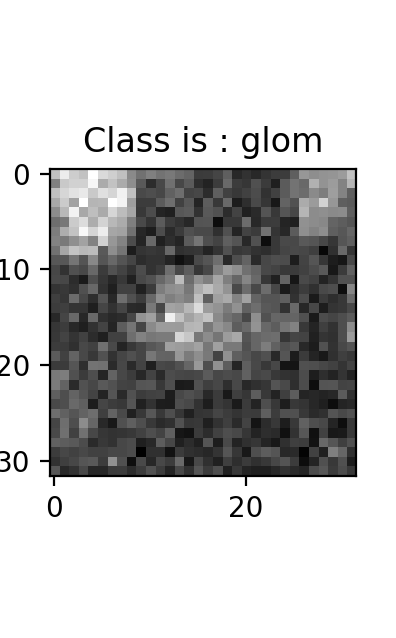

interactive(children=(IntSlider(value=0, description='layer', max=6), Output()), _dom_classes=('widget-interac…

In [31]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
print("Total number of training images = " + str(data_loader.dataset.data_len))
valid_data_loader = data_loader.split_validation() #allocate some images as validation

normalized = False
util.visualizeBatch(data_loader, normalized) 

In [33]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def set_instance(module, name, config, *args):
    setattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,7,32,32))
     
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for criterion function specified in config
    criterion = loss(data_loader.dataset.weight.to(device)) # for imbalanced datasets
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    
    trainer = Trainer(model, criterion, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)
    
    
    findLR = False
    if findLR:
        #set lr = 1e-7 in config file 
        device_lr = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        lr_finder_training = lr_finder.LRFinder(model, optimizer, criterion, device=device_lr)
        lr_finder_training.range_test(data_loader, end_lr=1, num_iter=100, val_loader = valid_data_loader)
        lr_finder_training.plot(skip_start = 10, skip_end=5)
        # trim the first 10 and last 5 iteration from calculating loss (num_iter > skip_start + skip_end)
    else:
        trainer.train()
        a=1
    
 

In [34]:
config_file = '../configs/config_hdf5.json'

# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [35]:
# Train the network
main(config, None)

Total number of training images = 1946
threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, t

    epoch          : 1
    loss           : 1.2314090637060313
    my_metric      : 0.474335407239819
    f1             : 0.4252261218947997
    balanced_accuracy: 0.5390779681434819
    precision      : 0.5727025581757716
    recall         : 0.474335407239819
    val_loss       : 0.8271540006001791
    val_my_metric  : 0.3720982142857143
    val_f1         : 0.20234345097377013
    val_balanced_accuracy: 0.5
    val_precision  : 0.1391389143548044
    val_recall     : 0.3720982142857143
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
    epoch          : 2
    loss           : 1.0139501645014837
    my_metric      : 0.5633686166774402
    f1             : 0.5459655529776309
    balanced_accuracy: 0.61467534352918
    precision      : 0.6711348416745853
    recall         : 0.5633686166774402
    val_loss       : 0.5472483237584432
    val_my_metric  : 0.6539434523809523
    val_f1         : 0.5

Model has not improved in -------------| 1 epochs


    epoch          : 4
    loss           : 0.8555864691734314
    my_metric      : 0.6376050420168067
    f1             : 0.6328313966585246
    balanced_accuracy: 0.6790703856759888
    precision      : 0.7271330562793109
    recall         : 0.6376050420168067
    val_loss       : 0.6827160914738973
    val_my_metric  : 0.7094494047619048
    val_f1         : 0.7124858011074832
    val_balanced_accuracy: 0.73366994847258
    val_precision  : 0.7671437930518118
    val_recall     : 0.7094494047619048


Model has not improved in -------------| 2 epochs


    epoch          : 5
    loss           : 0.8834028885914729
    my_metric      : 0.6508716467356173
    f1             : 0.6496781983609741
    balanced_accuracy: 0.6863390909773641
    precision      : 0.7233708019192998
    recall         : 0.6508716467356173
    val_loss       : 1.0300782720247905
    val_my_metric  : 0.49866071428571423
    val_f1         : 0.4301646478227204
    val_balanced_accuracy: 0.5881404460518385
    val_precision  : 0.7534904422788605
    val_recall     : 0.49866071428571423


Model has not improved in -------------| 3 epochs


    epoch          : 6
    loss           : 0.8423152611805842
    my_metric      : 0.6452003878474467
    f1             : 0.6450284593658834
    balanced_accuracy: 0.6743349985473347
    precision      : 0.7049325014844018
    recall         : 0.6452003878474467
    val_loss       : 1.0321734348932903
    val_my_metric  : 0.5524553571428571
    val_f1         : 0.5026675182685642
    val_balanced_accuracy: 0.6220027223627759
    val_precision  : 0.7610444705142448
    val_recall     : 0.5524553571428571


Model has not improved in -------------| 4 epochs


    epoch          : 7
    loss           : 0.7969060906997094
    my_metric      : 0.6661683904330963
    f1             : 0.66627062778249
    balanced_accuracy: 0.6953515425171019
    precision      : 0.7259125168989248
    recall         : 0.6661683904330963
    val_loss       : 0.9446106751759847
    val_my_metric  : 0.6566220238095238
    val_f1         : 0.6577510214820778
    val_balanced_accuracy: 0.7297098515519568
    val_precision  : 0.8035770295018213
    val_recall     : 0.6566220238095238


Model has not improved in -------------| 5 epochs


    epoch          : 8
    loss           : 0.8025664733006403
    my_metric      : 0.676803894634777
    f1             : 0.6783967756321677
    balanced_accuracy: 0.7044418958333871
    precision      : 0.7318129190779251
    recall         : 0.676803894634777
    val_loss       : 0.718749076128006
    val_my_metric  : 0.7128720238095237
    val_f1         : 0.7138614989676956
    val_balanced_accuracy: 0.7442711334932698
    val_precision  : 0.7751698280023618
    val_recall     : 0.7128720238095237


Model has not improved in -------------| 6 epochs


    epoch          : 9
    loss           : 0.7590955770932711
    my_metric      : 0.697973901098901
    f1             : 0.7001825224950434
    balanced_accuracy: 0.7219396787525583
    precision      : 0.7448648486795142
    recall         : 0.697973901098901
    val_loss       : 0.8143414656321207
    val_my_metric  : 0.6765625000000001
    val_f1         : 0.6799728022204086
    val_balanced_accuracy: 0.7429029807935207
    val_precision  : 0.8134168618180748
    val_recall     : 0.6765625000000001


Model has not improved in -------------| 7 epochs


    epoch          : 10
    loss           : 0.7435198793044457
    my_metric      : 0.7016705720749837
    f1             : 0.7045671218511219
    balanced_accuracy: 0.7265324423185657
    precision      : 0.749810244583656
    recall         : 0.7016705720749837
    val_loss       : 0.712859054406484
    val_my_metric  : 0.7276785714285715
    val_f1         : 0.7280205540997761
    val_balanced_accuracy: 0.7706954156954158
    val_precision  : 0.8134582398741438
    val_recall     : 0.7276785714285715


Model has not improved in -------------| 8 epochs


    epoch          : 11
    loss           : 0.7464004571621234
    my_metric      : 0.705786401098901
    f1             : 0.7083153289297701
    balanced_accuracy: 0.7262745888821185
    precision      : 0.7475531437204921
    recall         : 0.705786401098901
    val_loss       : 0.8029253284136454
    val_my_metric  : 0.6895089285714286
    val_f1         : 0.6848807728912103
    val_balanced_accuracy: 0.7254762430512404
    val_precision  : 0.773820959042116
    val_recall     : 0.6895089285714286


Model has not improved in -------------| 9 epochs


    epoch          : 12
    loss           : 0.6931068438750047
    my_metric      : 0.725062621202327
    f1             : 0.7276305562437784
    balanced_accuracy: 0.7445285792041249
    precision      : 0.7621155235407661
    recall         : 0.725062621202327
    val_loss       : 0.5942179560661316
    val_my_metric  : 0.7822916666666666
    val_f1         : 0.7841937887011784
    val_balanced_accuracy: 0.7954235904481625
    val_precision  : 0.8096594759230609
    val_recall     : 0.7822916666666666


Model has not improved in -------------| 10 epochs


    epoch          : 13
    loss           : 0.7302855711716872
    my_metric      : 0.7098012281835812
    f1             : 0.7123325324132441
    balanced_accuracy: 0.7301164704447655
    precision      : 0.7489611372728853
    recall         : 0.7098012281835812
    val_loss       : 0.5180916786193848
    val_my_metric  : 0.7857142857142857
    val_f1         : 0.7890553694282972
    val_balanced_accuracy: 0.7994725377570209
    val_precision  : 0.8102303767021509
    val_recall     : 0.7857142857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch13.pth ...
Saving current best: model_best.pth ...
    epoch          : 14
    loss           : 0.6768452960711259
    my_metric      : 0.727365465416936
    f1             : 0.7305848669128875
    balanced_accuracy: 0.7446116104229722
    precision      : 0.7615954749179095
    recall         : 0.727365465416936
    val_loss       : 0.5646504759788513
    val_my_metric  : 0.760639880952381
    va

Model has not improved in -------------| 1 epochs


    epoch          : 15
    loss           : 0.6931624091588534
    my_metric      : 0.719335811247576
    f1             : 0.7223505656317547
    balanced_accuracy: 0.7394856603446608
    precision      : 0.7583534482413581
    recall         : 0.719335811247576
    val_loss       : 0.6326360503832499
    val_my_metric  : 0.7563244047619048
    val_f1         : 0.7589107334863111
    val_balanced_accuracy: 0.7656075580603883
    val_precision  : 0.7766024030982628
    val_recall     : 0.7563244047619048


Model has not improved in -------------| 2 epochs


    epoch          : 16
    loss           : 0.6906855473151574
    my_metric      : 0.7458589204912734
    f1             : 0.7490121638026366
    balanced_accuracy: 0.7606988744370623
    precision      : 0.7752362873616391
    recall         : 0.7458589204912734
    val_loss       : 0.5303062299887339
    val_my_metric  : 0.778794642857143
    val_f1         : 0.780739168859673
    val_balanced_accuracy: 0.7813583342516436
    val_precision  : 0.793911763806925
    val_recall     : 0.778794642857143


Model has not improved in -------------| 3 epochs


    epoch          : 17
    loss           : 0.6849567064872155
    my_metric      : 0.7397129524886878
    f1             : 0.7430532951614095
    balanced_accuracy: 0.7551814114967367
    precision      : 0.7686030206167024
    recall         : 0.7397129524886878
    val_loss       : 0.62050728003184
    val_my_metric  : 0.786607142857143
    val_f1         : 0.7894962014411028
    val_balanced_accuracy: 0.80288159174684
    val_precision  : 0.8141149774570078
    val_recall     : 0.786607142857143


Model has not improved in -------------| 4 epochs


    epoch          : 18
    loss           : 0.6196320515412551
    my_metric      : 0.7376828135100193
    f1             : 0.741090035413152
    balanced_accuracy: 0.749491004188749
    precision      : 0.764271064353242
    recall         : 0.7376828135100193
    val_loss       : 0.594589908917745
    val_my_metric  : 0.771875
    val_f1         : 0.7742455344718744
    val_balanced_accuracy: 0.7984893645886553
    val_precision  : 0.8177636433477337
    val_recall     : 0.771875


Model has not improved in -------------| 5 epochs


    epoch          : 19
    loss           : 0.658981231542734
    my_metric      : 0.7364808904330963
    f1             : 0.7394245901446157
    balanced_accuracy: 0.7448930388119075
    precision      : 0.7573046042880639
    recall         : 0.7364808904330963
    val_loss       : 0.4971960186958313
    val_my_metric  : 0.7962053571428571
    val_f1         : 0.7988854128305564
    val_balanced_accuracy: 0.7905242905242904
    val_precision  : 0.805263141556266
    val_recall     : 0.7962053571428571
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch19.pth ...
Saving current best: model_best.pth ...
    epoch          : 20
    loss           : 0.6193188795676599
    my_metric      : 0.7563580720749837
    f1             : 0.7590915094403248
    balanced_accuracy: 0.7658294530368733
    precision      : 0.7768066730442437
    recall         : 0.7563580720749837
    val_loss       : 0.6506928503513336
    val_my_metric  : 0.75625
    val_f1      

Model has not improved in -------------| 1 epochs


    epoch          : 21
    loss           : 0.6436448968373812
    my_metric      : 0.7541461296056884
    f1             : 0.7575292438090961
    balanced_accuracy: 0.7643112293345811
    precision      : 0.7767120236948428
    recall         : 0.7541461296056884
    val_loss       : 0.643539716800054
    val_my_metric  : 0.8083333333333332
    val_f1         : 0.8090729057808609
    val_balanced_accuracy: 0.7996720385211278
    val_precision  : 0.8105671201887338
    val_recall     : 0.8083333333333332


Model has not improved in -------------| 2 epochs


    epoch          : 22
    loss           : 0.6255629039727725
    my_metric      : 0.7600092921784098
    f1             : 0.7626724664245919
    balanced_accuracy: 0.7711663781678129
    precision      : 0.7813676639479776
    recall         : 0.7600092921784098
    val_loss       : 0.5743884245554606
    val_my_metric  : 0.7666666666666666
    val_f1         : 0.7680146113606124
    val_balanced_accuracy: 0.7862008119959402
    val_precision  : 0.8116494788982465
    val_recall     : 0.7666666666666666


Model has not improved in -------------| 3 epochs


    epoch          : 23
    loss           : 0.6099990445833939
    my_metric      : 0.7668925743374273
    f1             : 0.7693565386703594
    balanced_accuracy: 0.7715086931909384
    precision      : 0.7818037369747505
    recall         : 0.7668925743374273
    val_loss       : 0.7812708616256714
    val_my_metric  : 0.7545386904761905
    val_f1         : 0.7591284543476141
    val_balanced_accuracy: 0.7794983973730796
    val_precision  : 0.7973107459716866
    val_recall     : 0.7545386904761905


Model has not improved in -------------| 4 epochs


    epoch          : 24
    loss           : 0.5994143348473769
    my_metric      : 0.7595901341305754
    f1             : 0.7619515296761905
    balanced_accuracy: 0.7633511515537538
    precision      : 0.7724268598019355
    recall         : 0.7595901341305754
    val_loss       : 0.552838017543157
    val_my_metric  : 0.768452380952381
    val_f1         : 0.7701837536532413
    val_balanced_accuracy: 0.7707994244721842
    val_precision  : 0.7823211378568521
    val_recall     : 0.768452380952381


Model has not improved in -------------| 5 epochs


    epoch          : 25
    loss           : 0.6041124004584092
    my_metric      : 0.7674026341305754
    f1             : 0.7701868469696878
    balanced_accuracy: 0.77499015905224
    precision      : 0.7847377645809365
    recall         : 0.7674026341305754
    val_loss       : 0.4288821518421173
    val_my_metric  : 0.8065476190476191
    val_f1         : 0.8044889623320595
    val_balanced_accuracy: 0.7872946155716045
    val_precision  : 0.8078766057711212
    val_recall     : 0.8065476190476191
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch25.pth ...
Saving current best: model_best.pth ...
    epoch          : 26
    loss           : 0.5854681019599621
    my_metric      : 0.7794218648998061
    f1             : 0.7815122522609002
    balanced_accuracy: 0.7820680466874472
    precision      : 0.7905832022944683
    recall         : 0.7794218648998061
    val_loss       : 1.0195355614026387
    val_my_metric  : 0.7406994047619048
    v

Model has not improved in -------------| 1 epochs


    epoch          : 27
    loss           : 0.5806220517708705
    my_metric      : 0.7635696105365223
    f1             : 0.7659295308820071
    balanced_accuracy: 0.7625390524982294
    precision      : 0.7747416648724819
    recall         : 0.7635696105365223
    val_loss       : 0.9444535175959269
    val_my_metric  : 0.7398065476190476
    val_f1         : 0.7423789812092153
    val_balanced_accuracy: 0.7562241668819426
    val_precision  : 0.7733498841708063
    val_recall     : 0.7398065476190476


Model has not improved in -------------| 2 epochs


    epoch          : 28
    loss           : 0.5875951922856845
    my_metric      : 0.770260989010989
    f1             : 0.7719776291906414
    balanced_accuracy: 0.7704813506794859
    precision      : 0.7801508298235955
    recall         : 0.770260989010989
    val_loss       : 0.7117656469345093
    val_my_metric  : 0.794419642857143
    val_f1         : 0.7985769822181649
    val_balanced_accuracy: 0.8024999358332692
    val_precision  : 0.8135851262067008
    val_recall     : 0.794419642857143


Model has not improved in -------------| 3 epochs


    epoch          : 29
    loss           : 0.5245960927926577
    my_metric      : 0.7909764867485456
    f1             : 0.7922578293554808
    balanced_accuracy: 0.7888762452877436
    precision      : 0.7976299508093909
    recall         : 0.7909764867485456
    val_loss       : 0.6239253878593445
    val_my_metric  : 0.7962053571428571
    val_f1         : 0.7950740701172349
    val_balanced_accuracy: 0.7816206537011601
    val_precision  : 0.7962864042558606
    val_recall     : 0.7962053571428571


Model has not improved in -------------| 4 epochs


    epoch          : 30
    loss           : 0.5439094121639545
    my_metric      : 0.7776189802844216
    f1             : 0.7789555530158029
    balanced_accuracy: 0.7765458443825207
    precision      : 0.7848764612449214
    recall         : 0.7776189802844216
    val_loss       : 0.44199217359224957
    val_my_metric  : 0.8195684523809524
    val_f1         : 0.8178588485882917
    val_balanced_accuracy: 0.800254913012358
    val_precision  : 0.8181666331672394
    val_recall     : 0.8195684523809524


Model has not improved in -------------| 5 epochs


    epoch          : 31
    loss           : 0.5185702259723957
    my_metric      : 0.7973598093083388
    f1             : 0.7989032488143017
    balanced_accuracy: 0.7981725598345857
    precision      : 0.8057278474123594
    recall         : 0.7973598093083388
    val_loss       : 0.892738143603007
    val_my_metric  : 0.7120535714285715
    val_f1         : 0.7155416342378459
    val_balanced_accuracy: 0.7342667055167055
    val_precision  : 0.7563347294925387
    val_recall     : 0.7120535714285715


Model has not improved in -------------| 6 epochs


    epoch          : 32
    loss           : 0.517558061159574
    my_metric      : 0.791723901098901
    f1             : 0.7926178477117534
    balanced_accuracy: 0.7875410548539448
    precision      : 0.7962529056763229
    recall         : 0.791723901098901
    val_loss       : 0.4909161825974782
    val_my_metric  : 0.817857142857143
    val_f1         : 0.8197519612775247
    val_balanced_accuracy: 0.8110036687631027
    val_precision  : 0.8238475515056664
    val_recall     : 0.817857142857143


Model has not improved in -------------| 7 epochs


    epoch          : 33
    loss           : 0.5195201153938587
    my_metric      : 0.7991071428571429
    f1             : 0.8002069753812248
    balanced_accuracy: 0.796537732014438
    precision      : 0.804966902171331
    recall         : 0.7991071428571429
    val_loss       : 0.523461788892746
    val_my_metric  : 0.817857142857143
    val_f1         : 0.8176492312516527
    val_balanced_accuracy: 0.8016720852247169
    val_precision  : 0.8185373075998076
    val_recall     : 0.817857142857143


Model has not improved in -------------| 8 epochs


    epoch          : 34
    loss           : 0.5462549466353196
    my_metric      : 0.7749878797672914
    f1             : 0.775589053023706
    balanced_accuracy: 0.7705114875824882
    precision      : 0.7820626195701738
    recall         : 0.7749878797672914
    val_loss       : 0.635104755560557
    val_my_metric  : 0.8143601190476191
    val_f1         : 0.8164256500450952
    val_balanced_accuracy: 0.8172247330270728
    val_precision  : 0.8260967976721402
    val_recall     : 0.8143601190476191


Model has not improved in -------------| 9 epochs


    epoch          : 35
    loss           : 0.5637372984335973
    my_metric      : 0.7759978991596639
    f1             : 0.7767440893531053
    balanced_accuracy: 0.7703823702920523
    precision      : 0.7836539377433306
    recall         : 0.7759978991596639
    val_loss       : 0.642045259475708
    val_my_metric  : 0.7632440476190476
    val_f1         : 0.7653052005066024
    val_balanced_accuracy: 0.7916288571805375
    val_precision  : 0.8160087441113042
    val_recall     : 0.7632440476190476


Model has not improved in -------------| 10 epochs


    epoch          : 36
    loss           : 0.5304735027826749
    my_metric      : 0.7924056641887525
    f1             : 0.7926053562356934
    balanced_accuracy: 0.7843319387063262
    precision      : 0.7946658677404703
    recall         : 0.7924056641887525
    val_loss       : 0.4513922333717346
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8386904761904762
    val_balanced_accuracy: 0.8294709572014535
    val_precision  : 0.8386904761904762
    val_recall     : 0.8386904761904762


Model has not improved in -------------| 11 epochs


    epoch          : 37
    loss           : 0.5296051754401281
    my_metric      : 0.7866334033613446
    f1             : 0.7879810108430364
    balanced_accuracy: 0.7847485485510758
    precision      : 0.794953228669432
    recall         : 0.7866334033613446
    val_loss       : 0.45710288484891254
    val_my_metric  : 0.863764880952381
    val_f1         : 0.8640118119470989
    val_balanced_accuracy: 0.8561272064316275
    val_precision  : 0.8711706582625318
    val_recall     : 0.863764880952381


Model has not improved in -------------| 12 epochs


    epoch          : 38
    loss           : 0.5155415076475877
    my_metric      : 0.7876080720749837
    f1             : 0.7880805394207555
    balanced_accuracy: 0.7808789934096638
    precision      : 0.7930705698882222
    recall         : 0.7876080720749837
    val_loss       : 0.4580363134543101
    val_my_metric  : 0.8308779761904762
    val_f1         : 0.8319185483199987
    val_balanced_accuracy: 0.829861111111111
    val_precision  : 0.8350446133465002
    val_recall     : 0.8308779761904762


Model has not improved in -------------| 13 epochs


    epoch          : 39
    loss           : 0.48118399198238665
    my_metric      : 0.8026220103425986
    f1             : 0.803295486359927
    balanced_accuracy: 0.7988649346121673
    precision      : 0.8078980525887635
    recall         : 0.8026220103425986
    val_loss       : 0.7397000590960184
    val_my_metric  : 0.7371279761904762
    val_f1         : 0.7393600422625192
    val_balanced_accuracy: 0.7631944444444444
    val_precision  : 0.7864577520846141
    val_recall     : 0.7371279761904762


Model has not improved in -------------| 14 epochs


    epoch          : 40
    loss           : 0.5097120748116419
    my_metric      : 0.80183924531351
    f1             : 0.8022503667385339
    balanced_accuracy: 0.7959672231096973
    precision      : 0.8060535671665602
    recall         : 0.80183924531351
    val_loss       : 0.5703172286351522
    val_my_metric  : 0.8230654761904762
    val_f1         : 0.8248541319007004
    val_balanced_accuracy: 0.8286318598731408
    val_precision  : 0.8339140780714075
    val_recall     : 0.8230654761904762


Model has not improved in -------------| 15 epochs


    epoch          : 41
    loss           : 0.48457981989933896
    my_metric      : 0.8027230122818358
    f1             : 0.801874808489793
    balanced_accuracy: 0.7911130552046131
    precision      : 0.8045309400042959
    recall         : 0.8027230122818358
    val_loss       : 0.6709946791330973
    val_my_metric  : 0.7979910714285715
    val_f1         : 0.796505172786104
    val_balanced_accuracy: 0.7852466596584243
    val_precision  : 0.7978722101067347
    val_recall     : 0.7979910714285715


Model has not improved in -------------| 16 epochs


    epoch          : 42
    loss           : 0.5176727359111493
    my_metric      : 0.7897291127989658
    f1             : 0.790175954179705
    balanced_accuracy: 0.7843837937350648
    precision      : 0.7952021126823976
    recall         : 0.7897291127989658
    val_loss       : 0.47755224506060284
    val_my_metric  : 0.8299851190476191
    val_f1         : 0.8274559839050754
    val_balanced_accuracy: 0.8057787230098095
    val_precision  : 0.8339671999007937
    val_recall     : 0.8299851190476191


Model has not improved in -------------| 17 epochs


    epoch          : 43
    loss           : 0.5344629792066721
    my_metric      : 0.805672268907563
    f1             : 0.8051673505498479
    balanced_accuracy: 0.7956816426397495
    precision      : 0.8079298808243442
    recall         : 0.805672268907563
    val_loss       : 0.4345099727312724
    val_my_metric  : 0.8143601190476191
    val_f1         : 0.8038364136435984
    val_balanced_accuracy: 0.7688586864258219
    val_precision  : 0.8256193297243347
    val_recall     : 0.8143601190476191


Model has not improved in -------------| 18 epochs


    epoch          : 44
    loss           : 0.4923612016897935
    my_metric      : 0.7936075872656756
    f1             : 0.7929143425751077
    balanced_accuracy: 0.7829650576847839
    precision      : 0.7976010426815262
    recall         : 0.7936075872656756
    val_loss       : 0.5151653587818146
    val_my_metric  : 0.8455357142857144
    val_f1         : 0.8469029117697886
    val_balanced_accuracy: 0.8472619728280106
    val_precision  : 0.8527386000550008
    val_recall     : 0.8455357142857144


Model has not improved in -------------| 19 epochs


    epoch          : 45
    loss           : 0.5105043603823736
    my_metric      : 0.7979607708468003
    f1             : 0.7972820636174832
    balanced_accuracy: 0.7871403023284956
    precision      : 0.8028856819012802
    recall         : 0.7979607708468003
    val_loss       : 0.42831576863924664
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8374105113593449
    val_balanced_accuracy: 0.8201533874002228
    val_precision  : 0.8390421440639465
    val_recall     : 0.8386904761904762
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch45.pth ...
Saving current best: model_best.pth ...
    epoch          : 46
    loss           : 0.47007609559939456
    my_metric      : 0.8031320701357466
    f1             : 0.8020885463194201
    balanced_accuracy: 0.7905372350384011
    precision      : 0.8043902377974447
    recall         : 0.8031320701357466
    val_loss       : 0.3851667245229085
    val_my_metric  : 0.7866815476190476
 

Model has not improved in -------------| 1 epochs


    epoch          : 48
    loss           : 0.4666712536261632
    my_metric      : 0.7956932773109244
    f1             : 0.7933291693009179
    balanced_accuracy: 0.7788778295292497
    precision      : 0.7966678121062528
    recall         : 0.7956932773109244
    val_loss       : 0.563732902208964
    val_my_metric  : 0.791889880952381
    val_f1         : 0.786649902767859
    val_balanced_accuracy: 0.7639310347952978
    val_precision  : 0.7921771268386455
    val_recall     : 0.791889880952381


Model has not improved in -------------| 2 epochs


    epoch          : 49
    loss           : 0.4900195002555847
    my_metric      : 0.8092780381383323
    f1             : 0.8085188174297074
    balanced_accuracy: 0.7991107348177101
    precision      : 0.8114844638101402
    recall         : 0.8092780381383323
    val_loss       : 0.4523530999819438
    val_my_metric  : 0.7537202380952381
    val_f1         : 0.7487295958945613
    val_balanced_accuracy: 0.7345094302253016
    val_precision  : 0.7656057447749558
    val_recall     : 0.7537202380952381


Model has not improved in -------------| 3 epochs


    epoch          : 50
    loss           : 0.4458681322061099
    my_metric      : 0.8114546299288947
    f1             : 0.8099028641736399
    balanced_accuracy: 0.79769896024335
    precision      : 0.8113351515503103
    recall         : 0.8114546299288947
    val_loss       : 0.3917217552661896
    val_my_metric  : 0.833482142857143
    val_f1         : 0.833482142857143
    val_balanced_accuracy: 0.8230168279883202
    val_precision  : 0.833482142857143
    val_recall     : 0.833482142857143


Model has not improved in -------------| 4 epochs


    epoch          : 51
    loss           : 0.47869091079785275
    my_metric      : 0.7904664269553976
    f1             : 0.7891599087130761
    balanced_accuracy: 0.7771023188936428
    precision      : 0.7921583023514305
    recall         : 0.7904664269553976
    val_loss       : 0.6572272380193075
    val_my_metric  : 0.7788690476190476
    val_f1         : 0.7842706041970341
    val_balanced_accuracy: 0.7974015526956704
    val_precision  : 0.8132904457367124
    val_recall     : 0.7788690476190476


Model has not improved in -------------| 5 epochs


    epoch          : 52
    loss           : 0.4375065794357887
    my_metric      : 0.7915774482870072
    f1             : 0.7904905999854251
    balanced_accuracy: 0.7790720593249687
    precision      : 0.7929555817297742
    recall         : 0.7915774482870072
    val_loss       : 0.5286456247170767
    val_my_metric  : 0.8473214285714286
    val_f1         : 0.8471004562130741
    val_balanced_accuracy: 0.8379190132910899
    val_precision  : 0.8475971594290934
    val_recall     : 0.8473214285714286


Model has not improved in -------------| 6 epochs


    epoch          : 53
    loss           : 0.4575364658465752
    my_metric      : 0.8072933500323207
    f1             : 0.8056003335386036
    balanced_accuracy: 0.7935574577063027
    precision      : 0.8127737889280794
    recall         : 0.8072933500323207
    val_loss       : 0.36922116080919903
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8533582998743371
    val_balanced_accuracy: 0.8386957739502919
    val_precision  : 0.8606874825624825
    val_recall     : 0.8551339285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch53.pth ...
Saving current best: model_best.pth ...
    epoch          : 54
    loss           : 0.4545115071993608
    my_metric      : 0.8019755979314803
    f1             : 0.7995006254318213
    balanced_accuracy: 0.784351911044284
    precision      : 0.8084479496846337
    recall         : 0.8019755979314803
    val_loss       : 0.4055073062578837
    val_my_metric  : 0.8230654761904762
   

Model has not improved in -------------| 1 epochs


    epoch          : 55
    loss           : 0.44293001981881946
    my_metric      : 0.8088689802844216
    f1             : 0.80733031839568
    balanced_accuracy: 0.7954843404349231
    precision      : 0.8097293700978846
    recall         : 0.8088689802844216
    val_loss       : 0.4607207278410594
    val_my_metric  : 0.817857142857143
    val_f1         : 0.8199549632212405
    val_balanced_accuracy: 0.8141196345293613
    val_precision  : 0.8250933127240638
    val_recall     : 0.817857142857143


Model has not improved in -------------| 2 epochs


    epoch          : 56
    loss           : 0.4455804228782654
    my_metric      : 0.7982334760827409
    f1             : 0.795965217028831
    balanced_accuracy: 0.7823469298915403
    precision      : 0.8028064784878622
    recall         : 0.7982334760827409
    val_loss       : 0.43659281730651855
    val_my_metric  : 0.8351934523809524
    val_f1         : 0.8341647319321549
    val_balanced_accuracy: 0.8152573303889094
    val_precision  : 0.8338407242488243
    val_recall     : 0.8351934523809524


Model has not improved in -------------| 3 epochs


    epoch          : 57
    loss           : 0.4590024443773123
    my_metric      : 0.8058641725921138
    f1             : 0.8039846390456418
    balanced_accuracy: 0.789909194562402
    precision      : 0.8054363730616293
    recall         : 0.8058641725921138
    val_loss       : 0.5960539778073629
    val_my_metric  : 0.8221726190476191
    val_f1         : 0.8235023038669236
    val_balanced_accuracy: 0.8219176067051293
    val_precision  : 0.8286702497023978
    val_recall     : 0.8221726190476191


Model has not improved in -------------| 4 epochs


    epoch          : 58
    loss           : 0.442348633821194
    my_metric      : 0.8086770765998708
    f1             : 0.8069633240422962
    balanced_accuracy: 0.7953209547915099
    precision      : 0.8133133518514556
    recall         : 0.8086770765998708
    val_loss       : 0.5128211875756582
    val_my_metric  : 0.8291666666666666
    val_f1         : 0.8284701710395606
    val_balanced_accuracy: 0.8231079497517867
    val_precision  : 0.8344321136282143
    val_recall     : 0.8291666666666666


Model has not improved in -------------| 5 epochs


    epoch          : 59
    loss           : 0.43136512545438915
    my_metric      : 0.800127262443439
    f1             : 0.7980434700190083
    balanced_accuracy: 0.7844471268272208
    precision      : 0.8029804356505648
    recall         : 0.800127262443439
    val_loss       : 0.4377732078234355
    val_my_metric  : 0.8126488095238096
    val_f1         : 0.8136117292141251
    val_balanced_accuracy: 0.8014546238075649
    val_precision  : 0.8170188310217475
    val_recall     : 0.8126488095238096


Model has not improved in -------------| 6 epochs


    epoch          : 61
    loss           : 0.4646430336512052
    my_metric      : 0.80183924531351
    f1             : 0.8006860942498435
    balanced_accuracy: 0.7895715916209165
    precision      : 0.8062559739971117
    recall         : 0.80183924531351
    val_loss       : 0.5697727302710215
    val_my_metric  : 0.7953869047619048
    val_f1         : 0.7969183470826359
    val_balanced_accuracy: 0.7969506972043434
    val_precision  : 0.8053741164076279
    val_recall     : 0.7953869047619048


Model has not improved in -------------| 8 epochs


    epoch          : 62
    loss           : 0.43111019409619844
    my_metric      : 0.8213881706528766
    f1             : 0.8189751274188135
    balanced_accuracy: 0.8054265201542855
    precision      : 0.825170451459311
    recall         : 0.8213881706528766
    val_loss       : 0.3960379759470622
    val_my_metric  : 0.8023065476190476
    val_f1         : 0.7934573846934958
    val_balanced_accuracy: 0.7738335366044344
    val_precision  : 0.817745423995424
    val_recall     : 0.8023065476190476


Model has not improved in -------------| 9 epochs


    epoch          : 63
    loss           : 0.45071359322621274
    my_metric      : 0.8072933500323207
    f1             : 0.8054200513619839
    balanced_accuracy: 0.7913037194136174
    precision      : 0.8113734839547048
    recall         : 0.8072933500323207
    val_loss       : 0.3828523854414622
    val_my_metric  : 0.8456101190476191
    val_f1         : 0.844168363544051
    val_balanced_accuracy: 0.8318693989580184
    val_precision  : 0.8518042752138735
    val_recall     : 0.8456101190476191


Model has not improved in -------------| 10 epochs


    epoch          : 64
    loss           : 0.42133150880153364
    my_metric      : 0.8146412411118293
    f1             : 0.8117597375257671
    balanced_accuracy: 0.7948120747115625
    precision      : 0.8159170861539167
    recall         : 0.8146412411118293
    val_loss       : 0.35452666878700256
    val_my_metric  : 0.8351934523809524
    val_f1         : 0.8303445009143072
    val_balanced_accuracy: 0.8005900830603716
    val_precision  : 0.8439140187532329
    val_recall     : 0.8351934523809524
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch64.pth ...
Saving current best: model_best.pth ...
    epoch          : 65
    loss           : 0.45505128227747405
    my_metric      : 0.805162209114415
    f1             : 0.8027129125898723
    balanced_accuracy: 0.7887759647507768
    precision      : 0.810106626273451
    recall         : 0.805162209114415
    val_loss       : 0.34666935602823895
    val_my_metric  : 0.8316964285714286
  

Model has not improved in -------------| 1 epochs


    epoch          : 67
    loss           : 0.4102860368215121
    my_metric      : 0.8047531512605043
    f1             : 0.801968926940371
    balanced_accuracy: 0.7870908873714837
    precision      : 0.8082330140620881
    recall         : 0.8047531512605043
    val_loss       : 0.5310838520526886
    val_my_metric  : 0.803125
    val_f1         : 0.8054505454483712
    val_balanced_accuracy: 0.7963616313249532
    val_precision  : 0.8176384836864853
    val_recall     : 0.803125


Model has not improved in -------------| 2 epochs


    epoch          : 68
    loss           : 0.41086506385069627
    my_metric      : 0.8085861748545573
    f1             : 0.8064985094853575
    balanced_accuracy: 0.7923697897646744
    precision      : 0.8115347540034255
    recall         : 0.8085861748545573
    val_loss       : 0.41391343871752423
    val_my_metric  : 0.8508184523809524
    val_f1         : 0.850567240563168
    val_balanced_accuracy: 0.8402768422932517
    val_precision  : 0.852982406231649
    val_recall     : 0.8508184523809524


Model has not improved in -------------| 3 epochs


    epoch          : 69
    loss           : 0.42639001974692714
    my_metric      : 0.8024856577246283
    f1             : 0.7997208358183904
    balanced_accuracy: 0.7841747902458732
    precision      : 0.8070549844385837
    recall         : 0.8024856577246283
    val_loss       : 0.45522886514663696
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8339821940364898
    val_balanced_accuracy: 0.8322067469714662
    val_precision  : 0.8425544010012617
    val_recall     : 0.833482142857143


Model has not improved in -------------| 4 epochs


    epoch          : 70
    loss           : 0.40755850535172683
    my_metric      : 0.8195398351648352
    f1             : 0.8167125157299655
    balanced_accuracy: 0.8001195027388892
    precision      : 0.8202934532788938
    recall         : 0.8195398351648352
    val_loss       : 0.3443087836106618
    val_my_metric  : 0.7780505952380953
    val_f1         : 0.7570315551346004
    val_balanced_accuracy: 0.7310712243731112
    val_precision  : 0.7975339788253626
    val_recall     : 0.7780505952380953
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch70.pth ...
Saving current best: model_best.pth ...
    epoch          : 71
    loss           : 0.42705259644068205
    my_metric      : 0.8017028926955398
    f1             : 0.7984833866809266
    balanced_accuracy: 0.7828011529238664
    precision      : 0.8059858121648537
    recall         : 0.8017028926955398
    val_loss       : 0.37326916058858234
    val_my_metric  : 0.8239583333333332


Model has not improved in -------------| 1 epochs


    epoch          : 72
    loss           : 0.4177642029065352
    my_metric      : 0.8100254524886878
    f1             : 0.8068197533946987
    balanced_accuracy: 0.7908106140232523
    precision      : 0.8143359454810117
    recall         : 0.8100254524886878
    val_loss       : 0.3558095594247182
    val_my_metric  : 0.8230654761904762
    val_f1         : 0.8198925121792374
    val_balanced_accuracy: 0.7922665264231529
    val_precision  : 0.8262725709673385
    val_recall     : 0.8230654761904762


Model has not improved in -------------| 2 epochs


    epoch          : 73
    loss           : 0.4177682285125439
    my_metric      : 0.8132120636716226
    f1             : 0.8113745588982803
    balanced_accuracy: 0.7968681202216731
    precision      : 0.8160981475944395
    recall         : 0.8132120636716226
    val_loss       : 0.43385185798009235
    val_my_metric  : 0.8273809523809524
    val_f1         : 0.8226727009136124
    val_balanced_accuracy: 0.8006626080955104
    val_precision  : 0.8316900400425746
    val_recall     : 0.8273809523809524


Model has not improved in -------------| 3 epochs


    epoch          : 74
    loss           : 0.41790286623514616
    my_metric      : 0.8049349547511313
    f1             : 0.8016068915642942
    balanced_accuracy: 0.783806345762602
    precision      : 0.8081462837092208
    recall         : 0.8049349547511313
    val_loss       : 0.36453362305959064
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8492388132863983
    val_balanced_accuracy: 0.8217688756514622
    val_precision  : 0.8564577040088212
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 4 epochs


    epoch          : 75
    loss           : 0.4388512166646811
    my_metric      : 0.802021048804137
    f1             : 0.7981091562037872
    balanced_accuracy: 0.7808036905876012
    precision      : 0.8084728568300131
    recall         : 0.802021048804137
    val_loss       : 0.5339642663796743
    val_my_metric  : 0.815327380952381
    val_f1         : 0.8142618193702006
    val_balanced_accuracy: 0.8056544958032701
    val_precision  : 0.8176827264996908
    val_recall     : 0.815327380952381


Model has not improved in -------------| 5 epochs


    epoch          : 76
    loss           : 0.3963831319258763
    my_metric      : 0.8158886150614092
    f1             : 0.8125284825954909
    balanced_accuracy: 0.7981583597754606
    precision      : 0.8220040229908009
    recall         : 0.8158886150614092
    val_loss       : 0.40146928032239276
    val_my_metric  : 0.8316964285714286
    val_f1         : 0.8236525022395345
    val_balanced_accuracy: 0.7900969171073449
    val_precision  : 0.8407265802549188
    val_recall     : 0.8316964285714286


Model has not improved in -------------| 6 epochs


    epoch          : 77
    loss           : 0.4321692127447862
    my_metric      : 0.7965214932126697
    f1             : 0.792158359513614
    balanced_accuracy: 0.772089366595291
    precision      : 0.8000869601628955
    recall         : 0.7965214932126697
    val_loss       : 0.4677444299062093
    val_my_metric  : 0.8135416666666666
    val_f1         : 0.8145317127577308
    val_balanced_accuracy: 0.8060204131474898
    val_precision  : 0.8242302322754241
    val_recall     : 0.8135416666666666


Model has not improved in -------------| 7 epochs


    epoch          : 78
    loss           : 0.40874070616868824
    my_metric      : 0.8124191984486102
    f1             : 0.8090039556785172
    balanced_accuracy: 0.7939271019479064
    precision      : 0.8170536717535591
    recall         : 0.8124191984486102
    val_loss       : 0.36864959200223285
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.854076568991517
    val_balanced_accuracy: 0.8429635207496654
    val_precision  : 0.8665492649273774
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 8 epochs


    epoch          : 79
    loss           : 0.4237342110046974
    my_metric      : 0.796986102133161
    f1             : 0.793215214732125
    balanced_accuracy: 0.7769377649628718
    precision      : 0.8010070494799779
    recall         : 0.796986102133161
    val_loss       : 0.4683099091053009
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.8168756558997545
    val_balanced_accuracy: 0.7950196973371898
    val_precision  : 0.8320225596234986
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 9 epochs


    epoch          : 80
    loss           : 0.41711910642110384
    my_metric      : 0.8065560358758889
    f1             : 0.8021396309300773
    balanced_accuracy: 0.7842802663115285
    precision      : 0.8117260716604003
    recall         : 0.8065560358758889
    val_loss       : 0.4895933171113332
    val_my_metric  : 0.8092261904761905
    val_f1         : 0.8095516354790306
    val_balanced_accuracy: 0.8043863986361552
    val_precision  : 0.8122610979566357
    val_recall     : 0.8092261904761905


Model has not improved in -------------| 10 epochs


    epoch          : 81
    loss           : 0.4148044723730821
    my_metric      : 0.8063186813186813
    f1             : 0.8015760033301156
    balanced_accuracy: 0.7840102244690895
    precision      : 0.8162281737383186
    recall         : 0.8063186813186813
    val_loss       : 0.3909176488717397
    val_my_metric  : 0.7753720238095237
    val_f1         : 0.7509771630041456
    val_balanced_accuracy: 0.6949691170477313
    val_precision  : 0.7904493804862723
    val_recall     : 0.7753720238095237


Model has not improved in -------------| 11 epochs


    epoch          : 82
    loss           : 0.40290571405337405
    my_metric      : 0.8094244909502263
    f1             : 0.8054048765654477
    balanced_accuracy: 0.7873475864009494
    precision      : 0.8122612860157657
    recall         : 0.8094244909502263
    val_loss       : 0.4237699508666992
    val_my_metric  : 0.7667410714285715
    val_f1         : 0.7572143624139053
    val_balanced_accuracy: 0.7322292652890008
    val_precision  : 0.7686938503139161
    val_recall     : 0.7667410714285715


Model has not improved in -------------| 12 epochs


    epoch          : 83
    loss           : 0.4016874570112962
    my_metric      : 0.8163986748545573
    f1             : 0.814617124254127
    balanced_accuracy: 0.8012281682205578
    precision      : 0.8211573443412712
    recall         : 0.8163986748545573
    val_loss       : 0.3512946168581645
    val_my_metric  : 0.817857142857143
    val_f1         : 0.8139228257032777
    val_balanced_accuracy: 0.7954689756371957
    val_precision  : 0.8260891131815046
    val_recall     : 0.817857142857143


Model has not improved in -------------| 13 epochs


    epoch          : 84
    loss           : 0.41742392228199887
    my_metric      : 0.801147382029735
    f1             : 0.7978353442458632
    balanced_accuracy: 0.7836564026664268
    precision      : 0.8075589988541214
    recall         : 0.801147382029735
    val_loss       : 0.4096622367699941
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8267513053657631
    val_balanced_accuracy: 0.786929136611003
    val_precision  : 0.836631633452754
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 14 epochs


    epoch          : 85
    loss           : 0.3910719362589029
    my_metric      : 0.8110354718810602
    f1             : 0.8080832557976756
    balanced_accuracy: 0.7919652180414369
    precision      : 0.8133172405665446
    recall         : 0.8110354718810602
    val_loss       : 0.3953313926855723
    val_my_metric  : 0.8421130952380952
    val_f1         : 0.84230489376418
    val_balanced_accuracy: 0.8328124768104327
    val_precision  : 0.8431719592318059
    val_recall     : 0.8421130952380952


Model has not improved in -------------| 15 epochs


    epoch          : 86
    loss           : 0.4163291866962726
    my_metric      : 0.8108536683904332
    f1             : 0.807432277515245
    balanced_accuracy: 0.7907021646017818
    precision      : 0.8124376002982677
    recall         : 0.8108536683904332
    val_loss       : 0.45956822236378986
    val_my_metric  : 0.7901785714285715
    val_f1         : 0.7904977150642537
    val_balanced_accuracy: 0.7849845611627471
    val_precision  : 0.7926590012691985
    val_recall     : 0.7901785714285715


Model has not improved in -------------| 16 epochs


    epoch          : 87
    loss           : 0.38602322340011597
    my_metric      : 0.8133484162895928
    f1             : 0.8102902764404492
    balanced_accuracy: 0.792792998083838
    precision      : 0.8154963569731085
    recall         : 0.8133484162895928
    val_loss       : 0.3673490087191264
    val_my_metric  : 0.8351934523809524
    val_f1         : 0.8317916757863303
    val_balanced_accuracy: 0.8091348794916811
    val_precision  : 0.8335796365093241
    val_recall     : 0.8351934523809524


Model has not improved in -------------| 17 epochs


    epoch          : 88
    loss           : 0.4028087625136742
    my_metric      : 0.80965174531351
    f1             : 0.8060815017382753
    balanced_accuracy: 0.7900031965243139
    precision      : 0.8173233304738038
    recall         : 0.80965174531351
    val_loss       : 0.42823954423268634
    val_my_metric  : 0.7459821428571428
    val_f1         : 0.7279443682945764
    val_balanced_accuracy: 0.6994568725386735
    val_precision  : 0.7466535274142233
    val_recall     : 0.7459821428571428


Model has not improved in -------------| 18 epochs


    epoch          : 89
    loss           : 0.3969074281362387
    my_metric      : 0.8067832902391726
    f1             : 0.8016527822195013
    balanced_accuracy: 0.7832420425783305
    precision      : 0.8127432038974504
    recall         : 0.8067832902391726
    val_loss       : 0.4990130464235942
    val_my_metric  : 0.8273809523809524
    val_f1         : 0.8273636960102668
    val_balanced_accuracy: 0.8193342948993944
    val_precision  : 0.830305791094856
    val_recall     : 0.8273809523809524


Model has not improved in -------------| 19 epochs


    epoch          : 90
    loss           : 0.39283158916693467
    my_metric      : 0.8175096961861669
    f1             : 0.8129595537087829
    balanced_accuracy: 0.7931380001913291
    precision      : 0.8243348880050954
    recall         : 0.8175096961861669
    val_loss       : 0.34187282125155133
    val_my_metric  : 0.8473214285714286
    val_f1         : 0.8468663393302326
    val_balanced_accuracy: 0.8383795225875604
    val_precision  : 0.8489852568454368
    val_recall     : 0.8473214285714286
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch90.pth ...
Saving current best: model_best.pth ...
    epoch          : 91
    loss           : 0.41818581177638126
    my_metric      : 0.8171915400775696
    f1             : 0.8136087994381144
    balanced_accuracy: 0.7964167157306743
    precision      : 0.8225525969391883
    recall         : 0.8171915400775696
    val_loss       : 0.3476933588584264
    val_my_metric  : 0.8404017857142857


Model has not improved in -------------| 1 epochs


    epoch          : 92
    loss           : 0.40417256263586193
    my_metric      : 0.813302965416936
    f1             : 0.8110430640189931
    balanced_accuracy: 0.7946271539685897
    precision      : 0.8148497941051773
    recall         : 0.813302965416936
    val_loss       : 0.335271954536438
    val_my_metric  : 0.8291666666666666
    val_f1         : 0.824673197456038
    val_balanced_accuracy: 0.8041201802773285
    val_precision  : 0.8346452428910508
    val_recall     : 0.8291666666666666
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch92.pth ...
Saving current best: model_best.pth ...
    epoch          : 93
    loss           : 0.3769892156124115
    my_metric      : 0.8261049612152553
    f1             : 0.8230235061256178
    balanced_accuracy: 0.8065381917490739
    precision      : 0.829274725349963
    recall         : 0.8261049612152553
    val_loss       : 0.44264723857243854
    val_my_metric  : 0.8066220238095237
    va

Model has not improved in -------------| 1 epochs


    epoch          : 94
    loss           : 0.4044904479613671
    my_metric      : 0.8148684954751132
    f1             : 0.8111045862773874
    balanced_accuracy: 0.7931561612062835
    precision      : 0.8177674278617046
    recall         : 0.8148684954751132
    val_loss       : 0.525145043929418
    val_my_metric  : 0.8144345238095237
    val_f1         : 0.8135224201503651
    val_balanced_accuracy: 0.7983580031227223
    val_precision  : 0.8143761869997123
    val_recall     : 0.8144345238095237


Model has not improved in -------------| 2 epochs


    epoch          : 95
    loss           : 0.3918647445165194
    my_metric      : 0.8116364334195217
    f1             : 0.8060869819913316
    balanced_accuracy: 0.7843001137429904
    precision      : 0.8178138105183181
    recall         : 0.8116364334195217
    val_loss       : 0.3901670277118683
    val_my_metric  : 0.791889880952381
    val_f1         : 0.7799967061675814
    val_balanced_accuracy: 0.7472694578261748
    val_precision  : 0.8088574084125999
    val_recall     : 0.791889880952381


Model has not improved in -------------| 3 epochs


    epoch          : 96
    loss           : 0.39652637334970325
    my_metric      : 0.8087225274725275
    f1             : 0.8043762270763085
    balanced_accuracy: 0.7854687711780174
    precision      : 0.8136401849614348
    recall         : 0.8087225274725275
    val_loss       : 0.3939470748106639
    val_my_metric  : 0.8083333333333332
    val_f1         : 0.8000440523055611
    val_balanced_accuracy: 0.7690864774198106
    val_precision  : 0.8199574279462946
    val_recall     : 0.8083333333333332


Model has not improved in -------------| 4 epochs


    epoch          : 97
    loss           : 0.39341101279625523
    my_metric      : 0.8133938671622496
    f1             : 0.8097671931979933
    balanced_accuracy: 0.7913941209478869
    precision      : 0.8168532929700122
    recall         : 0.8133938671622496
    val_loss       : 0.3833753665288289
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8347758206924752
    val_balanced_accuracy: 0.8076392085565267
    val_precision  : 0.8411255214879206
    val_recall     : 0.8386904761904762


Model has not improved in -------------| 5 epochs


    epoch          : 98
    loss           : 0.36853749935443586
    my_metric      : 0.8324428329023917
    f1             : 0.8295914867584583
    balanced_accuracy: 0.8126005806758629
    precision      : 0.835676561350224
    recall         : 0.8324428329023917
    val_loss       : 0.3316826671361923
    val_my_metric  : 0.849032738095238
    val_f1         : 0.8452095830804822
    val_balanced_accuracy: 0.8245258752139951
    val_precision  : 0.8535213442888981
    val_recall     : 0.849032738095238
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch98.pth ...
Saving current best: model_best.pth ...
    epoch          : 99
    loss           : 0.3744826248058906
    my_metric      : 0.8119646897220427
    f1             : 0.8070986099571134
    balanced_accuracy: 0.7876163223248178
    precision      : 0.8182389017490692
    recall         : 0.8119646897220427
    val_loss       : 0.409578412771225
    val_my_metric  : 0.8430059523809524
    va

Model has not improved in -------------| 1 epochs


    epoch          : 100
    loss           : 0.37435803505090565
    my_metric      : 0.8218982304460246
    f1             : 0.8175537401602272
    balanced_accuracy: 0.8011900211582076
    precision      : 0.8300825463698794
    recall         : 0.8218982304460246
    val_loss       : 0.3992568254470825
    val_my_metric  : 0.807514880952381
    val_f1         : 0.8052133303763487
    val_balanced_accuracy: 0.7915150379460297
    val_precision  : 0.8106925693870441
    val_recall     : 0.807514880952381
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch100.pth ...


Model has not improved in -------------| 2 epochs


    epoch          : 101
    loss           : 0.3761898439664107
    my_metric      : 0.8236556641887525
    f1             : 0.8204265466700036
    balanced_accuracy: 0.8047854984788819
    precision      : 0.8278208237581075
    recall         : 0.8236556641887525
    val_loss       : 0.4282344977060954
    val_my_metric  : 0.8274553571428571
    val_f1         : 0.8275396371363191
    val_balanced_accuracy: 0.8208509025387213
    val_precision  : 0.8276615203373016
    val_recall     : 0.8274553571428571


Model has not improved in -------------| 3 epochs


    epoch          : 102
    loss           : 0.38296454686384934
    my_metric      : 0.8252312944408533
    f1             : 0.8220072829658959
    balanced_accuracy: 0.806181100751579
    precision      : 0.8297677346811216
    recall         : 0.8252312944408533
    val_loss       : 0.41172200441360474
    val_my_metric  : 0.817857142857143
    val_f1         : 0.8180808135183447
    val_balanced_accuracy: 0.8060455440410683
    val_precision  : 0.818372149930092
    val_recall     : 0.817857142857143


Model has not improved in -------------| 4 epochs


    epoch          : 103
    loss           : 0.39482349157333374
    my_metric      : 0.8188934227537169
    f1             : 0.8159060639423632
    balanced_accuracy: 0.8016233639390034
    precision      : 0.824166335977612
    recall         : 0.8188934227537169
    val_loss       : 0.7854285836219788
    val_my_metric  : 0.7667410714285715
    val_f1         : 0.7694083068629268
    val_balanced_accuracy: 0.7868778862166673
    val_precision  : 0.8020393880208333
    val_recall     : 0.7667410714285715


Model has not improved in -------------| 5 epochs


    epoch          : 104
    loss           : 0.37771523228058446
    my_metric      : 0.8128838073691015
    f1             : 0.8080524710760826
    balanced_accuracy: 0.7874745320859878
    precision      : 0.8187795305034987
    recall         : 0.8128838073691015
    val_loss       : 0.38796743750572205
    val_my_metric  : 0.8092261904761905
    val_f1         : 0.8038530031801637
    val_balanced_accuracy: 0.7796061591242314
    val_precision  : 0.8144222784142897
    val_recall     : 0.8092261904761905


Model has not improved in -------------| 6 epochs


    epoch          : 105
    loss           : 0.38637709617614746
    my_metric      : 0.809469941822883
    f1             : 0.8063149499974026
    balanced_accuracy: 0.7902559703862692
    precision      : 0.8124649210736019
    recall         : 0.809469941822883
    val_loss       : 0.4569979210694631
    val_my_metric  : 0.8160714285714286
    val_f1         : 0.8173306543039848
    val_balanced_accuracy: 0.8106753825427372
    val_precision  : 0.8220075347143362
    val_recall     : 0.8160714285714286


Model has not improved in -------------| 7 epochs


    epoch          : 106
    loss           : 0.3672208900635059
    my_metric      : 0.8209791127989658
    f1             : 0.8168767989083736
    balanced_accuracy: 0.7984335812556114
    precision      : 0.8267708355215337
    recall         : 0.8209791127989658
    val_loss       : 0.42156192660331726
    val_my_metric  : 0.7710565476190476
    val_f1         : 0.7662795908133703
    val_balanced_accuracy: 0.6731972188112539
    val_precision  : 0.7907718645717464
    val_recall     : 0.7710565476190476


Model has not improved in -------------| 8 epochs


    epoch          : 107
    loss           : 0.3686444667669443
    my_metric      : 0.82790784583064
    f1             : 0.825527928470309
    balanced_accuracy: 0.8098028461169812
    precision      : 0.8343489822049025
    recall         : 0.82790784583064
    val_loss       : 0.32795611023902893
    val_my_metric  : 0.8447172619047619
    val_f1         : 0.8356264884976902
    val_balanced_accuracy: 0.8048182712186064
    val_precision  : 0.8648070940457715
    val_recall     : 0.8447172619047619
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch107.pth ...
Saving current best: model_best.pth ...
    epoch          : 108
    loss           : 0.3776349471165584
    my_metric      : 0.8068287411118293
    f1             : 0.8029083896192566
    balanced_accuracy: 0.7851847882887252
    precision      : 0.8137593185644916
    recall         : 0.8068287411118293
    val_loss       : 0.3319609264532725
    val_my_metric  : 0.8325892857142857
    

Model has not improved in -------------| 1 epochs


    epoch          : 109
    loss           : 0.36559417843818665
    my_metric      : 0.815752262443439
    f1             : 0.8107989398824734
    balanced_accuracy: 0.7912966705524569
    precision      : 0.8215781858741101
    recall         : 0.815752262443439
    val_loss       : 0.496807982524236
    val_my_metric  : 0.8240327380952381
    val_f1         : 0.8225096711816676
    val_balanced_accuracy: 0.8094037642169538
    val_precision  : 0.8260692240801358
    val_recall     : 0.8240327380952381


Model has not improved in -------------| 2 epochs


    epoch          : 110
    loss           : 0.39327552226873547
    my_metric      : 0.815752262443439
    f1             : 0.8119436828469502
    balanced_accuracy: 0.7962012053188917
    precision      : 0.8234042059844496
    recall         : 0.815752262443439
    val_loss       : 0.4115796387195587
    val_my_metric  : 0.8526041666666666
    val_f1         : 0.8489207186188197
    val_balanced_accuracy: 0.8336029543274313
    val_precision  : 0.8617753794170945
    val_recall     : 0.8526041666666666


Model has not improved in -------------| 3 epochs


    epoch          : 111
    loss           : 0.3731930829011477
    my_metric      : 0.8168632837750486
    f1             : 0.8121817038757931
    balanced_accuracy: 0.7920639320837348
    precision      : 0.8210285209936262
    recall         : 0.8168632837750486
    val_loss       : 0.34717897574106854
    val_my_metric  : 0.8499255952380952
    val_f1         : 0.8459459923220604
    val_balanced_accuracy: 0.8248442397570489
    val_precision  : 0.8524654990928645
    val_recall     : 0.8499255952380952


Model has not improved in -------------| 4 epochs


    epoch          : 112
    loss           : 0.3783960800904494
    my_metric      : 0.8078488606981254
    f1             : 0.8040598650368829
    balanced_accuracy: 0.7876470385704624
    precision      : 0.8129549826432039
    recall         : 0.8078488606981254
    val_loss       : 0.32900896668434143
    val_my_metric  : 0.8351934523809524
    val_f1         : 0.8278669865879169
    val_balanced_accuracy: 0.8006944444444445
    val_precision  : 0.8487407996275272
    val_recall     : 0.8351934523809524


Model has not improved in -------------| 5 epochs


    epoch          : 113
    loss           : 0.3884042684848492
    my_metric      : 0.8200044440853265
    f1             : 0.8166177183912335
    balanced_accuracy: 0.7990851033938886
    precision      : 0.8238854238415618
    recall         : 0.8200044440853265
    val_loss       : 0.30871909856796265
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8353605975694579
    val_balanced_accuracy: 0.8033464360587003
    val_precision  : 0.8455298103519464
    val_recall     : 0.8404017857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch113.pth ...
Saving current best: model_best.pth ...
    epoch          : 114
    loss           : 0.39110116087473357
    my_metric      : 0.8079852133160957
    f1             : 0.8035420928170242
    balanced_accuracy: 0.7869563061291112
    precision      : 0.8152865097009518
    recall         : 0.8079852133160957
    val_loss       : 0.34767059485117596
    val_my_metric  : 0.83779761904761

Model has not improved in -------------| 1 epochs


    epoch          : 115
    loss           : 0.35029661655426025
    my_metric      : 0.832760989010989
    f1             : 0.8294806898534628
    balanced_accuracy: 0.8118144014485513
    precision      : 0.8369724082264292
    recall         : 0.832760989010989
    val_loss       : 0.3713473081588745
    val_my_metric  : 0.8092261904761905
    val_f1         : 0.8003657854148961
    val_balanced_accuracy: 0.7685987912027695
    val_precision  : 0.815066500921764
    val_recall     : 0.8092261904761905


Model has not improved in -------------| 2 epochs


    epoch          : 116
    loss           : 0.36441872211603016
    my_metric      : 0.8225547430510667
    f1             : 0.818513323687423
    balanced_accuracy: 0.8001463001983873
    precision      : 0.826979042034369
    recall         : 0.8225547430510667
    val_loss       : 0.399222066005071
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8358023855709956
    val_balanced_accuracy: 0.8202913672940496
    val_precision  : 0.8379266774701143
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 3 epochs


    epoch          : 117
    loss           : 0.3684720557469588
    my_metric      : 0.8228728991596639
    f1             : 0.8191382203199044
    balanced_accuracy: 0.8047142631487382
    precision      : 0.8296883636572971
    recall         : 0.8228728991596639
    val_loss       : 0.4287764330705007
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8471434225996592
    val_balanced_accuracy: 0.8276017260582779
    val_precision  : 0.8479562735335792
    val_recall     : 0.849107142857143


Model has not improved in -------------| 4 epochs


    epoch          : 118
    loss           : 0.35738686873362613
    my_metric      : 0.8293925743374273
    f1             : 0.8259411887849182
    balanced_accuracy: 0.8108750958980424
    precision      : 0.8365996256355694
    recall         : 0.8293925743374273
    val_loss       : 0.3720080455144246
    val_my_metric  : 0.8282738095238096
    val_f1         : 0.8238508838227939
    val_balanced_accuracy: 0.8018228847176215
    val_precision  : 0.8319216463987272
    val_recall     : 0.8282738095238096


Model has not improved in -------------| 5 epochs


    epoch          : 119
    loss           : 0.3689540899716891
    my_metric      : 0.8257413542340013
    f1             : 0.8229215052676498
    balanced_accuracy: 0.8105630794289816
    precision      : 0.8345732048542435
    recall         : 0.8257413542340013
    val_loss       : 0.3727668821811676
    val_my_metric  : 0.8291666666666666
    val_f1         : 0.829659578481459
    val_balanced_accuracy: 0.8259798337523984
    val_precision  : 0.8427871315384099
    val_recall     : 0.8291666666666666


Model has not improved in -------------| 6 epochs


    epoch          : 120
    loss           : 0.38159888982772827
    my_metric      : 0.8186207175177764
    f1             : 0.8145393124754996
    balanced_accuracy: 0.7978483843884818
    precision      : 0.8269725952056215
    recall         : 0.8186207175177764
    val_loss       : 0.3601255714893341
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8290647891337715
    val_balanced_accuracy: 0.810977037912617
    val_precision  : 0.8413525843751678
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 7 epochs


    epoch          : 121
    loss           : 0.3618722397547502
    my_metric      : 0.8238829185520362
    f1             : 0.8194228536398269
    balanced_accuracy: 0.7996301915723751
    precision      : 0.827597832455193
    recall         : 0.8238829185520362
    val_loss       : 0.3497476875782013
    val_my_metric  : 0.8257440476190476
    val_f1         : 0.8167505631424031
    val_balanced_accuracy: 0.7970759305361015
    val_precision  : 0.8348203313692415
    val_recall     : 0.8257440476190476


Model has not improved in -------------| 8 epochs


    epoch          : 122
    loss           : 0.3732402462225694
    my_metric      : 0.8125202003878476
    f1             : 0.8075917960653748
    balanced_accuracy: 0.7885855368265552
    precision      : 0.8193254123560608
    recall         : 0.8125202003878476
    val_loss       : 0.35102953513463336
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8514149117613093
    val_balanced_accuracy: 0.8373572125698278
    val_precision  : 0.8562956084860639
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 9 epochs


    epoch          : 123
    loss           : 0.3671240485631503
    my_metric      : 0.8185752666451196
    f1             : 0.8136458953899595
    balanced_accuracy: 0.795735628785564
    precision      : 0.8257050395956439
    recall         : 0.8185752666451196
    val_loss       : 0.36236191789309186
    val_my_metric  : 0.8508184523809524
    val_f1         : 0.8439738740554725
    val_balanced_accuracy: 0.8073910039658365
    val_precision  : 0.8603575713438928
    val_recall     : 0.8508184523809524


Model has not improved in -------------| 10 epochs


    epoch          : 124
    loss           : 0.36624232622293323
    my_metric      : 0.8297107304460246
    f1             : 0.8268309953949594
    balanced_accuracy: 0.8111534550242864
    precision      : 0.8330864985888667
    recall         : 0.8297107304460246
    val_loss       : 0.39335952202479046
    val_my_metric  : 0.841294642857143
    val_f1         : 0.8380274579161305
    val_balanced_accuracy: 0.8045634650883855
    val_precision  : 0.8454308669964542
    val_recall     : 0.841294642857143


Model has not improved in -------------| 11 epochs


    epoch          : 125
    loss           : 0.3636472477362706
    my_metric      : 0.8301753393665159
    f1             : 0.8264333894564216
    balanced_accuracy: 0.8088702738766678
    precision      : 0.8344902635589334
    recall         : 0.8301753393665159
    val_loss       : 0.3760761221249898
    val_my_metric  : 0.8542410714285714
    val_f1         : 0.8536553181780895
    val_balanced_accuracy: 0.8429404019888063
    val_precision  : 0.8546686004883379
    val_recall     : 0.8542410714285714


Model has not improved in -------------| 12 epochs


    epoch          : 126
    loss           : 0.3568691061093257
    my_metric      : 0.8219891321913381
    f1             : 0.8184548753255121
    balanced_accuracy: 0.8012247432119353
    precision      : 0.8260231893674648
    recall         : 0.8219891321913381
    val_loss       : 0.38616546988487244
    val_my_metric  : 0.788467261904762
    val_f1         : 0.7859674141051692
    val_balanced_accuracy: 0.756400288308183
    val_precision  : 0.7853235830184788
    val_recall     : 0.788467261904762


Model has not improved in -------------| 13 epochs


    epoch          : 127
    loss           : 0.3730553663693942
    my_metric      : 0.8194943842921785
    f1             : 0.8158353967346786
    balanced_accuracy: 0.7987417273053328
    precision      : 0.8272453286437307
    recall         : 0.8194943842921785
    val_loss       : 0.34698965152104694
    val_my_metric  : 0.8369791666666666
    val_f1         : 0.8335210770835754
    val_balanced_accuracy: 0.8128805902975959
    val_precision  : 0.8398625240854786
    val_recall     : 0.8369791666666666


Model has not improved in -------------| 14 epochs


    epoch          : 128
    loss           : 0.35677106105364287
    my_metric      : 0.8218527795733679
    f1             : 0.8174211707433976
    balanced_accuracy: 0.7994178095001114
    precision      : 0.8293840867269483
    recall         : 0.8218527795733679
    val_loss       : 0.346098651488622
    val_my_metric  : 0.8170386904761905
    val_f1         : 0.8083362968172972
    val_balanced_accuracy: 0.7896970886268964
    val_precision  : 0.8434302881226093
    val_recall     : 0.8170386904761905


Model has not improved in -------------| 15 epochs


    epoch          : 129
    loss           : 0.36719711698018587
    my_metric      : 0.8213881706528766
    f1             : 0.8173393257945164
    balanced_accuracy: 0.8004770068359885
    precision      : 0.8321405363050223
    recall         : 0.8213881706528766
    val_loss       : 0.34556947151819867
    val_my_metric  : 0.8594494047619047
    val_f1         : 0.8575645435262468
    val_balanced_accuracy: 0.837755938550004
    val_precision  : 0.8584886759631688
    val_recall     : 0.8594494047619047


Model has not improved in -------------| 16 epochs


    epoch          : 130
    loss           : 0.3661993776376431
    my_metric      : 0.8267968244990305
    f1             : 0.8238205837321874
    balanced_accuracy: 0.8068341580119809
    precision      : 0.8306090509121608
    recall         : 0.8267968244990305
    val_loss       : 0.33814481894175213
    val_my_metric  : 0.8221726190476191
    val_f1         : 0.8149694438031135
    val_balanced_accuracy: 0.7827801959459023
    val_precision  : 0.8278571148636938
    val_recall     : 0.8221726190476191


Model has not improved in -------------| 17 epochs


    epoch          : 131
    loss           : 0.3737265467643738
    my_metric      : 0.8312863606981254
    f1             : 0.8284072246621113
    balanced_accuracy: 0.8111408928904703
    precision      : 0.8347092261174558
    recall         : 0.8312863606981254
    val_loss       : 0.37070053815841675
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8588370675056979
    val_balanced_accuracy: 0.8593052883804123
    val_precision  : 0.8692066806605386
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 18 epochs


    epoch          : 132
    loss           : 0.3710937935572404
    my_metric      : 0.8222264867485456
    f1             : 0.8178163537577412
    balanced_accuracy: 0.7997385100531347
    precision      : 0.8303218624653558
    recall         : 0.8222264867485456
    val_loss       : 0.33389046788215637
    val_my_metric  : 0.8274553571428571
    val_f1         : 0.8176177585190055
    val_balanced_accuracy: 0.7881151493732252
    val_precision  : 0.8340154551840725
    val_recall     : 0.8274553571428571


Model has not improved in -------------| 19 epochs


    epoch          : 133
    loss           : 0.3490540316471687
    my_metric      : 0.8302662411118293
    f1             : 0.826784683606664
    balanced_accuracy: 0.8077873017785199
    precision      : 0.8337357551269591
    recall         : 0.8302662411118293
    val_loss       : 0.29677870869636536
    val_my_metric  : 0.841220238095238
    val_f1         : 0.8344647481869766
    val_balanced_accuracy: 0.8100993765144708
    val_precision  : 0.8531542871700925
    val_recall     : 0.841220238095238
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch133.pth ...
Saving current best: model_best.pth ...
    epoch          : 134
    loss           : 0.3469458772585942
    my_metric      : 0.8371040723981901
    f1             : 0.8334363827871756
    balanced_accuracy: 0.8166715864881098
    precision      : 0.8444830658477525
    recall         : 0.8371040723981901
    val_loss       : 0.34732867280642193
    val_my_metric  : 0.815327380952381
  

Model has not improved in -------------| 1 epochs


    epoch          : 135
    loss           : 0.36808823622190034
    my_metric      : 0.8199589932126697
    f1             : 0.8165191118403883
    balanced_accuracy: 0.7994280944265598
    precision      : 0.8245810387500547
    recall         : 0.8199589932126697
    val_loss       : 0.431122750043869
    val_my_metric  : 0.7875744047619048
    val_f1         : 0.7771752348672054
    val_balanced_accuracy: 0.7455286013776581
    val_precision  : 0.7919794473320038
    val_recall     : 0.7875744047619048


Model has not improved in -------------| 2 epochs


    epoch          : 136
    loss           : 0.35053982642980724
    my_metric      : 0.8279532967032968
    f1             : 0.8248168705352441
    balanced_accuracy: 0.809285658770489
    precision      : 0.8324916733527116
    recall         : 0.8279532967032968
    val_loss       : 0.38277005155881244
    val_my_metric  : 0.8430059523809524
    val_f1         : 0.8381475609067972
    val_balanced_accuracy: 0.811321103858044
    val_precision  : 0.847556645024777
    val_recall     : 0.8430059523809524


Model has not improved in -------------| 3 epochs


    epoch          : 137
    loss           : 0.3699459834740712
    my_metric      : 0.8223173884938592
    f1             : 0.8188973112869562
    balanced_accuracy: 0.8012213476116394
    precision      : 0.8256669224402804
    recall         : 0.8223173884938592
    val_loss       : 0.43580575784047443
    val_my_metric  : 0.8282738095238096
    val_f1         : 0.830279278545488
    val_balanced_accuracy: 0.8349319693921711
    val_precision  : 0.8426853032879819
    val_recall     : 0.8282738095238096


Model has not improved in -------------| 4 epochs


    epoch          : 138
    loss           : 0.35591964996778047
    my_metric      : 0.8243020765998708
    f1             : 0.8209048060287322
    balanced_accuracy: 0.8031412092895849
    precision      : 0.8276423972078576
    recall         : 0.8243020765998708
    val_loss       : 0.32153265674908954
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8560904749974606
    val_balanced_accuracy: 0.8327913752913753
    val_precision  : 0.8590753141534392
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 5 epochs


    epoch          : 139
    loss           : 0.35508932860998005
    my_metric      : 0.8284633564964448
    f1             : 0.8249740874730296
    balanced_accuracy: 0.8063589370069437
    precision      : 0.8316612607203293
    recall         : 0.8284633564964448
    val_loss       : 0.29763538638750714
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8478182769523452
    val_balanced_accuracy: 0.813904735615262
    val_precision  : 0.8590295096409227
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 6 epochs


    epoch          : 140
    loss           : 0.34984389635232777
    my_metric      : 0.8386342517776342
    f1             : 0.8353001380725354
    balanced_accuracy: 0.817526589744556
    precision      : 0.8428176615687545
    recall         : 0.8386342517776342
    val_loss       : 0.38158859809239704
    val_my_metric  : 0.8014880952380953
    val_f1         : 0.7796743177279363
    val_balanced_accuracy: 0.7499695403292547
    val_precision  : 0.8121379238748244
    val_recall     : 0.8014880952380953


Model has not improved in -------------| 7 epochs


    epoch          : 141
    loss           : 0.36149653792381287
    my_metric      : 0.8283724547511313
    f1             : 0.824902467038269
    balanced_accuracy: 0.8072537585299074
    precision      : 0.833093304474829
    recall         : 0.8283724547511313
    val_loss       : 0.31042290727297467
    val_my_metric  : 0.879389880952381
    val_f1         : 0.8803593467579116
    val_balanced_accuracy: 0.8781022053897268
    val_precision  : 0.8878067218765416
    val_recall     : 0.879389880952381


Model has not improved in -------------| 8 epochs


    epoch          : 142
    loss           : 0.36639535197844875
    my_metric      : 0.8301753393665159
    f1             : 0.8267345767728401
    balanced_accuracy: 0.809929433730266
    precision      : 0.8358737887836819
    recall         : 0.8301753393665159
    val_loss       : 0.33791471521059674
    val_my_metric  : 0.8161458333333332
    val_f1         : 0.8051014120994457
    val_balanced_accuracy: 0.7752086906803889
    val_precision  : 0.8343491536571893
    val_recall     : 0.8161458333333332


Model has not improved in -------------| 9 epochs


    epoch          : 143
    loss           : 0.347470012994913
    my_metric      : 0.8309126535229476
    f1             : 0.8279981615185742
    balanced_accuracy: 0.8130500275328572
    precision      : 0.836992765379928
    recall         : 0.8309126535229476
    val_loss       : 0.38078297177950543
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8384534559616013
    val_balanced_accuracy: 0.8355928020905953
    val_precision  : 0.8445728934056139
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 10 epochs


    epoch          : 144
    loss           : 0.3648031949996948
    my_metric      : 0.833271048804137
    f1             : 0.8298642767233871
    balanced_accuracy: 0.8128256988450431
    precision      : 0.8377324377614477
    recall         : 0.833271048804137
    val_loss       : 0.3355148533980052
    val_my_metric  : 0.841294642857143
    val_f1         : 0.8381594004440375
    val_balanced_accuracy: 0.8223098230583726
    val_precision  : 0.8480195951457751
    val_recall     : 0.841294642857143


Model has not improved in -------------| 11 epochs


    epoch          : 145
    loss           : 0.3678320417037377
    my_metric      : 0.8215800743374273
    f1             : 0.8182324836719063
    balanced_accuracy: 0.802936022348493
    precision      : 0.8292263620346093
    recall         : 0.8215800743374273
    val_loss       : 0.3618674377600352
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8366633006058509
    val_balanced_accuracy: 0.8234595525974102
    val_precision  : 0.8390931897870959
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 12 epochs


    epoch          : 146
    loss           : 0.339515562240894
    my_metric      : 0.8314681641887525
    f1             : 0.8280649142871336
    balanced_accuracy: 0.8092304040604594
    precision      : 0.8358052599515537
    recall         : 0.8314681641887525
    val_loss       : 0.3242281973361969
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8357736247742054
    val_balanced_accuracy: 0.8113477352966503
    val_precision  : 0.8443228067525821
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 13 epochs


    epoch          : 147
    loss           : 0.35849363987262434
    my_metric      : 0.8307763009049774
    f1             : 0.8275183273887218
    balanced_accuracy: 0.8099555912644525
    precision      : 0.8356616072974574
    recall         : 0.8307763009049774
    val_loss       : 0.31182657182216644
    val_my_metric  : 0.863764880952381
    val_f1         : 0.8626814855335883
    val_balanced_accuracy: 0.8488731850478839
    val_precision  : 0.8650631796279118
    val_recall     : 0.863764880952381


Model has not improved in -------------| 14 epochs


    epoch          : 148
    loss           : 0.3633074370714334
    my_metric      : 0.8194034825468649
    f1             : 0.816111471303053
    balanced_accuracy: 0.8006895101088574
    precision      : 0.8252861177128227
    recall         : 0.8194034825468649
    val_loss       : 0.3788003126780192
    val_my_metric  : 0.8014880952380953
    val_f1         : 0.7882636323143588
    val_balanced_accuracy: 0.7724478305200774
    val_precision  : 0.8227407884832698
    val_recall     : 0.8014880952380953


Model has not improved in -------------| 15 epochs


    epoch          : 149
    loss           : 0.35640440766627973
    my_metric      : 0.8277714932126697
    f1             : 0.8245663119194995
    balanced_accuracy: 0.8090739886649112
    precision      : 0.833652540212718
    recall         : 0.8277714932126697
    val_loss       : 0.3357814351717631
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8561887950836687
    val_balanced_accuracy: 0.8426119076322512
    val_precision  : 0.8611043109274807
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 16 epochs


    epoch          : 150
    loss           : 0.3387106496554155
    my_metric      : 0.8335084033613446
    f1             : 0.8301091080995439
    balanced_accuracy: 0.8126959005434545
    precision      : 0.8386885432223982
    recall         : 0.8335084033613446
    val_loss       : 0.3753318687280019
    val_my_metric  : 0.8109375
    val_f1         : 0.8031861460191689
    val_balanced_accuracy: 0.7782952052774436
    val_precision  : 0.8220664610573355
    val_recall     : 0.8109375


Model has not improved in -------------| 17 epochs


    epoch          : 151
    loss           : 0.3366021834886991
    my_metric      : 0.8387251535229476
    f1             : 0.8356065179948661
    balanced_accuracy: 0.8179527239916633
    precision      : 0.8420472366823064
    recall         : 0.8387251535229476
    val_loss       : 0.40328935782114667
    val_my_metric  : 0.81875
    val_f1         : 0.8228676187753786
    val_balanced_accuracy: 0.8212813793474171
    val_precision  : 0.839587222502808
    val_recall     : 0.81875


Model has not improved in -------------| 18 epochs


    epoch          : 152
    loss           : 0.35181162449029774
    my_metric      : 0.8385888009049774
    f1             : 0.8351352461582009
    balanced_accuracy: 0.8172948077100612
    precision      : 0.8434038646839584
    recall         : 0.8385888009049774
    val_loss       : 0.3646569450696309
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.8333104520125203
    val_balanced_accuracy: 0.8259416737775456
    val_precision  : 0.835951427045177
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 19 epochs


    epoch          : 153
    loss           : 0.3650763172369737
    my_metric      : 0.8214336215255333
    f1             : 0.8175894195774038
    balanced_accuracy: 0.7999273916605294
    precision      : 0.8267179038297459
    recall         : 0.8214336215255333
    val_loss       : 0.34905871748924255
    val_my_metric  : 0.7936011904761905
    val_f1         : 0.7787887444201896
    val_balanced_accuracy: 0.7419781979996136
    val_precision  : 0.8109471327593537
    val_recall     : 0.7936011904761905


Model has not improved in -------------| 20 epochs


    epoch          : 154
    loss           : 0.34723645677933324
    my_metric      : 0.8200498949579832
    f1             : 0.8160042322557269
    balanced_accuracy: 0.7967681618547802
    precision      : 0.8236571579107171
    recall         : 0.8200498949579832
    val_loss       : 0.42959537108739215
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8361345706748567
    val_balanced_accuracy: 0.8189226236873429
    val_precision  : 0.8370328764248388
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 21 epochs


    epoch          : 155
    loss           : 0.3536323927916013
    my_metric      : 0.8212518180349063
    f1             : 0.8180278799144498
    balanced_accuracy: 0.802481490977706
    precision      : 0.8271400275778157
    recall         : 0.8212518180349063
    val_loss       : 0.33254288633664447
    val_my_metric  : 0.8247767857142857
    val_f1         : 0.8153044491860282
    val_balanced_accuracy: 0.7847735224064069
    val_precision  : 0.8414681472716369
    val_recall     : 0.8247767857142857


Model has not improved in -------------| 22 epochs


    epoch          : 156
    loss           : 0.34595521826010484
    my_metric      : 0.8327155381383323
    f1             : 0.82941814539691
    balanced_accuracy: 0.8140814415697188
    precision      : 0.8390337351044117
    recall         : 0.8327155381383323
    val_loss       : 0.3634229799111684
    val_my_metric  : 0.8447172619047619
    val_f1         : 0.8414298051600627
    val_balanced_accuracy: 0.8224398436719419
    val_precision  : 0.8473040000681743
    val_recall     : 0.8447172619047619


Model has not improved in -------------| 23 epochs


    epoch          : 157
    loss           : 0.3619589599279257
    my_metric      : 0.8273068842921785
    f1             : 0.8239481893176666
    balanced_accuracy: 0.8076745531893054
    precision      : 0.8324035076199434
    recall         : 0.8273068842921785
    val_loss       : 0.32744425535202026
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8286696695252366
    val_balanced_accuracy: 0.8137859689330278
    val_precision  : 0.8566157341212693
    val_recall     : 0.833482142857143


Model has not improved in -------------| 24 epochs


    epoch          : 158
    loss           : 0.3386401946728046
    my_metric      : 0.8425581771170007
    f1             : 0.8396860845064384
    balanced_accuracy: 0.823440021954543
    precision      : 0.8464980245492174
    recall         : 0.8425581771170007
    val_loss       : 0.3397674063841502
    val_my_metric  : 0.841294642857143
    val_f1         : 0.8373748647186147
    val_balanced_accuracy: 0.8117937110078078
    val_precision  : 0.8433956291381838
    val_recall     : 0.841294642857143


Model has not improved in -------------| 25 epochs


    epoch          : 159
    loss           : 0.34227548654262835
    my_metric      : 0.8387251535229476
    f1             : 0.8354773148405779
    balanced_accuracy: 0.8178429673084268
    precision      : 0.8418693176418356
    recall         : 0.8387251535229476
    val_loss       : 0.35409637292226154
    val_my_metric  : 0.864657738095238
    val_f1         : 0.8649553703636896
    val_balanced_accuracy: 0.8567665000041759
    val_precision  : 0.8666787484004465
    val_recall     : 0.864657738095238


Model has not improved in -------------| 26 epochs


    epoch          : 160
    loss           : 0.35257432552484363
    my_metric      : 0.8283270038784745
    f1             : 0.8243569439567869
    balanced_accuracy: 0.8058728980642473
    precision      : 0.8339214050532713
    recall         : 0.8283270038784745
    val_loss       : 0.35457050800323486
    val_my_metric  : 0.8127232142857143
    val_f1         : 0.8035871309933368
    val_balanced_accuracy: 0.770128409080166
    val_precision  : 0.8126069260372324
    val_recall     : 0.8127232142857143


Model has not improved in -------------| 27 epochs


    epoch          : 161
    loss           : 0.3448925167322159
    my_metric      : 0.8281351001939238
    f1             : 0.8254005037654993
    balanced_accuracy: 0.8100596449982405
    precision      : 0.8315658330802699
    recall         : 0.8281351001939238
    val_loss       : 0.3432956685622533
    val_my_metric  : 0.849032738095238
    val_f1         : 0.8457046361492017
    val_balanced_accuracy: 0.8203370616353395
    val_precision  : 0.8539823119391236
    val_recall     : 0.849032738095238


Model has not improved in -------------| 28 epochs


    epoch          : 162
    loss           : 0.3394801112321707
    my_metric      : 0.8389069570135747
    f1             : 0.8355242354211657
    balanced_accuracy: 0.8179152685896108
    precision      : 0.8436407533971966
    recall         : 0.8389069570135747
    val_loss       : 0.3286649286746979
    val_my_metric  : 0.8447172619047619
    val_f1         : 0.8393665079103009
    val_balanced_accuracy: 0.8141960378802485
    val_precision  : 0.8486163314537999
    val_recall     : 0.8447172619047619


Model has not improved in -------------| 29 epochs


    epoch          : 163
    loss           : 0.34596797594657314
    my_metric      : 0.8235193115707822
    f1             : 0.8188575637084182
    balanced_accuracy: 0.8022859006027754
    precision      : 0.8337568483191328
    recall         : 0.8235193115707822
    val_loss       : 0.33228134115537006
    val_my_metric  : 0.8300595238095237
    val_f1         : 0.8248329347568383
    val_balanced_accuracy: 0.8027777777777777
    val_precision  : 0.8358708121628983
    val_recall     : 0.8300595238095237


Model has not improved in -------------| 30 epochs


    epoch          : 164
    loss           : 0.3256077766418457
    my_metric      : 0.8421036683904332
    f1             : 0.8389175125009282
    balanced_accuracy: 0.8215170006170148
    precision      : 0.8473485122302601
    recall         : 0.8421036683904332
    val_loss       : 0.3020782470703125
    val_my_metric  : 0.8543154761904762
    val_f1         : 0.8520473533667978
    val_balanced_accuracy: 0.8354929491732896
    val_precision  : 0.8564682449448074
    val_recall     : 0.8543154761904762


Model has not improved in -------------| 31 epochs


    epoch          : 165
    loss           : 0.37016184284136844
    my_metric      : 0.8301298884938592
    f1             : 0.8274797752464734
    balanced_accuracy: 0.8111510528995614
    precision      : 0.8338452248864782
    recall         : 0.8301298884938592
    val_loss       : 0.33690593640009564
    val_my_metric  : 0.8915178571428571
    val_f1         : 0.8912062290546334
    val_balanced_accuracy: 0.8859365024006968
    val_precision  : 0.8917484016930376
    val_recall     : 0.8915178571428571


Model has not improved in -------------| 32 epochs


    epoch          : 166
    loss           : 0.3442366902644818
    my_metric      : 0.8346093244990305
    f1             : 0.8308524677163268
    balanced_accuracy: 0.8112134876621881
    precision      : 0.8386402577695266
    recall         : 0.8346093244990305
    val_loss       : 0.2808314959208171
    val_my_metric  : 0.879389880952381
    val_f1         : 0.877441752677039
    val_balanced_accuracy: 0.8585363247863249
    val_precision  : 0.8812151895641978
    val_recall     : 0.879389880952381
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch166.pth ...
Saving current best: model_best.pth ...
    epoch          : 167
    loss           : 0.36108237275710475
    my_metric      : 0.8309581043956045
    f1             : 0.8276222005726516
    balanced_accuracy: 0.8110858865974109
    precision      : 0.8353621559689673
    recall         : 0.8309581043956045
    val_loss       : 0.3771076798439026
    val_my_metric  : 0.8491815476190476
  

Model has not improved in -------------| 1 epochs


    epoch          : 168
    loss           : 0.34092958386127764
    my_metric      : 0.8292461215255333
    f1             : 0.8260038046153724
    balanced_accuracy: 0.808619162854266
    precision      : 0.8346608134886456
    recall         : 0.8292461215255333
    val_loss       : 0.38931651910146076
    val_my_metric  : 0.8526041666666666
    val_f1         : 0.8525272739100137
    val_balanced_accuracy: 0.8401867869943169
    val_precision  : 0.8552910893208857
    val_recall     : 0.8526041666666666


Model has not improved in -------------| 2 epochs


    epoch          : 169
    loss           : 0.33332439683950865
    my_metric      : 0.8409825468648998
    f1             : 0.8384332491354847
    balanced_accuracy: 0.8219401136861586
    precision      : 0.84388734068489
    recall         : 0.8409825468648998
    val_loss       : 0.42929889758427936
    val_my_metric  : 0.8369791666666666
    val_f1         : 0.8384920309600584
    val_balanced_accuracy: 0.8469432248864873
    val_precision  : 0.8539679305715491
    val_recall     : 0.8369791666666666


Model has not improved in -------------| 3 epochs


    epoch          : 170
    loss           : 0.3444230671112354
    my_metric      : 0.8229183500323207
    f1             : 0.8191284913117549
    balanced_accuracy: 0.7997951005842303
    precision      : 0.8261044113736943
    recall         : 0.8229183500323207
    val_loss       : 0.35049449404080707
    val_my_metric  : 0.7936011904761905
    val_f1         : 0.7811042415669546
    val_balanced_accuracy: 0.7552534991131482
    val_precision  : 0.8270822550034507
    val_recall     : 0.7936011904761905


Model has not improved in -------------| 4 epochs


    epoch          : 171
    loss           : 0.3453298176710422
    my_metric      : 0.8298571832579186
    f1             : 0.8262965333774671
    balanced_accuracy: 0.8085629459423445
    precision      : 0.833277772346166
    recall         : 0.8298571832579186
    val_loss       : 0.29581790665785473
    val_my_metric  : 0.8421130952380952
    val_f1         : 0.8345947644028482
    val_balanced_accuracy: 0.8051913364413364
    val_precision  : 0.852901732793225
    val_recall     : 0.8421130952380952


Model has not improved in -------------| 5 epochs


    epoch          : 172
    loss           : 0.3538839633648212
    my_metric      : 0.8231001535229476
    f1             : 0.8195288633488117
    balanced_accuracy: 0.8030610512712594
    precision      : 0.8274891031895902
    recall         : 0.8231001535229476
    val_loss       : 0.3531659444173177
    val_my_metric  : 0.825669642857143
    val_f1         : 0.8199073939769524
    val_balanced_accuracy: 0.7938389807399752
    val_precision  : 0.8305063697989715
    val_recall     : 0.825669642857143


Model has not improved in -------------| 6 epochs


    epoch          : 173
    loss           : 0.3346549639335045
    my_metric      : 0.8415936085972852
    f1             : 0.8383924791235972
    balanced_accuracy: 0.8205086152276283
    precision      : 0.8444652806944563
    recall         : 0.8415936085972852
    val_loss       : 0.3323485056559245
    val_my_metric  : 0.8526041666666666
    val_f1         : 0.8504625844273256
    val_balanced_accuracy: 0.8389275968905596
    val_precision  : 0.8629813237749092
    val_recall     : 0.8526041666666666


Model has not improved in -------------| 7 epochs


    epoch          : 174
    loss           : 0.34722036123275757
    my_metric      : 0.8255949014221073
    f1             : 0.8220598231078099
    balanced_accuracy: 0.8087282051450818
    precision      : 0.8347113597374496
    recall         : 0.8255949014221073
    val_loss       : 0.3431072235107422
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8469446540793651
    val_balanced_accuracy: 0.8409554886211513
    val_precision  : 0.8647140137760859
    val_recall     : 0.849107142857143


Model has not improved in -------------| 8 epochs


    epoch          : 175
    loss           : 0.3263980677494636
    my_metric      : 0.8310490061409179
    f1             : 0.8275153797525345
    balanced_accuracy: 0.8133237207437424
    precision      : 0.8415412985587267
    recall         : 0.8310490061409179
    val_loss       : 0.3387860655784607
    val_my_metric  : 0.8282738095238096
    val_f1         : 0.8183099857783765
    val_balanced_accuracy: 0.7837286324786324
    val_precision  : 0.8467200023356037
    val_recall     : 0.8282738095238096


Model has not improved in -------------| 9 epochs


    epoch          : 176
    loss           : 0.3577520148112224
    my_metric      : 0.8274432369101488
    f1             : 0.8237422412849243
    balanced_accuracy: 0.8078545781078286
    precision      : 0.8380182327016765
    recall         : 0.8274432369101488
    val_loss       : 0.3376777172088623
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8331179000293659
    val_balanced_accuracy: 0.808153392791947
    val_precision  : 0.8472197729663726
    val_recall     : 0.8386904761904762


Model has not improved in -------------| 10 epochs


    epoch          : 177
    loss           : 0.33443541595569026
    my_metric      : 0.8376141321913381
    f1             : 0.8342331643913645
    balanced_accuracy: 0.8163439456016908
    precision      : 0.8409578530050955
    recall         : 0.8376141321913381
    val_loss       : 0.3744560976823171
    val_my_metric  : 0.8161458333333332
    val_f1         : 0.8160921841453387
    val_balanced_accuracy: 0.8048554275912766
    val_precision  : 0.8178133416249711
    val_recall     : 0.8161458333333332


Model has not improved in -------------| 11 epochs


    epoch          : 178
    loss           : 0.3485798824291963
    my_metric      : 0.8290643180349063
    f1             : 0.8251094474308628
    balanced_accuracy: 0.8076137579036395
    precision      : 0.836364638365017
    recall         : 0.8290643180349063
    val_loss       : 0.33207088708877563
    val_my_metric  : 0.8360863095238096
    val_f1         : 0.8326147880676301
    val_balanced_accuracy: 0.8098468690875866
    val_precision  : 0.836734575731862
    val_recall     : 0.8360863095238096


Model has not improved in -------------| 12 epochs


    epoch          : 179
    loss           : 0.32597623192347014
    my_metric      : 0.8334528522947641
    f1             : 0.8292642164969443
    balanced_accuracy: 0.8109563443540441
    precision      : 0.8394711395831942
    recall         : 0.8334528522947641
    val_loss       : 0.3518551488717397
    val_my_metric  : 0.8767857142857144
    val_f1         : 0.8774072028665948
    val_balanced_accuracy: 0.8728977170411573
    val_precision  : 0.8792228912789471
    val_recall     : 0.8767857142857144


Model has not improved in -------------| 13 epochs


    epoch          : 180
    loss           : 0.32911591690320235
    my_metric      : 0.8393261150614092
    f1             : 0.8365167754444331
    balanced_accuracy: 0.8208224819563399
    precision      : 0.8454996512218391
    recall         : 0.8393261150614092
    val_loss       : 0.43667354186375934
    val_my_metric  : 0.8109375
    val_f1         : 0.814668870462532
    val_balanced_accuracy: 0.8234848206997075
    val_precision  : 0.8332465409976285
    val_recall     : 0.8109375


Model has not improved in -------------| 14 epochs


    epoch          : 181
    loss           : 0.35535087952247035
    my_metric      : 0.8234284098254687
    f1             : 0.8198406545602913
    balanced_accuracy: 0.8015530672350233
    precision      : 0.8274103974550866
    recall         : 0.8234284098254687
    val_loss       : 0.3001331438620885
    val_my_metric  : 0.855952380952381
    val_f1         : 0.8478272267950467
    val_balanced_accuracy: 0.8136052127777896
    val_precision  : 0.8708253705164163
    val_recall     : 0.855952380952381


Model has not improved in -------------| 15 epochs


    epoch          : 182
    loss           : 0.33552706700104934
    my_metric      : 0.8334528522947641
    f1             : 0.8293762687618338
    balanced_accuracy: 0.8120758373648193
    precision      : 0.8411466763631166
    recall         : 0.8334528522947641
    val_loss       : 0.34301966428756714
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8447932526203634
    val_balanced_accuracy: 0.8207517630424994
    val_precision  : 0.8527489189877581
    val_recall     : 0.849107142857143


Model has not improved in -------------| 16 epochs


    epoch          : 183
    loss           : 0.33986311233960664
    my_metric      : 0.8354021897220427
    f1             : 0.8312215572428511
    balanced_accuracy: 0.8139809068786613
    precision      : 0.8437300885510671
    recall         : 0.8354021897220427
    val_loss       : 0.37183334430058795
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.8123172510628907
    val_balanced_accuracy: 0.783607294257442
    val_precision  : 0.8320632795880561
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 17 epochs


    epoch          : 184
    loss           : 0.33240923285484314
    my_metric      : 0.8313318115707822
    f1             : 0.8285145699846816
    balanced_accuracy: 0.8125285864001728
    precision      : 0.8386604775556652
    recall         : 0.8313318115707822
    val_loss       : 0.47175336877504986
    val_my_metric  : 0.8438988095238096
    val_f1         : 0.8458208063186016
    val_balanced_accuracy: 0.84678906482471
    val_precision  : 0.8526866143660206
    val_recall     : 0.8438988095238096


Model has not improved in -------------| 18 epochs


    epoch          : 185
    loss           : 0.33033212560873765
    my_metric      : 0.8265695701357466
    f1             : 0.8225500804786735
    balanced_accuracy: 0.8065412125009358
    precision      : 0.8343570883879576
    recall         : 0.8265695701357466
    val_loss       : 0.4122702976067861
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.8194816656583797
    val_balanced_accuracy: 0.8074733861526315
    val_precision  : 0.8245001645888554
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 19 epochs


    epoch          : 186
    loss           : 0.3372842531937819
    my_metric      : 0.8352102860374919
    f1             : 0.8312989959920193
    balanced_accuracy: 0.8122579269638824
    precision      : 0.8418316467440694
    recall         : 0.8352102860374919
    val_loss       : 0.34601030747095746
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8434601618253591
    val_balanced_accuracy: 0.8135891803253328
    val_precision  : 0.8515740219616111
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 20 epochs


    epoch          : 187
    loss           : 0.3321173924666185
    my_metric      : 0.8379423884938592
    f1             : 0.8350151705409299
    balanced_accuracy: 0.8187833160084662
    precision      : 0.8442599109653942
    recall         : 0.8379423884938592
    val_loss       : 0.32954201102256775
    val_my_metric  : 0.8612351190476191
    val_f1         : 0.862486014037157
    val_balanced_accuracy: 0.8681481542280348
    val_precision  : 0.8753779921059333
    val_recall     : 0.8612351190476191


Model has not improved in -------------| 21 epochs


    epoch          : 188
    loss           : 0.3368513584136963
    my_metric      : 0.8392806641887525
    f1             : 0.8359106673642006
    balanced_accuracy: 0.8208217694632532
    precision      : 0.8452189039138533
    recall         : 0.8392806641887525
    val_loss       : 0.36708006262779236
    val_my_metric  : 0.8308779761904762
    val_f1         : 0.8276718247030748
    val_balanced_accuracy: 0.8100240128185984
    val_precision  : 0.8367105717742024
    val_recall     : 0.8308779761904762


Model has not improved in -------------| 22 epochs


    epoch          : 189
    loss           : 0.3358277242917281
    my_metric      : 0.8428864334195217
    f1             : 0.8399441265917287
    balanced_accuracy: 0.8241224314576479
    precision      : 0.8489030100984839
    recall         : 0.8428864334195217
    val_loss       : 0.3306259016195933
    val_my_metric  : 0.8733630952380952
    val_f1         : 0.8739051172989591
    val_balanced_accuracy: 0.8709166355392474
    val_precision  : 0.8767159051006413
    val_recall     : 0.8733630952380952


Model has not improved in -------------| 23 epochs


    epoch          : 190
    loss           : 0.3168957164654365
    my_metric      : 0.8525018180349063
    f1             : 0.8496791091436011
    balanced_accuracy: 0.833881026888098
    precision      : 0.8570772308076544
    recall         : 0.8525018180349063
    val_loss       : 0.3429156045118968
    val_my_metric  : 0.8456101190476191
    val_f1         : 0.8408424649882807
    val_balanced_accuracy: 0.8168709186175568
    val_precision  : 0.8514611185794133
    val_recall     : 0.8456101190476191


Model has not improved in -------------| 24 epochs


    epoch          : 191
    loss           : 0.32713751609508807
    my_metric      : 0.8412653522947641
    f1             : 0.8381717960779823
    balanced_accuracy: 0.8222125606910731
    precision      : 0.8471901991896338
    recall         : 0.8412653522947641
    val_loss       : 0.36157814661661786
    val_my_metric  : 0.8629464285714286
    val_f1         : 0.8599815111317745
    val_balanced_accuracy: 0.8408139552583376
    val_precision  : 0.8666009538971494
    val_recall     : 0.8629464285714286


Model has not improved in -------------| 25 epochs


    epoch          : 192
    loss           : 0.33530292831934416
    my_metric      : 0.8276805914673562
    f1             : 0.8237858954833049
    balanced_accuracy: 0.8074052360862112
    precision      : 0.8361833331281223
    recall         : 0.8276805914673562
    val_loss       : 0.33033519983291626
    val_my_metric  : 0.8265625
    val_f1         : 0.8207435345678301
    val_balanced_accuracy: 0.7907432358979029
    val_precision  : 0.8280609175592599
    val_recall     : 0.8265625


Model has not improved in -------------| 26 epochs


    epoch          : 193
    loss           : 0.3338820911370791
    my_metric      : 0.825458548804137
    f1             : 0.820558948732268
    balanced_accuracy: 0.8033853560395698
    precision      : 0.8333842158782543
    recall         : 0.825458548804137
    val_loss       : 0.3917757074038188
    val_my_metric  : 0.776264880952381
    val_f1         : 0.7639551869975412
    val_balanced_accuracy: 0.7460561391738132
    val_precision  : 0.8108013199179589
    val_recall     : 0.776264880952381


Model has not improved in -------------| 27 epochs


    epoch          : 194
    loss           : 0.3310590053980167
    my_metric      : 0.8391443115707822
    f1             : 0.8356446811067634
    balanced_accuracy: 0.8188969863988255
    precision      : 0.8458406876179511
    recall         : 0.8391443115707822
    val_loss       : 0.4508763651053111
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8430634636647601
    val_balanced_accuracy: 0.8444942556207483
    val_precision  : 0.8517014272359141
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 28 epochs


    epoch          : 195
    loss           : 0.34233608268774474
    my_metric      : 0.828927965416936
    f1             : 0.8255015078400957
    balanced_accuracy: 0.8086721261215482
    precision      : 0.8325632879602243
    recall         : 0.828927965416936
    val_loss       : 0.353327473004659
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8551871530723422
    val_balanced_accuracy: 0.8483337446171837
    val_precision  : 0.8616471636002885
    val_recall     : 0.8551339285714286


Model has not improved in -------------| 29 epochs


    epoch          : 196
    loss           : 0.35576189022797805
    my_metric      : 0.8213881706528766
    f1             : 0.8184309156474254
    balanced_accuracy: 0.8029462655572429
    precision      : 0.8251449464547189
    recall         : 0.8213881706528766
    val_loss       : 0.3539525667826335
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8473751689858768
    val_balanced_accuracy: 0.8351392215546912
    val_precision  : 0.8477240749819298
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 30 epochs


    epoch          : 197
    loss           : 0.3437345027923584
    my_metric      : 0.8317509696186167
    f1             : 0.8278272463779813
    balanced_accuracy: 0.809056938088741
    precision      : 0.8363607133726713
    recall         : 0.8317509696186167
    val_loss       : 0.3537358343601227
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.8319318497111691
    val_balanced_accuracy: 0.8220681057015323
    val_precision  : 0.8332825553467001
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 31 epochs


    epoch          : 198
    loss           : 0.3172751091993772
    my_metric      : 0.8383514463477699
    f1             : 0.8347532378800836
    balanced_accuracy: 0.8167451022945559
    precision      : 0.8434085291290702
    recall         : 0.8383514463477699
    val_loss       : 0.28709107637405396
    val_my_metric  : 0.8602678571428571
    val_f1         : 0.8552850974315748
    val_balanced_accuracy: 0.8410351086821675
    val_precision  : 0.8656612227434238
    val_recall     : 0.8602678571428571


Model has not improved in -------------| 32 epochs


    epoch          : 199
    loss           : 0.33768098744062275
    my_metric      : 0.8386342517776342
    f1             : 0.8349649791340141
    balanced_accuracy: 0.8201743406950732
    precision      : 0.848547885001691
    recall         : 0.8386342517776342
    val_loss       : 0.309624324242274
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.8240810609566336
    val_balanced_accuracy: 0.7829610911963852
    val_precision  : 0.8420825786743978
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 33 epochs


    epoch          : 200
    loss           : 0.35895281571608323
    my_metric      : 0.8260595103425986
    f1             : 0.8225580214222264
    balanced_accuracy: 0.8061355641413287
    precision      : 0.8345521884940416
    recall         : 0.8260595103425986
    val_loss       : 0.3774797320365906
    val_my_metric  : 0.8447916666666666
    val_f1         : 0.8434816425596252
    val_balanced_accuracy: 0.828872307617791
    val_precision  : 0.8445604252081744
    val_recall     : 0.8447916666666666
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch200.pth ...


Model has not improved in -------------| 34 epochs


    epoch          : 201
    loss           : 0.3453645293529217
    my_metric      : 0.8321145765998708
    f1             : 0.8287294105353538
    balanced_accuracy: 0.8132818395191078
    precision      : 0.8400552905282572
    recall         : 0.8321145765998708
    val_loss       : 0.31728557745615643
    val_my_metric  : 0.8499255952380952
    val_f1         : 0.8481995972244198
    val_balanced_accuracy: 0.8318758695836701
    val_precision  : 0.8496897596247801
    val_recall     : 0.8499255952380952


Model has not improved in -------------| 35 epochs


    epoch          : 202
    loss           : 0.31715890535941493
    my_metric      : 0.8465831043956045
    f1             : 0.8444226582349639
    balanced_accuracy: 0.8306389900544675
    precision      : 0.8509301901610589
    recall         : 0.8465831043956045
    val_loss       : 0.36850953102111816
    val_my_metric  : 0.8057291666666666
    val_f1         : 0.7935035537922213
    val_balanced_accuracy: 0.7617284149946899
    val_precision  : 0.827230129331148
    val_recall     : 0.8057291666666666


Model has not improved in -------------| 36 epochs


    epoch          : 203
    loss           : 0.3360461019552671
    my_metric      : 0.8392806641887525
    f1             : 0.8365118658688109
    balanced_accuracy: 0.8203482360543416
    precision      : 0.8457811742269689
    recall         : 0.8392806641887525
    val_loss       : 0.328210989634196
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.845882864185792
    val_balanced_accuracy: 0.8228787878787879
    val_precision  : 0.8477316787179988
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 37 epochs


    epoch          : 204
    loss           : 0.3228817261182345
    my_metric      : 0.8417299612152553
    f1             : 0.8388729051257423
    balanced_accuracy: 0.823394623834618
    precision      : 0.8454038082358625
    recall         : 0.8417299612152553
    val_loss       : 0.299983153740565
    val_my_metric  : 0.8499255952380952
    val_f1         : 0.8459424934968413
    val_balanced_accuracy: 0.8214295377736637
    val_precision  : 0.8506274514971021
    val_recall     : 0.8499255952380952


Model has not improved in -------------| 38 epochs


    epoch          : 205
    loss           : 0.32543697265478283
    my_metric      : 0.8373414269553976
    f1             : 0.8342086129410936
    balanced_accuracy: 0.8156774492223493
    precision      : 0.8411060526297275
    recall         : 0.8373414269553976
    val_loss       : 0.35405290126800537
    val_my_metric  : 0.8283482142857143
    val_f1         : 0.8283769471751339
    val_balanced_accuracy: 0.8225201946132179
    val_precision  : 0.832947736056448
    val_recall     : 0.8283482142857143


Model has not improved in -------------| 39 epochs


    epoch          : 206
    loss           : 0.3422093838453293
    my_metric      : 0.8333720507433744
    f1             : 0.830636134258566
    balanced_accuracy: 0.8166029244474132
    precision      : 0.8374369524226263
    recall         : 0.8333720507433744
    val_loss       : 0.364556888739268
    val_my_metric  : 0.8325892857142857
    val_f1         : 0.828494142174062
    val_balanced_accuracy: 0.8086198013612238
    val_precision  : 0.8386434634909419
    val_recall     : 0.8325892857142857


Model has not improved in -------------| 40 epochs


    epoch          : 207
    loss           : 0.3080092416359828
    my_metric      : 0.8484314398836458
    f1             : 0.8454436666667866
    balanced_accuracy: 0.8288099626025376
    precision      : 0.852104935063919
    recall         : 0.8484314398836458
    val_loss       : 0.42233824729919434
    val_my_metric  : 0.8083333333333332
    val_f1         : 0.8022532679845095
    val_balanced_accuracy: 0.7777777777777778
    val_precision  : 0.8116236648891885
    val_recall     : 0.8083333333333332


Model has not improved in -------------| 41 epochs


    epoch          : 208
    loss           : 0.3484921134435214
    my_metric      : 0.8290188671622496
    f1             : 0.8263797372321521
    balanced_accuracy: 0.8109238231023519
    precision      : 0.836502923606286
    recall         : 0.8290188671622496
    val_loss       : 0.34042327602704364
    val_my_metric  : 0.8127232142857143
    val_f1         : 0.8075746106157955
    val_balanced_accuracy: 0.7797705851160289
    val_precision  : 0.8122315846647211
    val_recall     : 0.8127232142857143


Model has not improved in -------------| 42 epochs


    epoch          : 209
    loss           : 0.3264808219212752
    my_metric      : 0.83572034583064
    f1             : 0.8327059394242988
    balanced_accuracy: 0.8161634574240926
    precision      : 0.8390333072085027
    recall         : 0.83572034583064
    val_loss       : 0.33034724990526837
    val_my_metric  : 0.8456101190476191
    val_f1         : 0.8418525642695288
    val_balanced_accuracy: 0.8104552343698758
    val_precision  : 0.8456629633387447
    val_recall     : 0.8456101190476191


Model has not improved in -------------| 43 epochs


    epoch          : 210
    loss           : 0.3259167063694734
    my_metric      : 0.8368313671622496
    f1             : 0.8332195013856821
    balanced_accuracy: 0.8163189430975815
    precision      : 0.843284258394471
    recall         : 0.8368313671622496
    val_loss       : 0.2889429082473119
    val_my_metric  : 0.856919642857143
    val_f1         : 0.8561200448777754
    val_balanced_accuracy: 0.834790568908216
    val_precision  : 0.8573919176148529
    val_recall     : 0.856919642857143


Model has not improved in -------------| 44 epochs


    epoch          : 211
    loss           : 0.3147899221915465
    my_metric      : 0.8412653522947641
    f1             : 0.8384199217482552
    balanced_accuracy: 0.8232961111526891
    precision      : 0.8471441792063229
    recall         : 0.8412653522947641
    val_loss       : 0.33758385976155597
    val_my_metric  : 0.8308779761904762
    val_f1         : 0.8259842504926294
    val_balanced_accuracy: 0.7990996615967131
    val_precision  : 0.8323388729396376
    val_recall     : 0.8308779761904762


Model has not improved in -------------| 45 epochs


    epoch          : 212
    loss           : 0.31004012662630814
    my_metric      : 0.83308924531351
    f1             : 0.829669334744911
    balanced_accuracy: 0.8117967224564993
    precision      : 0.8368551872883077
    recall         : 0.83308924531351
    val_loss       : 0.3099261323610942
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8330292276401797
    val_balanced_accuracy: 0.8033275268816583
    val_precision  : 0.8437111425228861
    val_recall     : 0.8386904761904762


Model has not improved in -------------| 46 epochs


    epoch          : 213
    loss           : 0.3239620648897611
    my_metric      : 0.8449620232708468
    f1             : 0.8415319576355138
    balanced_accuracy: 0.824560039128211
    precision      : 0.85050672541815
    recall         : 0.8449620232708468
    val_loss       : 0.3670172194639842
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8334991441805224
    val_balanced_accuracy: 0.8103293774029346
    val_precision  : 0.8463360879658884
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 47 epochs


    epoch          : 214
    loss           : 0.3523303453738873
    my_metric      : 0.8212518180349063
    f1             : 0.8179946485542864
    balanced_accuracy: 0.802413656565443
    precision      : 0.8253228770514862
    recall         : 0.8212518180349063
    val_loss       : 0.3547698458035787
    val_my_metric  : 0.8162202380952381
    val_f1         : 0.8123451754732901
    val_balanced_accuracy: 0.8084561931213322
    val_precision  : 0.8259949335266911
    val_recall     : 0.8162202380952381


Model has not improved in -------------| 48 epochs


    epoch          : 215
    loss           : 0.3164216853105105
    my_metric      : 0.8464922026502909
    f1             : 0.8431813062579226
    balanced_accuracy: 0.8272223195302602
    precision      : 0.8549159774174672
    recall         : 0.8464922026502909
    val_loss       : 0.31533632675806683
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8342913212374726
    val_balanced_accuracy: 0.8121314220370822
    val_precision  : 0.8409247736039691
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 49 epochs


    epoch          : 216
    loss           : 0.31665210540478045
    my_metric      : 0.8482496363930188
    f1             : 0.8460005967677604
    balanced_accuracy: 0.8322516463385075
    precision      : 0.8527304930205252
    recall         : 0.8482496363930188
    val_loss       : 0.3387560447057088
    val_my_metric  : 0.8430059523809524
    val_f1         : 0.8420260764010764
    val_balanced_accuracy: 0.8285455032725945
    val_precision  : 0.8440768113465481
    val_recall     : 0.8430059523809524


Model has not improved in -------------| 50 epochs


    epoch          : 217
    loss           : 0.332867851624122
    my_metric      : 0.8333164996767939
    f1             : 0.8290767849909633
    balanced_accuracy: 0.8099834238851522
    precision      : 0.8401130915857478
    recall         : 0.8333164996767939
    val_loss       : 0.3426819145679474
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8528752678233776
    val_balanced_accuracy: 0.8275324210915892
    val_precision  : 0.8592277778113534
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 51 epochs


    epoch          : 218
    loss           : 0.3389192166236731
    my_metric      : 0.8487495959922431
    f1             : 0.8460729468961266
    balanced_accuracy: 0.8304332171354434
    precision      : 0.8524642717187686
    recall         : 0.8487495959922431
    val_loss       : 0.32094739874204
    val_my_metric  : 0.8577380952380952
    val_f1         : 0.854703119838662
    val_balanced_accuracy: 0.8334507374104225
    val_precision  : 0.8610512614726097
    val_recall     : 0.8577380952380952


Model has not improved in -------------| 52 epochs


    epoch          : 219
    loss           : 0.3205927037275754
    my_metric      : 0.8365031108597285
    f1             : 0.832636913314894
    balanced_accuracy: 0.8149868630692977
    precision      : 0.8428542171126566
    recall         : 0.8365031108597285
    val_loss       : 0.33618099490801495
    val_my_metric  : 0.841294642857143
    val_f1         : 0.841720523388549
    val_balanced_accuracy: 0.8377928542216181
    val_precision  : 0.8449704459034058
    val_recall     : 0.841294642857143


Model has not improved in -------------| 53 epochs


    epoch          : 220
    loss           : 0.335993067576335
    my_metric      : 0.8370586215255333
    f1             : 0.8333909783416747
    balanced_accuracy: 0.8166323263993024
    precision      : 0.8448735707640823
    recall         : 0.8370586215255333
    val_loss       : 0.38148245215415955
    val_my_metric  : 0.825669642857143
    val_f1         : 0.8216819626902767
    val_balanced_accuracy: 0.797376390374799
    val_precision  : 0.8268768639440659
    val_recall     : 0.825669642857143


Model has not improved in -------------| 54 epochs


    epoch          : 221
    loss           : 0.3222806350542949
    my_metric      : 0.8385433500323207
    f1             : 0.8353736965174089
    balanced_accuracy: 0.8180169204745216
    precision      : 0.8422049682760068
    recall         : 0.8385433500323207
    val_loss       : 0.3164823849995931
    val_my_metric  : 0.8204613095238096
    val_f1         : 0.812944604599316
    val_balanced_accuracy: 0.7768139251346051
    val_precision  : 0.8274540243737705
    val_recall     : 0.8204613095238096


Model has not improved in -------------| 55 epochs


    epoch          : 222
    loss           : 0.33240933830921465
    my_metric      : 0.8441338073691015
    f1             : 0.8414018336902793
    balanced_accuracy: 0.8262978899789026
    precision      : 0.8476535674718844
    recall         : 0.8441338073691015
    val_loss       : 0.30319928129514057
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8458282764634585
    val_balanced_accuracy: 0.8139247429300426
    val_precision  : 0.8478940741276267
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 56 epochs


    epoch          : 223
    loss           : 0.32088280411866993
    my_metric      : 0.8477850274725275
    f1             : 0.8451348301630127
    balanced_accuracy: 0.8283974607178847
    precision      : 0.8512573167761954
    recall         : 0.8477850274725275
    val_loss       : 0.3384101589520772
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8317425857369146
    val_balanced_accuracy: 0.8128050863157584
    val_precision  : 0.8467468162144992
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 57 epochs


    epoch          : 224
    loss           : 0.3040392352984502
    my_metric      : 0.8574913138332256
    f1             : 0.855384473112615
    balanced_accuracy: 0.8413765556190744
    precision      : 0.8630606616358782
    recall         : 0.8574913138332256
    val_loss       : 0.4459461073080699
    val_my_metric  : 0.8300595238095237
    val_f1         : 0.8287280935269002
    val_balanced_accuracy: 0.8049527643907283
    val_precision  : 0.8305802165670587
    val_recall     : 0.8300595238095237


Model has not improved in -------------| 58 epochs


    epoch          : 225
    loss           : 0.3226461215661122
    my_metric      : 0.8438055510665805
    f1             : 0.8412019884707133
    balanced_accuracy: 0.8245100294221478
    precision      : 0.8461632210591541
    recall         : 0.8438055510665805
    val_loss       : 0.31706475218137103
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8501594307483801
    val_balanced_accuracy: 0.8426190996169541
    val_precision  : 0.853420626317286
    val_recall     : 0.849107142857143


Model has not improved in -------------| 59 epochs


    epoch          : 226
    loss           : 0.31394353623573595
    my_metric      : 0.8483405381383323
    f1             : 0.8450399409805232
    balanced_accuracy: 0.8284705559010234
    precision      : 0.855135489125635
    recall         : 0.8483405381383323
    val_loss       : 0.32312580943107605
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8567627325910938
    val_balanced_accuracy: 0.8323589157899618
    val_precision  : 0.8573668095865856
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 60 epochs


    epoch          : 227
    loss           : 0.31252321142416734
    my_metric      : 0.8492596557853911
    f1             : 0.8462441353184756
    balanced_accuracy: 0.8288257006387767
    precision      : 0.8526857224498526
    recall         : 0.8492596557853911
    val_loss       : 0.3493909537792206
    val_my_metric  : 0.8733630952380952
    val_f1         : 0.8725235649806589
    val_balanced_accuracy: 0.8639987888050236
    val_precision  : 0.8799550081601158
    val_recall     : 0.8733630952380952


Model has not improved in -------------| 61 epochs


    epoch          : 228
    loss           : 0.31621607679587144
    my_metric      : 0.8465831043956045
    f1             : 0.8439797819572264
    balanced_accuracy: 0.8279239311577656
    precision      : 0.8503523692308305
    recall         : 0.8465831043956045
    val_loss       : 0.322040190299352
    val_my_metric  : 0.8785714285714286
    val_f1         : 0.8779430085987884
    val_balanced_accuracy: 0.8670632107722746
    val_precision  : 0.8787844967532467
    val_recall     : 0.8785714285714286


Model has not improved in -------------| 62 epochs


    epoch          : 229
    loss           : 0.31316631459272826
    my_metric      : 0.8405280381383323
    f1             : 0.8375586037951717
    balanced_accuracy: 0.821509024181075
    precision      : 0.8460310709384076
    recall         : 0.8405280381383323
    val_loss       : 0.3107953468958537
    val_my_metric  : 0.8395089285714286
    val_f1         : 0.8376006439391617
    val_balanced_accuracy: 0.8202250906079985
    val_precision  : 0.8485275019139685
    val_recall     : 0.8395089285714286


Model has not improved in -------------| 63 epochs


    epoch          : 230
    loss           : 0.313097561781223
    my_metric      : 0.8525018180349063
    f1             : 0.8500670260333225
    balanced_accuracy: 0.8353566332328631
    precision      : 0.8584258007962371
    recall         : 0.8525018180349063
    val_loss       : 0.3609500825405121
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.830402959824533
    val_balanced_accuracy: 0.8132113099157419
    val_precision  : 0.8339096211490505
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 64 epochs


    epoch          : 231
    loss           : 0.3281968625692221
    my_metric      : 0.8371040723981901
    f1             : 0.8341834761955493
    balanced_accuracy: 0.8189011498884713
    precision      : 0.8440444710694384
    recall         : 0.8371040723981901
    val_loss       : 0.3000386705001195
    val_my_metric  : 0.8594494047619047
    val_f1         : 0.8552234936574878
    val_balanced_accuracy: 0.8333579207837971
    val_precision  : 0.8645067281908846
    val_recall     : 0.8594494047619047


Model has not improved in -------------| 65 epochs


    epoch          : 232
    loss           : 0.31997036131528706
    my_metric      : 0.8487596961861669
    f1             : 0.8459366312161184
    balanced_accuracy: 0.8299094999659237
    precision      : 0.8529820610040867
    recall         : 0.8487596961861669
    val_loss       : 0.41495247681935626
    val_my_metric  : 0.8213541666666666
    val_f1         : 0.8199837858205047
    val_balanced_accuracy: 0.8049534739842068
    val_precision  : 0.8225357221376924
    val_recall     : 0.8213541666666666


Model has not improved in -------------| 66 epochs


    epoch          : 233
    loss           : 0.3217119104587115
    my_metric      : 0.8406643907563025
    f1             : 0.8381559083803846
    balanced_accuracy: 0.8233977136127973
    precision      : 0.8466020818587737
    recall         : 0.8406643907563025
    val_loss       : 0.31891819338003796
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8525063190805707
    val_balanced_accuracy: 0.8227395703015657
    val_precision  : 0.8569162492774463
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 67 epochs


    epoch          : 234
    loss           : 0.3363198385788844
    my_metric      : 0.8340992647058824
    f1             : 0.8310082899800952
    balanced_accuracy: 0.8174473922564858
    precision      : 0.8401224007822481
    recall         : 0.8340992647058824
    val_loss       : 0.3027026156584422
    val_my_metric  : 0.8672619047619047
    val_f1         : 0.8653952258718823
    val_balanced_accuracy: 0.8447849407697392
    val_precision  : 0.8725885225885226
    val_recall     : 0.8672619047619047


Model has not improved in -------------| 68 epochs


    epoch          : 235
    loss           : 0.3391711597259228
    my_metric      : 0.83572034583064
    f1             : 0.8324074196324414
    balanced_accuracy: 0.8145259474654754
    precision      : 0.8411326770565746
    recall         : 0.83572034583064
    val_loss       : 0.3187649647394816
    val_my_metric  : 0.8664434523809524
    val_f1         : 0.8652631205246001
    val_balanced_accuracy: 0.8463130646287933
    val_precision  : 0.8685695004702781
    val_recall     : 0.8664434523809524


Model has not improved in -------------| 69 epochs


    epoch          : 236
    loss           : 0.3290830139930432
    my_metric      : 0.85134534583064
    f1             : 0.8492244147544089
    balanced_accuracy: 0.8366231282574181
    precision      : 0.8591854296606977
    recall         : 0.85134534583064
    val_loss       : 0.3139803111553192
    val_my_metric  : 0.8663690476190476
    val_f1         : 0.8642074747517693
    val_balanced_accuracy: 0.8461994071087391
    val_precision  : 0.8692277309522721
    val_recall     : 0.8663690476190476


Model has not improved in -------------| 70 epochs


    epoch          : 237
    loss           : 0.32714574382855344
    my_metric      : 0.8428409825468649
    f1             : 0.8397231382992609
    balanced_accuracy: 0.8232351017083587
    precision      : 0.8476994995083865
    recall         : 0.8428409825468649
    val_loss       : 0.35768306255340576
    val_my_metric  : 0.8265625
    val_f1         : 0.8151016879276777
    val_balanced_accuracy: 0.7820719487386155
    val_precision  : 0.8477282440646676
    val_recall     : 0.8265625


Model has not improved in -------------| 71 epochs


    epoch          : 238
    loss           : 0.32401154476862687
    my_metric      : 0.8441792582417583
    f1             : 0.8415258434071131
    balanced_accuracy: 0.8250756229286177
    precision      : 0.8485441121328269
    recall         : 0.8441792582417583
    val_loss       : 0.31933853030204773
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8277835413545063
    val_balanced_accuracy: 0.8011219739184229
    val_precision  : 0.840192461642125
    val_recall     : 0.833482142857143


Model has not improved in -------------| 72 epochs


    epoch          : 239
    loss           : 0.30981018451543957
    my_metric      : 0.8431136877828055
    f1             : 0.8398548437285533
    balanced_accuracy: 0.8225996068790208
    precision      : 0.8473596898056583
    recall         : 0.8431136877828055
    val_loss       : 0.3487856388092041
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8288386925326957
    val_balanced_accuracy: 0.7983399535495056
    val_precision  : 0.8348119284600263
    val_recall     : 0.833482142857143


Model has not improved in -------------| 73 epochs


    epoch          : 240
    loss           : 0.3178536479289715
    my_metric      : 0.8512544440853265
    f1             : 0.8491156572145506
    balanced_accuracy: 0.8353067902188045
    precision      : 0.8558978487470607
    recall         : 0.8512544440853265
    val_loss       : 0.31996219356854755
    val_my_metric  : 0.8577380952380952
    val_f1         : 0.8579193962191795
    val_balanced_accuracy: 0.8541560553825441
    val_precision  : 0.8612545423543595
    val_recall     : 0.8577380952380952


Model has not improved in -------------| 74 epochs


    epoch          : 241
    loss           : 0.3121977929885571
    my_metric      : 0.8484768907563025
    f1             : 0.8455827946160347
    balanced_accuracy: 0.8288339271418281
    precision      : 0.8535555657249851
    recall         : 0.8484768907563025
    val_loss       : 0.33874645829200745
    val_my_metric  : 0.8317708333333332
    val_f1         : 0.8273952536433294
    val_balanced_accuracy: 0.8088422370543112
    val_precision  : 0.8395190722995101
    val_recall     : 0.8317708333333332


Model has not improved in -------------| 75 epochs


    epoch          : 242
    loss           : 0.31944985343859744
    my_metric      : 0.839881625727214
    f1             : 0.8360122503031975
    balanced_accuracy: 0.8167792589349332
    precision      : 0.8456987997960876
    recall         : 0.839881625727214
    val_loss       : 0.256849726041158
    val_my_metric  : 0.872470238095238
    val_f1         : 0.8700696701046979
    val_balanced_accuracy: 0.851739731034487
    val_precision  : 0.8733851806935616
    val_recall     : 0.872470238095238
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch242.pth ...
Saving current best: model_best.pth ...
    epoch          : 243
    loss           : 0.3299245169529548
    my_metric      : 0.8315590659340659
    f1             : 0.8289658129346527
    balanced_accuracy: 0.8163624299512363
    precision      : 0.8388407280424188
    recall         : 0.8315590659340659
    val_loss       : 0.3732527395089467
    val_my_metric  : 0.8317708333333332
    v

Model has not improved in -------------| 1 epochs


    epoch          : 244
    loss           : 0.3223401044423764
    my_metric      : 0.8356294440853265
    f1             : 0.8329398924335312
    balanced_accuracy: 0.818791125819473
    precision      : 0.8440308080002757
    recall         : 0.8356294440853265
    val_loss       : 0.30276107291380566
    val_my_metric  : 0.8845982142857144
    val_f1         : 0.8826914094192723
    val_balanced_accuracy: 0.8679343259795503
    val_precision  : 0.8847432885766956
    val_recall     : 0.8845982142857144


Model has not improved in -------------| 2 epochs


    epoch          : 245
    loss           : 0.3213370877962846
    my_metric      : 0.8418663138332256
    f1             : 0.8387052809882571
    balanced_accuracy: 0.8217145437189557
    precision      : 0.8485484857005324
    recall         : 0.8418663138332256
    val_loss       : 0.30175455907980603
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8527026733535089
    val_balanced_accuracy: 0.8315108846129365
    val_precision  : 0.8557338676948052
    val_recall     : 0.8551339285714286


Model has not improved in -------------| 3 epochs


    epoch          : 246
    loss           : 0.3025341652906858
    my_metric      : 0.847875929217841
    f1             : 0.8453670600459564
    balanced_accuracy: 0.8294162065540696
    precision      : 0.8522522351578521
    recall         : 0.847875929217841
    val_loss       : 0.3001248935858409
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8459525905554585
    val_balanced_accuracy: 0.8273717395466805
    val_precision  : 0.8523608999569148
    val_recall     : 0.849107142857143


Model has not improved in -------------| 4 epochs


    epoch          : 247
    loss           : 0.31374317751480985
    my_metric      : 0.8458003393665159
    f1             : 0.8437264748921838
    balanced_accuracy: 0.829971634216171
    precision      : 0.8500564204604143
    recall         : 0.8458003393665159
    val_loss       : 0.48058440784613293
    val_my_metric  : 0.7902529761904762
    val_f1         : 0.7928917501885925
    val_balanced_accuracy: 0.773641264181431
    val_precision  : 0.7993930308035556
    val_recall     : 0.7902529761904762


Model has not improved in -------------| 5 epochs


    epoch          : 248
    loss           : 0.318745426260508
    my_metric      : 0.8440883564964448
    f1             : 0.8415064083884093
    balanced_accuracy: 0.8255800563720688
    precision      : 0.8487447101402334
    recall         : 0.8440883564964448
    val_loss       : 0.29845396677652997
    val_my_metric  : 0.849107142857143
    val_f1         : 0.848356652896518
    val_balanced_accuracy: 0.8269436339412698
    val_precision  : 0.8489099500353348
    val_recall     : 0.849107142857143


Model has not improved in -------------| 6 epochs


    epoch          : 249
    loss           : 0.33154069689603954
    my_metric      : 0.8450074741435036
    f1             : 0.8427135666149917
    balanced_accuracy: 0.8277771249774262
    precision      : 0.8492290897368593
    recall         : 0.8450074741435036
    val_loss       : 0.3185061415036519
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8545391759942844
    val_balanced_accuracy: 0.8386952168570518
    val_precision  : 0.8591323426566012
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 7 epochs


    epoch          : 250
    loss           : 0.3113979479441276
    my_metric      : 0.8539764463477699
    f1             : 0.8510294203016184
    balanced_accuracy: 0.8362200470081439
    precision      : 0.8609321156575345
    recall         : 0.8539764463477699
    val_loss       : 0.32386165857315063
    val_my_metric  : 0.8612351190476191
    val_f1         : 0.8597294767534516
    val_balanced_accuracy: 0.8486842915990461
    val_precision  : 0.8686965347473764
    val_recall     : 0.8612351190476191


Model has not improved in -------------| 8 epochs


    epoch          : 251
    loss           : 0.3208918869495392
    my_metric      : 0.8433055914673562
    f1             : 0.8403399240461064
    balanced_accuracy: 0.824597329025045
    precision      : 0.8472955348155774
    recall         : 0.8433055914673562
    val_loss       : 0.28774315615495044
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.8653395391482935
    val_balanced_accuracy: 0.848705304946026
    val_precision  : 0.8743025268939123
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 9 epochs


    epoch          : 252
    loss           : 0.3123245651905353
    my_metric      : 0.8519463073691015
    f1             : 0.8491588107162292
    balanced_accuracy: 0.8320083343942505
    precision      : 0.8561258557329811
    recall         : 0.8519463073691015
    val_loss       : 0.35428954164187115
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.8177665207082548
    val_balanced_accuracy: 0.7916705185861076
    val_precision  : 0.823758076687764
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 10 epochs


    epoch          : 253
    loss           : 0.32409417629241943
    my_metric      : 0.8427500808015514
    f1             : 0.8392826152171081
    balanced_accuracy: 0.8214281427597563
    precision      : 0.8483728686829124
    recall         : 0.8427500808015514
    val_loss       : 0.3188942074775696
    val_my_metric  : 0.8603422619047619
    val_f1         : 0.8577078720902597
    val_balanced_accuracy: 0.8404407683819448
    val_precision  : 0.8664793399168399
    val_recall     : 0.8603422619047619


Model has not improved in -------------| 11 epochs


    epoch          : 254
    loss           : 0.32080228053606474
    my_metric      : 0.8393715659340659
    f1             : 0.8356227872088924
    balanced_accuracy: 0.8182016874939827
    precision      : 0.84591732169289
    recall         : 0.8393715659340659
    val_loss       : 0.3180348873138428
    val_my_metric  : 0.8517113095238096
    val_f1         : 0.8475209041162867
    val_balanced_accuracy: 0.8309600203025442
    val_precision  : 0.8642953182836491
    val_recall     : 0.8517113095238096


Model has not improved in -------------| 12 epochs


    epoch          : 255
    loss           : 0.3210360797551962
    my_metric      : 0.8425682773109244
    f1             : 0.8390411337350462
    balanced_accuracy: 0.8274114568843345
    precision      : 0.8554204077488723
    recall         : 0.8425682773109244
    val_loss       : 0.26759495337804157
    val_my_metric  : 0.8828869047619047
    val_f1         : 0.8808328790333962
    val_balanced_accuracy: 0.8635994560994561
    val_precision  : 0.8838462003143243
    val_recall     : 0.8828869047619047


Model has not improved in -------------| 13 epochs


    epoch          : 256
    loss           : 0.3285371409012721
    my_metric      : 0.8448711215255333
    f1             : 0.8421719236740602
    balanced_accuracy: 0.8262039158254153
    precision      : 0.8501021871777326
    recall         : 0.8448711215255333
    val_loss       : 0.3176039159297943
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8343780313051146
    val_balanced_accuracy: 0.8088503072707006
    val_precision  : 0.8527405518412426
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 14 epochs


    epoch          : 257
    loss           : 0.31969612722213453
    my_metric      : 0.8439520038784745
    f1             : 0.8418648727700168
    balanced_accuracy: 0.8294030734051904
    precision      : 0.8518191350338438
    recall         : 0.8439520038784745
    val_loss       : 0.3814767102400462
    val_my_metric  : 0.838764880952381
    val_f1         : 0.8375025780637699
    val_balanced_accuracy: 0.8169043675622624
    val_precision  : 0.8371557205378332
    val_recall     : 0.838764880952381


Model has not improved in -------------| 15 epochs


    epoch          : 258
    loss           : 0.3109472325214973
    my_metric      : 0.8390988606981254
    f1             : 0.8359470262046295
    balanced_accuracy: 0.8213981574384023
    precision      : 0.8459232480793317
    recall         : 0.8390988606981254
    val_loss       : 0.31676700711250305
    val_my_metric  : 0.8170386904761905
    val_f1         : 0.8039593747708546
    val_balanced_accuracy: 0.7750664229829597
    val_precision  : 0.8438029651217915
    val_recall     : 0.8170386904761905


Model has not improved in -------------| 16 epochs


    epoch          : 259
    loss           : 0.3101934160177524
    my_metric      : 0.8537491919844862
    f1             : 0.8512766056584413
    balanced_accuracy: 0.8371725722899742
    precision      : 0.8592763920545136
    recall         : 0.8537491919844862
    val_loss       : 0.2890852093696594
    val_my_metric  : 0.8672619047619047
    val_f1         : 0.8648243337631873
    val_balanced_accuracy: 0.8420254018920229
    val_precision  : 0.8712181427897852
    val_recall     : 0.8672619047619047


Model has not improved in -------------| 17 epochs


    epoch          : 260
    loss           : 0.31450672103808475
    my_metric      : 0.8451539269553976
    f1             : 0.8427663288589928
    balanced_accuracy: 0.8287666266086624
    precision      : 0.8511182877993749
    recall         : 0.8451539269553976
    val_loss       : 0.32941921055316925
    val_my_metric  : 0.8395833333333332
    val_f1         : 0.8361684429029018
    val_balanced_accuracy: 0.8206309842035054
    val_precision  : 0.8485739749836488
    val_recall     : 0.8395833333333332


Model has not improved in -------------| 18 epochs


    epoch          : 261
    loss           : 0.3112714485480235
    my_metric      : 0.8486233435681966
    f1             : 0.8462341417459285
    balanced_accuracy: 0.8351075124607175
    precision      : 0.854504978834432
    recall         : 0.8486233435681966
    val_loss       : 0.331973801056544
    val_my_metric  : 0.8343005952380952
    val_f1         : 0.8306806374736295
    val_balanced_accuracy: 0.8109846689258454
    val_precision  : 0.8394997643485547
    val_recall     : 0.8343005952380952


Model has not improved in -------------| 19 epochs


    epoch          : 262
    loss           : 0.314585438141456
    my_metric      : 0.8433964932126697
    f1             : 0.8410725612331967
    balanced_accuracy: 0.8274895314829593
    precision      : 0.8476546890400878
    recall         : 0.8433964932126697
    val_loss       : 0.29385263721148175
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.867584682674187
    val_balanced_accuracy: 0.8566531941360943
    val_precision  : 0.8677402248018312
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 20 epochs


    epoch          : 263
    loss           : 0.3100851567891928
    my_metric      : 0.8546683096315449
    f1             : 0.8519293516900931
    balanced_accuracy: 0.8362744731993834
    precision      : 0.8590063743072615
    recall         : 0.8546683096315449
    val_loss       : 0.32574186225732166
    val_my_metric  : 0.8265625
    val_f1         : 0.8215634904136272
    val_balanced_accuracy: 0.7643446755488931
    val_precision  : 0.8272972969233487
    val_recall     : 0.8265625


Model has not improved in -------------| 21 epochs


    epoch          : 264
    loss           : 0.30549784348561215
    my_metric      : 0.8496333629605689
    f1             : 0.8466279175292938
    balanced_accuracy: 0.8300854785272235
    precision      : 0.8557175632573324
    recall         : 0.8496333629605689
    val_loss       : 0.3777906845013301
    val_my_metric  : 0.830952380952381
    val_f1         : 0.8346594165641014
    val_balanced_accuracy: 0.7982353902109729
    val_precision  : 0.8468376328052245
    val_recall     : 0.830952380952381


Model has not improved in -------------| 22 epochs


    epoch          : 265
    loss           : 0.31519576334036314
    my_metric      : 0.848896048804137
    f1             : 0.8462476071711419
    balanced_accuracy: 0.8335042500486234
    precision      : 0.8581414385978317
    recall         : 0.848896048804137
    val_loss       : 0.3081468145052592
    val_my_metric  : 0.8733630952380952
    val_f1         : 0.8724087377218493
    val_balanced_accuracy: 0.8595746207815173
    val_precision  : 0.8762166753168663
    val_recall     : 0.8733630952380952


Model has not improved in -------------| 23 epochs


    epoch          : 266
    loss           : 0.32385561901789445
    my_metric      : 0.8472749676793795
    f1             : 0.844506039262995
    balanced_accuracy: 0.8325176191708853
    precision      : 0.854227832241282
    recall         : 0.8472749676793795
    val_loss       : 0.43763914704322815
    val_my_metric  : 0.8014880952380953
    val_f1         : 0.801600816606288
    val_balanced_accuracy: 0.7962088440278778
    val_precision  : 0.8033410737327887
    val_recall     : 0.8014880952380953


Model has not improved in -------------| 24 epochs


    epoch          : 267
    loss           : 0.3124992067997272
    my_metric      : 0.8436237475759535
    f1             : 0.8399035632755043
    balanced_accuracy: 0.8234105598840263
    precision      : 0.8503552382567681
    recall         : 0.8436237475759535
    val_loss       : 0.30155280232429504
    val_my_metric  : 0.8438988095238096
    val_f1         : 0.840999434504524
    val_balanced_accuracy: 0.8288847147538352
    val_precision  : 0.8592581458803368
    val_recall     : 0.8438988095238096


Model has not improved in -------------| 25 epochs


    epoch          : 268
    loss           : 0.3081722752406047
    my_metric      : 0.8484768907563025
    f1             : 0.8455901904417787
    balanced_accuracy: 0.8316493803951673
    precision      : 0.8544193970357493
    recall         : 0.8484768907563025
    val_loss       : 0.3493829667568207
    val_my_metric  : 0.8447916666666666
    val_f1         : 0.8444561845409998
    val_balanced_accuracy: 0.8304581733820428
    val_precision  : 0.8464951708752303
    val_recall     : 0.8447916666666666


Model has not improved in -------------| 26 epochs


    epoch          : 269
    loss           : 0.3054848634279691
    my_metric      : 0.8465376535229476
    f1             : 0.8432130862122419
    balanced_accuracy: 0.8262689466400317
    precision      : 0.8526536936884808
    recall         : 0.8465376535229476
    val_loss       : 0.31430963675181073
    val_my_metric  : 0.8438988095238096
    val_f1         : 0.8408673311765068
    val_balanced_accuracy: 0.8193789946256415
    val_precision  : 0.8474801859144049
    val_recall     : 0.8438988095238096


Model has not improved in -------------| 27 epochs


    epoch          : 270
    loss           : 0.3168380054143759
    my_metric      : 0.8447802197802198
    f1             : 0.842735950419146
    balanced_accuracy: 0.8296516902115236
    precision      : 0.8479321076084531
    recall         : 0.8447802197802198
    val_loss       : 0.3502160310745239
    val_my_metric  : 0.8317708333333332
    val_f1         : 0.830861327375656
    val_balanced_accuracy: 0.8232564784554323
    val_precision  : 0.835537995147453
    val_recall     : 0.8317708333333332


Model has not improved in -------------| 28 epochs


    epoch          : 271
    loss           : 0.32012336414593917
    my_metric      : 0.8423763736263736
    f1             : 0.8392099386979722
    balanced_accuracy: 0.8223914420746875
    precision      : 0.8483656666694699
    recall         : 0.8423763736263736
    val_loss       : 0.2898058046897252
    val_my_metric  : 0.8776785714285714
    val_f1         : 0.8762140809265494
    val_balanced_accuracy: 0.8620312824037942
    val_precision  : 0.8820060509228626
    val_recall     : 0.8776785714285714


Model has not improved in -------------| 29 epochs


    epoch          : 272
    loss           : 0.3182675036100241
    my_metric      : 0.8440883564964448
    f1             : 0.8415572732303462
    balanced_accuracy: 0.8268081851666876
    precision      : 0.8496800291547916
    recall         : 0.8440883564964448
    val_loss       : 0.3630791902542114
    val_my_metric  : 0.8751488095238096
    val_f1         : 0.8740400995479661
    val_balanced_accuracy: 0.8673843848019901
    val_precision  : 0.8806416812464665
    val_recall     : 0.8751488095238096


Model has not improved in -------------| 30 epochs


    epoch          : 273
    loss           : 0.3391699194908142
    my_metric      : 0.8381241919844862
    f1             : 0.8347575864422988
    balanced_accuracy: 0.8191907441407775
    precision      : 0.844038220353229
    recall         : 0.8381241919844862
    val_loss       : 0.2747941662867864
    val_my_metric  : 0.856845238095238
    val_f1         : 0.8540166872149549
    val_balanced_accuracy: 0.8368507800430414
    val_precision  : 0.8585521388823195
    val_recall     : 0.856845238095238


Model has not improved in -------------| 31 epochs


    epoch          : 274
    loss           : 0.31069293274329257
    my_metric      : 0.8518099547511313
    f1             : 0.8489218725859501
    balanced_accuracy: 0.83314969872014
    precision      : 0.8595763165768613
    recall         : 0.8518099547511313
    val_loss       : 0.3395288785298665
    val_my_metric  : 0.8291666666666666
    val_f1         : 0.8262829537431151
    val_balanced_accuracy: 0.8047588333579047
    val_precision  : 0.8303697959470105
    val_recall     : 0.8291666666666666


Model has not improved in -------------| 32 epochs


    epoch          : 275
    loss           : 0.29957557641542876
    my_metric      : 0.85915784583064
    f1             : 0.8566813365183115
    balanced_accuracy: 0.8413198101597075
    precision      : 0.8649267503257991
    recall         : 0.85915784583064
    val_loss       : 0.25692765414714813
    val_my_metric  : 0.8863095238095239
    val_f1         : 0.8821693501690081
    val_balanced_accuracy: 0.8604700854700855
    val_precision  : 0.892120643547274
    val_recall     : 0.8863095238095239


Model has not improved in -------------| 33 epochs


    epoch          : 276
    loss           : 0.3140424478512544
    my_metric      : 0.844042905623788
    f1             : 0.8407362509793693
    balanced_accuracy: 0.8248348324054764
    precision      : 0.8520539137309999
    recall         : 0.844042905623788
    val_loss       : 0.30774374802907306
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8542898558113142
    val_balanced_accuracy: 0.8402127203495192
    val_precision  : 0.8588921418507017
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 34 epochs


    epoch          : 277
    loss           : 0.3186240792274475
    my_metric      : 0.8436691984486102
    f1             : 0.8406102287451654
    balanced_accuracy: 0.8245018168597539
    precision      : 0.8488296151176526
    recall         : 0.8436691984486102
    val_loss       : 0.3044114311536153
    val_my_metric  : 0.8759672619047619
    val_f1         : 0.8741954982676022
    val_balanced_accuracy: 0.858373931709845
    val_precision  : 0.8769108991321714
    val_recall     : 0.8759672619047619


Model has not improved in -------------| 35 epochs


    epoch          : 278
    loss           : 0.33417140864408934
    my_metric      : 0.8431591386554622
    f1             : 0.8401986178683849
    balanced_accuracy: 0.8276379754966405
    precision      : 0.8555135102453743
    recall         : 0.8431591386554622
    val_loss       : 0.36672817667325336
    val_my_metric  : 0.8144345238095237
    val_f1         : 0.8078514718972695
    val_balanced_accuracy: 0.790754967000557
    val_precision  : 0.8303059616567681
    val_recall     : 0.8144345238095237


Model has not improved in -------------| 36 epochs


    epoch          : 279
    loss           : 0.32099907444073605
    my_metric      : 0.8396543713639303
    f1             : 0.8362830770734008
    balanced_accuracy: 0.8189671084000161
    precision      : 0.843943062076121
    recall         : 0.8396543713639303
    val_loss       : 0.3590870400269826
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.8308774734837092
    val_balanced_accuracy: 0.812720731033111
    val_precision  : 0.8318535132402319
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 37 epochs


    epoch          : 280
    loss           : 0.2983233344096404
    my_metric      : 0.8460730446024564
    f1             : 0.843911940177305
    balanced_accuracy: 0.8300844714477195
    precision      : 0.8521378437721003
    recall         : 0.8460730446024564
    val_loss       : 0.27398128310839337
    val_my_metric  : 0.8655505952380952
    val_f1         : 0.8632967185741119
    val_balanced_accuracy: 0.8465645229383618
    val_precision  : 0.8678313803275834
    val_recall     : 0.8655505952380952


Model has not improved in -------------| 38 epochs


    epoch          : 281
    loss           : 0.32509229618769425
    my_metric      : 0.839699822236587
    f1             : 0.8364461501301312
    balanced_accuracy: 0.8203847086034572
    precision      : 0.8456462640221731
    recall         : 0.839699822236587
    val_loss       : 0.38961901267369586
    val_my_metric  : 0.8517113095238096
    val_f1         : 0.851689759167238
    val_balanced_accuracy: 0.845720606631979
    val_precision  : 0.8536692859700951
    val_recall     : 0.8517113095238096


Model has not improved in -------------| 39 epochs


    epoch          : 282
    loss           : 0.3085665381871737
    my_metric      : 0.8459366919844862
    f1             : 0.842448545442642
    balanced_accuracy: 0.8237725938105588
    precision      : 0.8520121938241005
    recall         : 0.8459366919844862
    val_loss       : 0.34126055240631104
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8518389509407555
    val_balanced_accuracy: 0.8242323170080329
    val_precision  : 0.8585914372208832
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 40 epochs


    epoch          : 283
    loss           : 0.30407856748654294
    my_metric      : 0.8439974547511313
    f1             : 0.8413026128077702
    balanced_accuracy: 0.8271054273087491
    precision      : 0.8525462409815592
    recall         : 0.8439974547511313
    val_loss       : 0.26903192202250165
    val_my_metric  : 0.871577380952381
    val_f1         : 0.8666113893961386
    val_balanced_accuracy: 0.8395807979141313
    val_precision  : 0.8782872530011252
    val_recall     : 0.871577380952381


Model has not improved in -------------| 41 epochs


    epoch          : 284
    loss           : 0.3118810263963846
    my_metric      : 0.8442701599870718
    f1             : 0.8411958020812698
    balanced_accuracy: 0.8240975512114547
    precision      : 0.8480698070266626
    recall         : 0.8442701599870718
    val_loss       : 0.3141262431939443
    val_my_metric  : 0.8577380952380952
    val_f1         : 0.8551642590475227
    val_balanced_accuracy: 0.8382698441908968
    val_precision  : 0.8599121503977925
    val_recall     : 0.8577380952380952


Model has not improved in -------------| 42 epochs


    epoch          : 285
    loss           : 0.30826230347156525
    my_metric      : 0.8596578054298643
    f1             : 0.857326783319196
    balanced_accuracy: 0.8418871472504953
    precision      : 0.8629738821397189
    recall         : 0.8596578054298643
    val_loss       : 0.3594258775313695
    val_my_metric  : 0.8543154761904762
    val_f1         : 0.8547925887723477
    val_balanced_accuracy: 0.8413459455426716
    val_precision  : 0.8594162005772924
    val_recall     : 0.8543154761904762


Model has not improved in -------------| 43 epochs


    epoch          : 286
    loss           : 0.30500512512830585
    my_metric      : 0.8525927197802198
    f1             : 0.8501647600064407
    balanced_accuracy: 0.8345056428430061
    precision      : 0.857255441177814
    recall         : 0.8525927197802198
    val_loss       : 0.2826049526532491
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.8659385572139864
    val_balanced_accuracy: 0.8362814250229645
    val_precision  : 0.8670533785606626
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 44 epochs


    epoch          : 287
    loss           : 0.30993105700382817
    my_metric      : 0.8405280381383323
    f1             : 0.8374067885427928
    balanced_accuracy: 0.8202038450114804
    precision      : 0.8447414492834143
    recall         : 0.8405280381383323
    val_loss       : 0.3204619884490967
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8535252941502941
    val_balanced_accuracy: 0.8382851751853414
    val_precision  : 0.8562835207278677
    val_recall     : 0.8551339285714286


Model has not improved in -------------| 45 epochs


    epoch          : 288
    loss           : 0.3061886945596108
    my_metric      : 0.8389069570135747
    f1             : 0.8356892007822625
    balanced_accuracy: 0.8207579727371779
    precision      : 0.8441034631284411
    recall         : 0.8389069570135747
    val_loss       : 0.4250612457593282
    val_my_metric  : 0.8196428571428571
    val_f1         : 0.8156103313813704
    val_balanced_accuracy: 0.796362575253244
    val_precision  : 0.824016189122989
    val_recall     : 0.8196428571428571


Model has not improved in -------------| 46 epochs


    epoch          : 289
    loss           : 0.3120533457169166
    my_metric      : 0.8537037411118293
    f1             : 0.8506792566758536
    balanced_accuracy: 0.8356794188921616
    precision      : 0.8592029968889512
    recall         : 0.8537037411118293
    val_loss       : 0.3473172088464101
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.867968701139505
    val_balanced_accuracy: 0.859373475128448
    val_precision  : 0.8679338357824572
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 47 epochs


    epoch          : 290
    loss           : 0.31292545336943406
    my_metric      : 0.8488051470588236
    f1             : 0.8458163688235706
    balanced_accuracy: 0.8309962949791742
    precision      : 0.8554106172411922
    recall         : 0.8488051470588236
    val_loss       : 0.29793688158194226
    val_my_metric  : 0.8369791666666666
    val_f1         : 0.8312095491793764
    val_balanced_accuracy: 0.8086265531339466
    val_precision  : 0.8452744889623278
    val_recall     : 0.8369791666666666


Model has not improved in -------------| 48 epochs


    epoch          : 291
    loss           : 0.3131770995947031
    my_metric      : 0.8463558500323207
    f1             : 0.8437225723410567
    balanced_accuracy: 0.8279503099114444
    precision      : 0.852553352982187
    recall         : 0.8463558500323207
    val_loss       : 0.3875926733016968
    val_my_metric  : 0.8292410714285715
    val_f1         : 0.8311667765203432
    val_balanced_accuracy: 0.8252568659107858
    val_precision  : 0.8398400708392484
    val_recall     : 0.8292410714285715


Model has not improved in -------------| 49 epochs


    epoch          : 292
    loss           : 0.31241389306691975
    my_metric      : 0.8427955316742082
    f1             : 0.8398258877748758
    balanced_accuracy: 0.8244818414303181
    precision      : 0.8480633859681318
    recall         : 0.8427955316742082
    val_loss       : 0.31326714158058167
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8289615294434821
    val_balanced_accuracy: 0.807632062820566
    val_precision  : 0.8402302424894557
    val_recall     : 0.833482142857143


Model has not improved in -------------| 50 epochs


    epoch          : 293
    loss           : 0.3118845522403717
    my_metric      : 0.8507443842921785
    f1             : 0.8480967542804623
    balanced_accuracy: 0.8307817214496175
    precision      : 0.854183479698849
    recall         : 0.8507443842921785
    val_loss       : 0.36801156401634216
    val_my_metric  : 0.8595238095238096
    val_f1         : 0.8590394385602343
    val_balanced_accuracy: 0.8283896414556793
    val_precision  : 0.8611079237585262
    val_recall     : 0.8595238095238096


Model has not improved in -------------| 51 epochs


    epoch          : 294
    loss           : 0.3079584836959839
    my_metric      : 0.8464013009049774
    f1             : 0.842907447027378
    balanced_accuracy: 0.8255480762245123
    precision      : 0.8527243910044603
    recall         : 0.8464013009049774
    val_loss       : 0.37933709224065143
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.8659124339306211
    val_balanced_accuracy: 0.8471369575149348
    val_precision  : 0.8700927353889819
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 52 epochs


    epoch          : 295
    loss           : 0.312557557454476
    my_metric      : 0.8508807369101488
    f1             : 0.8478486573498905
    balanced_accuracy: 0.8319174985937228
    precision      : 0.8594868725826728
    recall         : 0.8508807369101488
    val_loss       : 0.2956574608882268
    val_my_metric  : 0.880282738095238
    val_f1         : 0.8802542184943635
    val_balanced_accuracy: 0.8743120919291675
    val_precision  : 0.8813358139238782
    val_recall     : 0.880282738095238


Model has not improved in -------------| 53 epochs


    epoch          : 296
    loss           : 0.3151958997433002
    my_metric      : 0.8507443842921785
    f1             : 0.8479963527038065
    balanced_accuracy: 0.833065377626787
    precision      : 0.8568000233828635
    recall         : 0.8507443842921785
    val_loss       : 0.2836766690015793
    val_my_metric  : 0.8629464285714286
    val_f1         : 0.8612495424306085
    val_balanced_accuracy: 0.8472124274680314
    val_precision  : 0.8667168466676894
    val_recall     : 0.8629464285714286


Model has not improved in -------------| 54 epochs


    epoch          : 297
    loss           : 0.30701459829623884
    my_metric      : 0.844734768907563
    f1             : 0.8419862199143979
    balanced_accuracy: 0.8260445969317751
    precision      : 0.8486346113175144
    recall         : 0.844734768907563
    val_loss       : 0.29890578985214233
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8611980850424136
    val_balanced_accuracy: 0.8368958818958818
    val_precision  : 0.8658338003228064
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 55 epochs


    epoch          : 298
    loss           : 0.29814742276301753
    my_metric      : 0.8487596961861669
    f1             : 0.8457522616571711
    balanced_accuracy: 0.8283132501992119
    precision      : 0.8531095952681315
    recall         : 0.8487596961861669
    val_loss       : 0.33409066994984943
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.8275247656429722
    val_balanced_accuracy: 0.8038865570888399
    val_precision  : 0.8357519360922895
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 56 epochs


    epoch          : 299
    loss           : 0.3044427644747954
    my_metric      : 0.8500070701357466
    f1             : 0.8478767638998441
    balanced_accuracy: 0.8339462716091428
    precision      : 0.8540065765873698
    recall         : 0.8500070701357466
    val_loss       : 0.3952936331431071
    val_my_metric  : 0.8629464285714286
    val_f1         : 0.860333244825651
    val_balanced_accuracy: 0.8346999242832577
    val_precision  : 0.8664675566817048
    val_recall     : 0.8629464285714286


Model has not improved in -------------| 57 epochs


    epoch          : 300
    loss           : 0.3096983650555977
    my_metric      : 0.8537946428571429
    f1             : 0.8515705952392065
    balanced_accuracy: 0.8377053180770735
    precision      : 0.8573598648379903
    recall         : 0.8537946428571429
    val_loss       : 0.3002909819285075
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8475129962629963
    val_balanced_accuracy: 0.8343086096160387
    val_precision  : 0.8491962368240613
    val_recall     : 0.8482142857142857
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch300.pth ...


Model has not improved in -------------| 58 epochs


    epoch          : 301
    loss           : 0.31349943234370303
    my_metric      : 0.8576276664511959
    f1             : 0.8555808583220187
    balanced_accuracy: 0.8410436358236565
    precision      : 0.8631792797581596
    recall         : 0.8576276664511959
    val_loss       : 0.34682291746139526
    val_my_metric  : 0.8395833333333332
    val_f1         : 0.8385232561015575
    val_balanced_accuracy: 0.8225519637743464
    val_precision  : 0.838877241382929
    val_recall     : 0.8395833333333332


Model has not improved in -------------| 59 epochs


    epoch          : 302
    loss           : 0.3215208500623703
    my_metric      : 0.8496333629605689
    f1             : 0.8475392246501922
    balanced_accuracy: 0.8358328715514212
    precision      : 0.8588783378390362
    recall         : 0.8496333629605689
    val_loss       : 0.3233156402905782
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.815989135370152
    val_balanced_accuracy: 0.7962203279223429
    val_precision  : 0.8310970871686073
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 60 epochs


    epoch          : 303
    loss           : 0.29242961681806123
    my_metric      : 0.8551329185520362
    f1             : 0.8533202555610374
    balanced_accuracy: 0.8400457907333507
    precision      : 0.8588423578664075
    recall         : 0.8551329185520362
    val_loss       : 0.2995491623878479
    val_my_metric  : 0.8291666666666666
    val_f1         : 0.8211772012986098
    val_balanced_accuracy: 0.7986111111111112
    val_precision  : 0.8478328857289085
    val_recall     : 0.8291666666666666


Model has not improved in -------------| 61 epochs


    epoch          : 304
    loss           : 0.2959434332755896
    my_metric      : 0.85134534583064
    f1             : 0.8485681594235306
    balanced_accuracy: 0.8318693368563772
    precision      : 0.8560038123388705
    recall         : 0.85134534583064
    val_loss       : 0.27994052569071454
    val_my_metric  : 0.8976190476190476
    val_f1         : 0.8969983447924624
    val_balanced_accuracy: 0.8862672410415696
    val_precision  : 0.8987463569614871
    val_recall     : 0.8976190476190476


Model has not improved in -------------| 62 epochs


    epoch          : 305
    loss           : 0.30446700064035565
    my_metric      : 0.8664602860374919
    f1             : 0.8639697711072993
    balanced_accuracy: 0.8515702683610407
    precision      : 0.8734693890594982
    recall         : 0.8664602860374919
    val_loss       : 0.3017809788386027
    val_my_metric  : 0.8542410714285714
    val_f1         : 0.8506461280898927
    val_balanced_accuracy: 0.8225131204078572
    val_precision  : 0.8566009326425993
    val_recall     : 0.8542410714285714


Model has not improved in -------------| 63 epochs


    epoch          : 306
    loss           : 0.300006247483767
    my_metric      : 0.8405280381383323
    f1             : 0.8377464027577954
    balanced_accuracy: 0.8225835393909254
    precision      : 0.8461435627112809
    recall         : 0.8405280381383323
    val_loss       : 0.33587833245595294
    val_my_metric  : 0.8352678571428571
    val_f1         : 0.8327137919129238
    val_balanced_accuracy: 0.8144413649885606
    val_precision  : 0.839259624561591
    val_recall     : 0.8352678571428571


Model has not improved in -------------| 64 epochs


    epoch          : 307
    loss           : 0.3102646068884776
    my_metric      : 0.8569358031674208
    f1             : 0.8543225722398494
    balanced_accuracy: 0.837582152292178
    precision      : 0.8615374372867513
    recall         : 0.8569358031674208
    val_loss       : 0.3574805061022441
    val_my_metric  : 0.8698660714285714
    val_f1         : 0.8685171979712596
    val_balanced_accuracy: 0.856954621325139
    val_precision  : 0.8740637178080748
    val_recall     : 0.8698660714285714


Model has not improved in -------------| 65 epochs


    epoch          : 308
    loss           : 0.30752448852245623
    my_metric      : 0.8500525210084034
    f1             : 0.8478550389430772
    balanced_accuracy: 0.8341473783545813
    precision      : 0.853138748925618
    recall         : 0.8500525210084034
    val_loss       : 0.3570483823617299
    val_my_metric  : 0.834375
    val_f1         : 0.8301385566923343
    val_balanced_accuracy: 0.8072842217055598
    val_precision  : 0.8374696190177514
    val_recall     : 0.834375


Model has not improved in -------------| 66 epochs


    epoch          : 309
    loss           : 0.29516916893995726
    my_metric      : 0.852037209114415
    f1             : 0.8497231369591813
    balanced_accuracy: 0.8339545567569195
    precision      : 0.8553880741785973
    recall         : 0.852037209114415
    val_loss       : 0.3803556263446808
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8559524409494944
    val_balanced_accuracy: 0.8350611105885427
    val_precision  : 0.8601287525849249
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 67 epochs


    epoch          : 310
    loss           : 0.29569497589881605
    my_metric      : 0.8512998949579832
    f1             : 0.8489733277749867
    balanced_accuracy: 0.8342731894931551
    precision      : 0.855514174606982
    recall         : 0.8512998949579832
    val_loss       : 0.2837783992290497
    val_my_metric  : 0.8698660714285714
    val_f1         : 0.8673302031461105
    val_balanced_accuracy: 0.8493780665391425
    val_precision  : 0.8711496182720461
    val_recall     : 0.8698660714285714


Model has not improved in -------------| 68 epochs


    epoch          : 311
    loss           : 0.30750811787752
    my_metric      : 0.8557338800904978
    f1             : 0.8530225183200437
    balanced_accuracy: 0.8392579513068262
    precision      : 0.8629332823683632
    recall         : 0.8557338800904978
    val_loss       : 0.34370699524879456
    val_my_metric  : 0.8534970238095237
    val_f1         : 0.8485598014765326
    val_balanced_accuracy: 0.8342163614554942
    val_precision  : 0.8622704820856341
    val_recall     : 0.8534970238095237


Model has not improved in -------------| 69 epochs


    epoch          : 312
    loss           : 0.2968765153334691
    my_metric      : 0.8483405381383323
    f1             : 0.8456748402467732
    balanced_accuracy: 0.8296389013680685
    precision      : 0.8535026972463003
    recall         : 0.8483405381383323
    val_loss       : 0.3625729829072952
    val_my_metric  : 0.8438988095238096
    val_f1         : 0.8415232390424524
    val_balanced_accuracy: 0.8301142407868447
    val_precision  : 0.8459705977447084
    val_recall     : 0.8438988095238096


Model has not improved in -------------| 70 epochs


    epoch          : 313
    loss           : 0.3184629598489174
    my_metric      : 0.8457548884938592
    f1             : 0.8431733137825244
    balanced_accuracy: 0.8281482234524844
    precision      : 0.8509084255268182
    recall         : 0.8457548884938592
    val_loss       : 0.40261749426523846
    val_my_metric  : 0.834375
    val_f1         : 0.8294408434062142
    val_balanced_accuracy: 0.7995670684341593
    val_precision  : 0.8339923113948422
    val_recall     : 0.834375


Model has not improved in -------------| 71 epochs


    epoch          : 314
    loss           : 0.3234958190184373
    my_metric      : 0.8366495636716226
    f1             : 0.833836719753386
    balanced_accuracy: 0.8185067129515583
    precision      : 0.8444189829102409
    recall         : 0.8366495636716226
    val_loss       : 0.2845915158589681
    val_my_metric  : 0.8681547619047619
    val_f1         : 0.866387041408687
    val_balanced_accuracy: 0.8464112865973531
    val_precision  : 0.8702285241843826
    val_recall     : 0.8681547619047619


Model has not improved in -------------| 72 epochs


    epoch          : 315
    loss           : 0.2972321017430379
    my_metric      : 0.8600769634776988
    f1             : 0.8577175471442845
    balanced_accuracy: 0.8424970796758089
    precision      : 0.8648746749122131
    recall         : 0.8600769634776988
    val_loss       : 0.4277305503686269
    val_my_metric  : 0.8127232142857143
    val_f1         : 0.8089574950461152
    val_balanced_accuracy: 0.7864311128169588
    val_precision  : 0.8098687662164226
    val_recall     : 0.8127232142857143


Model has not improved in -------------| 73 epochs


    epoch          : 316
    loss           : 0.29818751032535845
    my_metric      : 0.8551329185520362
    f1             : 0.8526808676864958
    balanced_accuracy: 0.83869936663456
    precision      : 0.8607516072735931
    recall         : 0.8551329185520362
    val_loss       : 0.33872586488723755
    val_my_metric  : 0.8447172619047619
    val_f1         : 0.8426452756595356
    val_balanced_accuracy: 0.8258580345419165
    val_precision  : 0.844803640153546
    val_recall     : 0.8447172619047619


Model has not improved in -------------| 74 epochs


    epoch          : 317
    loss           : 0.30348735589247483
    my_metric      : 0.8510271897220427
    f1             : 0.8483286022114902
    balanced_accuracy: 0.8321273795389893
    precision      : 0.8556378718463805
    recall         : 0.8510271897220427
    val_loss       : 0.36217833558718365
    val_my_metric  : 0.8283482142857143
    val_f1         : 0.8275735891699746
    val_balanced_accuracy: 0.8223627249943039
    val_precision  : 0.8390642373558362
    val_recall     : 0.8283482142857143


Model has not improved in -------------| 75 epochs


    epoch          : 318
    loss           : 0.2912704680974667
    my_metric      : 0.8561075872656756
    f1             : 0.8530524527542684
    balanced_accuracy: 0.8357101018261814
    precision      : 0.8619164368209802
    recall         : 0.8561075872656756
    val_loss       : 0.2812102784713109
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8508838028339064
    val_balanced_accuracy: 0.8261380558462182
    val_precision  : 0.8591672561432203
    val_recall     : 0.8551339285714286


Model has not improved in -------------| 76 epochs


    epoch          : 319
    loss           : 0.2843101081939844
    my_metric      : 0.8634100274725275
    f1             : 0.8604645584145136
    balanced_accuracy: 0.8449450140111717
    precision      : 0.8700492798472493
    recall         : 0.8634100274725275
    val_loss       : 0.28522945443789166
    val_my_metric  : 0.871577380952381
    val_f1         : 0.8681409169922608
    val_balanced_accuracy: 0.8490487800535521
    val_precision  : 0.8765355026590981
    val_recall     : 0.871577380952381


Model has not improved in -------------| 77 epochs


    epoch          : 320
    loss           : 0.31989244199716127
    my_metric      : 0.8570267049127344
    f1             : 0.8553681182321539
    balanced_accuracy: 0.8427121448710563
    precision      : 0.8592626886773036
    recall         : 0.8570267049127344
    val_loss       : 0.33813515305519104
    val_my_metric  : 0.8222470238095237
    val_f1         : 0.8186416413591376
    val_balanced_accuracy: 0.7971415896947812
    val_precision  : 0.8246833593690367
    val_recall     : 0.8222470238095237


Model has not improved in -------------| 78 epochs


    epoch          : 321
    loss           : 0.29609381464811474
    my_metric      : 0.8574458629605689
    f1             : 0.8550564685415072
    balanced_accuracy: 0.8407426684610368
    precision      : 0.8619053645084033
    recall         : 0.8574458629605689
    val_loss       : 0.3347882231076558
    val_my_metric  : 0.85
    val_f1         : 0.8497971473215301
    val_balanced_accuracy: 0.8404587540410408
    val_precision  : 0.8501069146556891
    val_recall     : 0.85


Model has not improved in -------------| 79 epochs


    epoch          : 322
    loss           : 0.3040673239873006
    my_metric      : 0.8564358435681966
    f1             : 0.853882258889895
    balanced_accuracy: 0.8384850146182157
    precision      : 0.862530262682295
    recall         : 0.8564358435681966
    val_loss       : 0.3121579239765803
    val_my_metric  : 0.8594494047619047
    val_f1         : 0.8540993291597595
    val_balanced_accuracy: 0.8296829395028315
    val_precision  : 0.8683263682492174
    val_recall     : 0.8594494047619047


Model has not improved in -------------| 80 epochs


    epoch          : 323
    loss           : 0.299841039455854
    my_metric      : 0.8500070701357466
    f1             : 0.8471390057934779
    balanced_accuracy: 0.8308957566104905
    precision      : 0.8554933953195695
    recall         : 0.8500070701357466
    val_loss       : 0.36580848693847656
    val_my_metric  : 0.8317708333333332
    val_f1         : 0.8308925880552699
    val_balanced_accuracy: 0.8103684614825258
    val_precision  : 0.8351274761998001
    val_recall     : 0.8317708333333332


Model has not improved in -------------| 81 epochs


    epoch          : 324
    loss           : 0.3006304662961226
    my_metric      : 0.8580922753716872
    f1             : 0.8549966973314896
    balanced_accuracy: 0.8414936214945878
    precision      : 0.8666768415776508
    recall         : 0.8580922753716872
    val_loss       : 0.26030637323856354
    val_my_metric  : 0.8603422619047619
    val_f1         : 0.8588336284209533
    val_balanced_accuracy: 0.8446375806231141
    val_precision  : 0.8612298712182401
    val_recall     : 0.8603422619047619


Model has not improved in -------------| 82 epochs


    epoch          : 325
    loss           : 0.3038107374539742
    my_metric      : 0.8507443842921785
    f1             : 0.8478986137982165
    balanced_accuracy: 0.8311234161318601
    precision      : 0.8563820140773694
    recall         : 0.8507443842921785
    val_loss       : 0.31374714771906537
    val_my_metric  : 0.880282738095238
    val_f1         : 0.8790672313041394
    val_balanced_accuracy: 0.8576222252692841
    val_precision  : 0.8794143808261253
    val_recall     : 0.880282738095238


Model has not improved in -------------| 83 epochs


    epoch          : 326
    loss           : 0.3090102867438243
    my_metric      : 0.8448256706528766
    f1             : 0.8420692107881238
    balanced_accuracy: 0.8267978669299036
    precision      : 0.8492188619515625
    recall         : 0.8448256706528766
    val_loss       : 0.3346039801836014
    val_my_metric  : 0.8655505952380952
    val_f1         : 0.8640163098336261
    val_balanced_accuracy: 0.8521150671207502
    val_precision  : 0.871006006112352
    val_recall     : 0.8655505952380952


Model has not improved in -------------| 84 epochs


    epoch          : 327
    loss           : 0.30447711852880627
    my_metric      : 0.8453811813186813
    f1             : 0.8429196458374041
    balanced_accuracy: 0.8290519849407534
    precision      : 0.851164420145458
    recall         : 0.8453811813186813
    val_loss       : 0.2919022887945175
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8507337111698959
    val_balanced_accuracy: 0.8197210976158344
    val_precision  : 0.8534568763493183
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 85 epochs


    epoch          : 328
    loss           : 0.30049387422891766
    my_metric      : 0.8537946428571429
    f1             : 0.8514824261252314
    balanced_accuracy: 0.8378574437081239
    precision      : 0.8594539986391035
    recall         : 0.8537946428571429
    val_loss       : 0.30987295508384705
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8529099510986748
    val_balanced_accuracy: 0.8378195259671163
    val_precision  : 0.8656518203211517
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 86 epochs


    epoch          : 329
    loss           : 0.2952310901421767
    my_metric      : 0.8571731577246283
    f1             : 0.8552269372341035
    balanced_accuracy: 0.8432956231930938
    precision      : 0.8650576269881256
    recall         : 0.8571731577246283
    val_loss       : 0.3234690527121226
    val_my_metric  : 0.8456101190476191
    val_f1         : 0.8433379618919042
    val_balanced_accuracy: 0.8223713194643428
    val_precision  : 0.8447800624457357
    val_recall     : 0.8456101190476191


Model has not improved in -------------| 87 epochs


    epoch          : 330
    loss           : 0.29520630263365233
    my_metric      : 0.8513907967032968
    f1             : 0.8491571042049805
    balanced_accuracy: 0.8346288242598767
    precision      : 0.8549018358165295
    recall         : 0.8513907967032968
    val_loss       : 0.3104499677817027
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8485294504422484
    val_balanced_accuracy: 0.8380736132359456
    val_precision  : 0.8511247005262054
    val_recall     : 0.849107142857143


Model has not improved in -------------| 88 epochs


    epoch          : 331
    loss           : 0.2926217569754674
    my_metric      : 0.8588295895281189
    f1             : 0.8565739350675389
    balanced_accuracy: 0.8433018275973474
    precision      : 0.8648562313991298
    recall         : 0.8588295895281189
    val_loss       : 0.349551518758138
    val_my_metric  : 0.872470238095238
    val_f1         : 0.8719900013125897
    val_balanced_accuracy: 0.8701304357990182
    val_precision  : 0.8848830287929125
    val_recall     : 0.872470238095238


Model has not improved in -------------| 89 epochs


    epoch          : 332
    loss           : 0.31322335050656247
    my_metric      : 0.8470477133160957
    f1             : 0.843939167399054
    balanced_accuracy: 0.8278112048197348
    precision      : 0.8540939345647505
    recall         : 0.8470477133160957
    val_loss       : 0.29489240050315857
    val_my_metric  : 0.8742559523809524
    val_f1         : 0.8735839229478376
    val_balanced_accuracy: 0.8626939385804634
    val_precision  : 0.8754199996594831
    val_recall     : 0.8742559523809524


Model has not improved in -------------| 90 epochs


    epoch          : 333
    loss           : 0.30228502131425417
    my_metric      : 0.8531936813186813
    f1             : 0.8505343045776365
    balanced_accuracy: 0.8373357221902007
    precision      : 0.8615427534635935
    recall         : 0.8531936813186813
    val_loss       : 0.31823621193567914
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8553236605804931
    val_balanced_accuracy: 0.8299106597430327
    val_precision  : 0.8600016636497525
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 91 epochs


    epoch          : 334
    loss           : 0.3068115241252459
    my_metric      : 0.8500070701357466
    f1             : 0.8470635508972854
    balanced_accuracy: 0.8299762305647113
    precision      : 0.85515439041914
    recall         : 0.8500070701357466
    val_loss       : 0.316615362962087
    val_my_metric  : 0.8352678571428571
    val_f1         : 0.8286281449908772
    val_balanced_accuracy: 0.8167278746178965
    val_precision  : 0.8601715510451741
    val_recall     : 0.8352678571428571


Model has not improved in -------------| 92 epochs


    epoch          : 335
    loss           : 0.2984103583372556
    my_metric      : 0.8531482304460246
    f1             : 0.8510049284367136
    balanced_accuracy: 0.8365760560042101
    precision      : 0.8565290335998079
    recall         : 0.8531482304460246
    val_loss       : 0.33618374665578205
    val_my_metric  : 0.8465029761904762
    val_f1         : 0.8430195836800548
    val_balanced_accuracy: 0.824123319762768
    val_precision  : 0.8539649242495989
    val_recall     : 0.8465029761904762


Model has not improved in -------------| 93 epochs


    epoch          : 336
    loss           : 0.29620087490631986
    my_metric      : 0.8512544440853265
    f1             : 0.848944746860693
    balanced_accuracy: 0.8336910671797914
    precision      : 0.854541889254756
    recall         : 0.8512544440853265
    val_loss       : 0.4047915240128835
    val_my_metric  : 0.8447916666666666
    val_f1         : 0.8419756002165574
    val_balanced_accuracy: 0.8242019772494613
    val_precision  : 0.8465991331377675
    val_recall     : 0.8447916666666666


Model has not improved in -------------| 94 epochs


    epoch          : 337
    loss           : 0.3034911499573634
    my_metric      : 0.8547693115707822
    f1             : 0.8521588372774276
    balanced_accuracy: 0.8373446798240912
    precision      : 0.8610541079539152
    recall         : 0.8547693115707822
    val_loss       : 0.35454989473025006
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8492057605729332
    val_balanced_accuracy: 0.8087194240733053
    val_precision  : 0.8568496879709079
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 95 epochs


    epoch          : 338
    loss           : 0.2867982891889719
    my_metric      : 0.8572640594699419
    f1             : 0.8547172514420895
    balanced_accuracy: 0.8413978117414396
    precision      : 0.8637205366445856
    recall         : 0.8572640594699419
    val_loss       : 0.39634013175964355
    val_my_metric  : 0.8378720238095237
    val_f1         : 0.8341272980565176
    val_balanced_accuracy: 0.7999777791976374
    val_precision  : 0.8348967096753556
    val_recall     : 0.8378720238095237


Model has not improved in -------------| 96 epochs


    epoch          : 339
    loss           : 0.2897900239779399
    my_metric      : 0.8490324014221073
    f1             : 0.8458896479784647
    balanced_accuracy: 0.8297384136448647
    precision      : 0.85510104238196
    recall         : 0.8490324014221073
    val_loss       : 0.2736941526333491
    val_my_metric  : 0.8663690476190476
    val_f1         : 0.8644359567244416
    val_balanced_accuracy: 0.8405411321486972
    val_precision  : 0.8671319855913509
    val_recall     : 0.8663690476190476


Model has not improved in -------------| 97 epochs


    epoch          : 340
    loss           : 0.3126567132197894
    my_metric      : 0.8472295168067228
    f1             : 0.8445674077579971
    balanced_accuracy: 0.8303656657046312
    precision      : 0.8531153757177184
    recall         : 0.8472295168067228
    val_loss       : 0.34519778688748676
    val_my_metric  : 0.8621279761904762
    val_f1         : 0.8599295150513324
    val_balanced_accuracy: 0.839845766819451
    val_precision  : 0.8657734104750352
    val_recall     : 0.8621279761904762


Model has not improved in -------------| 98 epochs


    epoch          : 341
    loss           : 0.2954798730520102
    my_metric      : 0.8451993778280543
    f1             : 0.841920406993062
    balanced_accuracy: 0.8254105416690863
    precision      : 0.8503441266913628
    recall         : 0.8451993778280543
    val_loss       : 0.2973165214061737
    val_my_metric  : 0.8577380952380952
    val_f1         : 0.8550951165427946
    val_balanced_accuracy: 0.8323993744039163
    val_precision  : 0.8584291897025332
    val_recall     : 0.8577380952380952


Model has not improved in -------------| 99 epochs


    epoch          : 342
    loss           : 0.3072404838525332
    my_metric      : 0.8592487475759535
    f1             : 0.8575945994440037
    balanced_accuracy: 0.8437065166750229
    precision      : 0.8630414310766125
    recall         : 0.8592487475759535
    val_loss       : 0.29586589336395264
    val_my_metric  : 0.8430059523809524
    val_f1         : 0.8397259819038306
    val_balanced_accuracy: 0.8180000704572676
    val_precision  : 0.8447955448188288
    val_recall     : 0.8430059523809524


Model has not improved in -------------| 100 epochs


    epoch          : 343
    loss           : 0.2995900156406256
    my_metric      : 0.8524109162895928
    f1             : 0.8496609514283539
    balanced_accuracy: 0.833726452751245
    precision      : 0.8567037759404162
    recall         : 0.8524109162895928
    val_loss       : 0.3551248659690221
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8524739487661891
    val_balanced_accuracy: 0.8232987957904717
    val_precision  : 0.8603112349920695
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 101 epochs


    epoch          : 344
    loss           : 0.30002337808792406
    my_metric      : 0.8489414996767939
    f1             : 0.8465984692612316
    balanced_accuracy: 0.8305497672000138
    precision      : 0.8531445239583395
    recall         : 0.8489414996767939
    val_loss       : 0.3018490672111511
    val_my_metric  : 0.8603422619047619
    val_f1         : 0.8585613519684561
    val_balanced_accuracy: 0.8375143371326734
    val_precision  : 0.860447161928429
    val_recall     : 0.8603422619047619


Model has not improved in -------------| 102 epochs


    epoch          : 345
    loss           : 0.3160313115670131
    my_metric      : 0.8446438671622496
    f1             : 0.8414815259451026
    balanced_accuracy: 0.8243252671477221
    precision      : 0.849627804803328
    recall         : 0.8446438671622496
    val_loss       : 0.3219459553559621
    val_my_metric  : 0.8352678571428571
    val_f1         : 0.8244316772480204
    val_balanced_accuracy: 0.7995651211109488
    val_precision  : 0.85732765516459
    val_recall     : 0.8352678571428571


Model has not improved in -------------| 103 epochs


    epoch          : 346
    loss           : 0.2928032989685352
    my_metric      : 0.8493606577246283
    f1             : 0.8469656166569431
    balanced_accuracy: 0.8337060693896561
    precision      : 0.856007930067537
    recall         : 0.8493606577246283
    val_loss       : 0.273138294617335
    val_my_metric  : 0.8585565476190476
    val_f1         : 0.8546351740944292
    val_balanced_accuracy: 0.8349440763914449
    val_precision  : 0.8605498027699273
    val_recall     : 0.8585565476190476


Model has not improved in -------------| 104 epochs


    epoch          : 347
    loss           : 0.30221407459332394
    my_metric      : 0.8524109162895928
    f1             : 0.8507807412709976
    balanced_accuracy: 0.8372879132211783
    precision      : 0.856082519134075
    recall         : 0.8524109162895928
    val_loss       : 0.3193674882253011
    val_my_metric  : 0.8603422619047619
    val_f1         : 0.8579582721849692
    val_balanced_accuracy: 0.8378481167954851
    val_precision  : 0.8626758771786106
    val_recall     : 0.8603422619047619


Model has not improved in -------------| 105 epochs


    epoch          : 348
    loss           : 0.31156052305148196
    my_metric      : 0.8585114334195217
    f1             : 0.8556494628544349
    balanced_accuracy: 0.8398139828584958
    precision      : 0.8654081721566667
    recall         : 0.8585114334195217
    val_loss       : 0.30560271938641864
    val_my_metric  : 0.8351934523809524
    val_f1         : 0.8318938108811524
    val_balanced_accuracy: 0.8104706408255001
    val_precision  : 0.8351327308941743
    val_recall     : 0.8351934523809524


Model has not improved in -------------| 106 epochs


    epoch          : 349
    loss           : 0.29646478020227873
    my_metric      : 0.8593851001939238
    f1             : 0.8573353658153
    balanced_accuracy: 0.8457139387835567
    precision      : 0.866080020722105
    recall         : 0.8593851001939238
    val_loss       : 0.3084232707818349
    val_my_metric  : 0.8733630952380952
    val_f1         : 0.8693293864357668
    val_balanced_accuracy: 0.840654786121282
    val_precision  : 0.8807094281640832
    val_recall     : 0.8733630952380952


Model has not improved in -------------| 107 epochs


    epoch          : 350
    loss           : 0.31770873642884767
    my_metric      : 0.8478304783451842
    f1             : 0.845286954786657
    balanced_accuracy: 0.8296696882111475
    precision      : 0.8530674919030179
    recall         : 0.8478304783451842
    val_loss       : 0.2941553244988124
    val_my_metric  : 0.8586309523809524
    val_f1         : 0.8562918244949494
    val_balanced_accuracy: 0.8381888962976433
    val_precision  : 0.8606804205990132
    val_recall     : 0.8586309523809524


Model has not improved in -------------| 108 epochs


    epoch          : 351
    loss           : 0.3072380790343651
    my_metric      : 0.8617434954751132
    f1             : 0.8592239116153474
    balanced_accuracy: 0.8432623136994929
    precision      : 0.86761892068692
    recall         : 0.8617434954751132
    val_loss       : 0.3307676513989766
    val_my_metric  : 0.8265625
    val_f1         : 0.8222061348514451
    val_balanced_accuracy: 0.7987461126846093
    val_precision  : 0.8299627553791703
    val_recall     : 0.8265625


Model has not improved in -------------| 109 epochs


    epoch          : 352
    loss           : 0.29724213824822354
    my_metric      : 0.85652674531351
    f1             : 0.8538151496838164
    balanced_accuracy: 0.8385719227176721
    precision      : 0.8638390519544648
    recall         : 0.85652674531351
    val_loss       : 0.3037337263425191
    val_my_metric  : 0.8621279761904762
    val_f1         : 0.8590699330962922
    val_balanced_accuracy: 0.8468156760119566
    val_precision  : 0.8771352782002723
    val_recall     : 0.8621279761904762


Model has not improved in -------------| 110 epochs


    epoch          : 353
    loss           : 0.2942389639524313
    my_metric      : 0.8494970103425986
    f1             : 0.8469809691713908
    balanced_accuracy: 0.8315523011364923
    precision      : 0.854172781991755
    recall         : 0.8494970103425986
    val_loss       : 0.32373448212941486
    val_my_metric  : 0.8421875
    val_f1         : 0.8409002013817223
    val_balanced_accuracy: 0.8238789033489575
    val_precision  : 0.8465090006287316
    val_recall     : 0.8421875


Model has not improved in -------------| 111 epochs


    epoch          : 354
    loss           : 0.29766929149627686
    my_metric      : 0.8532391321913381
    f1             : 0.850159256569216
    balanced_accuracy: 0.8341588367339148
    precision      : 0.8583336011494151
    recall         : 0.8532391321913381
    val_loss       : 0.38990211486816406
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8318998798171803
    val_balanced_accuracy: 0.815240058432272
    val_precision  : 0.8406644517281757
    val_recall     : 0.833482142857143


Model has not improved in -------------| 112 epochs


    epoch          : 355
    loss           : 0.31919399247719693
    my_metric      : 0.8464467517776342
    f1             : 0.8442931052602174
    balanced_accuracy: 0.8313349362942462
    precision      : 0.852367598773792
    recall         : 0.8464467517776342
    val_loss       : 0.27706192930539447
    val_my_metric  : 0.8429315476190476
    val_f1         : 0.837731375543462
    val_balanced_accuracy: 0.8167314010375919
    val_precision  : 0.8463936281299608
    val_recall     : 0.8429315476190476


Model has not improved in -------------| 113 epochs


    epoch          : 356
    loss           : 0.30685006884428173
    my_metric      : 0.8427500808015514
    f1             : 0.8393537092670236
    balanced_accuracy: 0.8234432388284534
    precision      : 0.8488198829872113
    recall         : 0.8427500808015514
    val_loss       : 0.31647875905036926
    val_my_metric  : 0.8551339285714286
    val_f1         : 0.8527958617310732
    val_balanced_accuracy: 0.8355692679397374
    val_precision  : 0.8549382602986061
    val_recall     : 0.8551339285714286


Model has not improved in -------------| 114 epochs


    epoch          : 357
    loss           : 0.29552374894802386
    my_metric      : 0.8572640594699419
    f1             : 0.8548511524561769
    balanced_accuracy: 0.838699430244332
    precision      : 0.8614433609114343
    recall         : 0.8572640594699419
    val_loss       : 0.26895903050899506
    val_my_metric  : 0.8784970238095239
    val_f1         : 0.8751226030881321
    val_balanced_accuracy: 0.8540117776959882
    val_precision  : 0.8809187767118981
    val_recall     : 0.8784970238095239


Model has not improved in -------------| 115 epochs


    epoch          : 358
    loss           : 0.28740338522654313
    my_metric      : 0.8601325145442793
    f1             : 0.8581377503873691
    balanced_accuracy: 0.8435677367762306
    precision      : 0.8634077754694314
    recall         : 0.8601325145442793
    val_loss       : 0.3137604792912801
    val_my_metric  : 0.8352678571428571
    val_f1         : 0.8258919555982261
    val_balanced_accuracy: 0.7842793501048219
    val_precision  : 0.8370195730881095
    val_recall     : 0.8352678571428571


Model has not improved in -------------| 116 epochs


    epoch          : 359
    loss           : 0.32213801260177904
    my_metric      : 0.8492243051066581
    f1             : 0.8466214555748304
    balanced_accuracy: 0.8319125714902397
    precision      : 0.8538928211779957
    recall         : 0.8492243051066581
    val_loss       : 0.2965971380472183
    val_my_metric  : 0.8404017857142857
    val_f1         : 0.8345982150613214
    val_balanced_accuracy: 0.8035758761786159
    val_precision  : 0.8493349975112894
    val_recall     : 0.8404017857142857


Model has not improved in -------------| 117 epochs


    epoch          : 360
    loss           : 0.30308995567835295
    my_metric      : 0.8548602133160957
    f1             : 0.8522345078766218
    balanced_accuracy: 0.8383747553744795
    precision      : 0.8610127637499295
    recall         : 0.8548602133160957
    val_loss       : 0.28388697902361554
    val_my_metric  : 0.8941220238095239
    val_f1         : 0.8939939070797506
    val_balanced_accuracy: 0.8950066137566138
    val_precision  : 0.8977692610062893
    val_recall     : 0.8941220238095239


Model has not improved in -------------| 118 epochs


    epoch          : 361
    loss           : 0.2852976001225985
    my_metric      : 0.8598951599870718
    f1             : 0.8573942345158054
    balanced_accuracy: 0.8415205209465693
    precision      : 0.8647718129699905
    recall         : 0.8598951599870718
    val_loss       : 0.30170296629269916
    val_my_metric  : 0.8456101190476191
    val_f1         : 0.8418903054785406
    val_balanced_accuracy: 0.8184779355665431
    val_precision  : 0.8473698019839544
    val_recall     : 0.8456101190476191


Model has not improved in -------------| 119 epochs


    epoch          : 362
    loss           : 0.3059865144582895
    my_metric      : 0.8596224547511313
    f1             : 0.8573595771679388
    balanced_accuracy: 0.8420296624108699
    precision      : 0.8639182254733183
    recall         : 0.8596224547511313
    val_loss       : 0.28688523173332214
    val_my_metric  : 0.8733630952380952
    val_f1         : 0.8716653976485437
    val_balanced_accuracy: 0.8555282737225282
    val_precision  : 0.8732107206929113
    val_recall     : 0.8733630952380952


Model has not improved in -------------| 120 epochs


    epoch          : 363
    loss           : 0.28792568353506237
    my_metric      : 0.8497242647058824
    f1             : 0.847454166657111
    balanced_accuracy: 0.8332737776798956
    precision      : 0.8536630881446599
    recall         : 0.8497242647058824
    val_loss       : 0.32376283903916675
    val_my_metric  : 0.872470238095238
    val_f1         : 0.870994250863267
    val_balanced_accuracy: 0.8559691757327691
    val_precision  : 0.87271515255188
    val_recall     : 0.872470238095238


Model has not improved in -------------| 121 epochs


    epoch          : 364
    loss           : 0.2999097326627144
    my_metric      : 0.8507898351648352
    f1             : 0.8483387147271705
    balanced_accuracy: 0.83421293093454
    precision      : 0.8551341748574488
    recall         : 0.8507898351648352
    val_loss       : 0.32777199149131775
    val_my_metric  : 0.8698660714285714
    val_f1         : 0.8697121591061096
    val_balanced_accuracy: 0.8674254503666269
    val_precision  : 0.8770542939785804
    val_recall     : 0.8698660714285714


Model has not improved in -------------| 122 epochs


    epoch          : 365
    loss           : 0.31035049718159896
    my_metric      : 0.8517645038784745
    f1             : 0.8490151707663137
    balanced_accuracy: 0.8332719916207101
    precision      : 0.8558636676461457
    recall         : 0.8517645038784745
    val_loss       : 0.32122933864593506
    val_my_metric  : 0.8499255952380952
    val_f1         : 0.8483765524221858
    val_balanced_accuracy: 0.8286516098280804
    val_precision  : 0.8501459051282065
    val_recall     : 0.8499255952380952


Model has not improved in -------------| 123 epochs


    epoch          : 366
    loss           : 0.3007667167828633
    my_metric      : 0.8572640594699419
    f1             : 0.8553531578980504
    balanced_accuracy: 0.8419586131260348
    precision      : 0.8629521245676893
    recall         : 0.8572640594699419
    val_loss       : 0.29226207733154297
    val_my_metric  : 0.8759672619047619
    val_f1         : 0.8731537204708726
    val_balanced_accuracy: 0.8515297265867261
    val_precision  : 0.8798491913807828
    val_recall     : 0.8759672619047619


Model has not improved in -------------| 124 epochs


    epoch          : 367
    loss           : 0.29747255031879133
    my_metric      : 0.8483405381383323
    f1             : 0.8455916363195968
    balanced_accuracy: 0.8290654699198561
    precision      : 0.8547977668397787
    recall         : 0.8483405381383323
    val_loss       : 0.3749901552995046
    val_my_metric  : 0.830952380952381
    val_f1         : 0.8233237598928781
    val_balanced_accuracy: 0.7941841813912269
    val_precision  : 0.8329635011719971
    val_recall     : 0.830952380952381


Model has not improved in -------------| 125 epochs


    epoch          : 368
    loss           : 0.3029629301566344
    my_metric      : 0.848204185520362
    f1             : 0.8462655550462992
    balanced_accuracy: 0.8322993027719231
    precision      : 0.851749158136022
    recall         : 0.848204185520362
    val_loss       : 0.315787876645724
    val_my_metric  : 0.8299851190476191
    val_f1         : 0.828046004324167
    val_balanced_accuracy: 0.8135967947084111
    val_precision  : 0.8313955485934897
    val_recall     : 0.8299851190476191


Model has not improved in -------------| 126 epochs


    epoch          : 369
    loss           : 0.2942400448597394
    my_metric      : 0.8520826599870718
    f1             : 0.8498251086872626
    balanced_accuracy: 0.8348088391209322
    precision      : 0.8559743560066507
    recall         : 0.8520826599870718
    val_loss       : 0.3272045850753784
    val_my_metric  : 0.8698660714285714
    val_f1         : 0.8671768228176692
    val_balanced_accuracy: 0.8448252197805504
    val_precision  : 0.8705602588431658
    val_recall     : 0.8698660714285714


Model has not improved in -------------| 127 epochs


    epoch          : 370
    loss           : 0.29024989902973175
    my_metric      : 0.8583750808015514
    f1             : 0.8555863246875948
    balanced_accuracy: 0.8394227824701376
    precision      : 0.8634418239425266
    recall         : 0.8583750808015514
    val_loss       : 0.26306508481502533
    val_my_metric  : 0.8629464285714286
    val_f1         : 0.861175997751733
    val_balanced_accuracy: 0.8451155788655789
    val_precision  : 0.8646922414874543
    val_recall     : 0.8629464285714286


Model has not improved in -------------| 128 epochs


    epoch          : 371
    loss           : 0.3175744047531715
    my_metric      : 0.8510625404007757
    f1             : 0.8483662037498203
    balanced_accuracy: 0.835117129430755
    precision      : 0.8570069482150603
    recall         : 0.8510625404007757
    val_loss       : 0.27819253504276276
    val_my_metric  : 0.8663690476190476
    val_f1         : 0.8629919868416075
    val_balanced_accuracy: 0.8407360129115075
    val_precision  : 0.8701269380442899
    val_recall     : 0.8663690476190476


Model has not improved in -------------| 129 epochs


    epoch          : 372
    loss           : 0.2915060417010234
    my_metric      : 0.8574913138332256
    f1             : 0.8549650118922112
    balanced_accuracy: 0.8410879570234793
    precision      : 0.8637582586049664
    recall         : 0.8574913138332256
    val_loss       : 0.34250686566034955
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8460006522363481
    val_balanced_accuracy: 0.8246013767445927
    val_precision  : 0.8489164383321993
    val_recall     : 0.849107142857143


Model has not improved in -------------| 130 epochs


    epoch          : 373
    loss           : 0.29340234169593227
    my_metric      : 0.8567539996767939
    f1             : 0.8538638377667956
    balanced_accuracy: 0.8394986747691379
    precision      : 0.865420145313155
    recall         : 0.8567539996767939
    val_loss       : 0.33346277475357056
    val_my_metric  : 0.8447172619047619
    val_f1         : 0.8396129609669729
    val_balanced_accuracy: 0.80754814742532
    val_precision  : 0.8470249973196298
    val_recall     : 0.8447172619047619


Model has not improved in -------------| 131 epochs


    epoch          : 374
    loss           : 0.3026588215277745
    my_metric      : 0.8543047026502909
    f1             : 0.8520947705251095
    balanced_accuracy: 0.8392994822042336
    precision      : 0.8633902502758691
    recall         : 0.8543047026502909
    val_loss       : 0.28509005904197693
    val_my_metric  : 0.8482142857142857
    val_f1         : 0.8453369208108666
    val_balanced_accuracy: 0.8227033263667433
    val_precision  : 0.8509041926969753
    val_recall     : 0.8482142857142857


Model has not improved in -------------| 132 epochs


    epoch          : 375
    loss           : 0.31128359872561234
    my_metric      : 0.8477395765998708
    f1             : 0.84457988755441
    balanced_accuracy: 0.8313274145707078
    precision      : 0.8552015330416146
    recall         : 0.8477395765998708
    val_loss       : 0.2726842661698659
    val_my_metric  : 0.8707589285714286
    val_f1         : 0.8669352937199121
    val_balanced_accuracy: 0.8209834458712885
    val_precision  : 0.8705905971842585
    val_recall     : 0.8707589285714286


Model has not improved in -------------| 133 epochs


    epoch          : 376
    loss           : 0.31076056682146513
    my_metric      : 0.8377050339366516
    f1             : 0.8346213584349654
    balanced_accuracy: 0.8182639634893646
    precision      : 0.8427786794120992
    recall         : 0.8377050339366516
    val_loss       : 0.28904566665490466
    val_my_metric  : 0.8820684523809524
    val_f1         : 0.8825250994711428
    val_balanced_accuracy: 0.8722127801560425
    val_precision  : 0.8841204346868409
    val_recall     : 0.8820684523809524


Model has not improved in -------------| 134 epochs


    epoch          : 377
    loss           : 0.29154265041534716
    my_metric      : 0.8566176470588236
    f1             : 0.8540383314881475
    balanced_accuracy: 0.8377086610568869
    precision      : 0.860364280440358
    recall         : 0.8566176470588236
    val_loss       : 0.3234531283378601
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8296460020418754
    val_balanced_accuracy: 0.7924025865202337
    val_precision  : 0.8308449686903828
    val_recall     : 0.833482142857143


Model has not improved in -------------| 135 epochs


    epoch          : 378
    loss           : 0.2769448963495401
    my_metric      : 0.8622990061409179
    f1             : 0.8604835076178239
    balanced_accuracy: 0.8474380768545142
    precision      : 0.8678949610525566
    recall         : 0.8622990061409179
    val_loss       : 0.4298671782016754
    val_my_metric  : 0.8534226190476191
    val_f1         : 0.8528603227115784
    val_balanced_accuracy: 0.8360073627844713
    val_precision  : 0.8555271685834384
    val_recall     : 0.8534226190476191


Model has not improved in -------------| 136 epochs


    epoch          : 379
    loss           : 0.3002612522015205
    my_metric      : 0.8498252666451196
    f1             : 0.8469535551089541
    balanced_accuracy: 0.8304831047123865
    precision      : 0.8544031560437626
    recall         : 0.8498252666451196
    val_loss       : 0.37069299817085266
    val_my_metric  : 0.833482142857143
    val_f1         : 0.8326994384044927
    val_balanced_accuracy: 0.8205933923957179
    val_precision  : 0.8431329549363605
    val_recall     : 0.833482142857143


Model has not improved in -------------| 137 epochs


    epoch          : 380
    loss           : 0.30310556521782506
    my_metric      : 0.85134534583064
    f1             : 0.8491027204114636
    balanced_accuracy: 0.8356834927020463
    precision      : 0.856096828107265
    recall         : 0.85134534583064
    val_loss       : 0.3300984303156535
    val_my_metric  : 0.8326636904761905
    val_f1         : 0.8210565639301722
    val_balanced_accuracy: 0.799782895491011
    val_precision  : 0.8545963354907727
    val_recall     : 0.8326636904761905


Model has not improved in -------------| 138 epochs


    epoch          : 381
    loss           : 0.28523726990589726
    my_metric      : 0.859849709114415
    f1             : 0.8574206720898961
    balanced_accuracy: 0.8418780115630083
    precision      : 0.8656843027506903
    recall         : 0.859849709114415
    val_loss       : 0.2974643409252167
    val_my_metric  : 0.8603422619047619
    val_f1         : 0.8596542423625757
    val_balanced_accuracy: 0.845132736914091
    val_precision  : 0.8699428600052143
    val_recall     : 0.8603422619047619


Model has not improved in -------------| 139 epochs


    epoch          : 382
    loss           : 0.3060479714320256
    my_metric      : 0.8551329185520362
    f1             : 0.8526374735862393
    balanced_accuracy: 0.8368805707616935
    precision      : 0.864707393745362
    recall         : 0.8551329185520362
    val_loss       : 0.3043934802214305
    val_my_metric  : 0.8118303571428571
    val_f1         : 0.8032163048466634
    val_balanced_accuracy: 0.7783286364340434
    val_precision  : 0.8255994871355431
    val_recall     : 0.8118303571428571


Model has not improved in -------------| 140 epochs


    epoch          : 383
    loss           : 0.2913960814476013
    my_metric      : 0.8646574014221073
    f1             : 0.862561955456039
    balanced_accuracy: 0.8493368996951975
    precision      : 0.8689680827526218
    recall         : 0.8646574014221073
    val_loss       : 0.3255074719587962
    val_my_metric  : 0.8473958333333332
    val_f1         : 0.8443920906771
    val_balanced_accuracy: 0.8305804985689629
    val_precision  : 0.8560141156792285
    val_recall     : 0.8473958333333332


Model has not improved in -------------| 141 epochs


    epoch          : 384
    loss           : 0.30115796281741214
    my_metric      : 0.8484768907563025
    f1             : 0.845805250277044
    balanced_accuracy: 0.832298094496006
    precision      : 0.8541777741196512
    recall         : 0.8484768907563025
    val_loss       : 0.3435788055260976
    val_my_metric  : 0.8386904761904762
    val_f1         : 0.8345116866483067
    val_balanced_accuracy: 0.8110475938493479
    val_precision  : 0.8419206542128023
    val_recall     : 0.8386904761904762


Model has not improved in -------------| 142 epochs


    epoch          : 385
    loss           : 0.3114665081867805
    my_metric      : 0.852037209114415
    f1             : 0.8494988991681077
    balanced_accuracy: 0.8346346054182151
    precision      : 0.8588401415192066
    recall         : 0.852037209114415
    val_loss       : 0.35745949546496075
    val_my_metric  : 0.8378720238095237
    val_f1         : 0.8396938265978219
    val_balanced_accuracy: 0.8115426001777911
    val_precision  : 0.8456764192497409
    val_recall     : 0.8378720238095237


Model has not improved in -------------| 143 epochs


    epoch          : 386
    loss           : 0.2877055796293112
    my_metric      : 0.8686267776341305
    f1             : 0.8666346037838822
    balanced_accuracy: 0.8532959585090345
    precision      : 0.8739221913148598
    recall         : 0.8686267776341305
    val_loss       : 0.3285696705182393
    val_my_metric  : 0.8377976190476191
    val_f1         : 0.8358084391540203
    val_balanced_accuracy: 0.8184922286662665
    val_precision  : 0.8370062934346866
    val_recall     : 0.8377976190476191


Model has not improved in -------------| 144 epochs


    epoch          : 387
    loss           : 0.2878961987220324
    my_metric      : 0.8550874676793795
    f1             : 0.852446548839943
    balanced_accuracy: 0.8368382968666127
    precision      : 0.8602469322805159
    recall         : 0.8550874676793795
    val_loss       : 0.30895620584487915
    val_my_metric  : 0.8707589285714286
    val_f1         : 0.868831900612526
    val_balanced_accuracy: 0.8510288214463072
    val_precision  : 0.8728039479394498
    val_recall     : 0.8707589285714286


Model has not improved in -------------| 145 epochs


    epoch          : 388
    loss           : 0.2963653699709819
    my_metric      : 0.8527290723981901
    f1             : 0.850381945468559
    balanced_accuracy: 0.8360208082852114
    precision      : 0.8579815232533666
    recall         : 0.8527290723981901
    val_loss       : 0.2653445949157079
    val_my_metric  : 0.8750744047619047
    val_f1         : 0.8730090005309427
    val_balanced_accuracy: 0.8540828364706027
    val_precision  : 0.8758227258045572
    val_recall     : 0.8750744047619047


Model has not improved in -------------| 146 epochs


    epoch          : 389
    loss           : 0.28575325126831347
    my_metric      : 0.8538400937297996
    f1             : 0.8518604449304289
    balanced_accuracy: 0.8380500619881641
    precision      : 0.8602165937907854
    recall         : 0.8538400937297996
    val_loss       : 0.2874733507633209
    val_my_metric  : 0.8508184523809524
    val_f1         : 0.8469622031575299
    val_balanced_accuracy: 0.8180050505050506
    val_precision  : 0.851656572894603
    val_recall     : 0.8508184523809524


Model has not improved in -------------| 147 epochs


    epoch          : 390
    loss           : 0.2974101419632251
    my_metric      : 0.8577286683904332
    f1             : 0.8557153407884736
    balanced_accuracy: 0.8423106760525287
    precision      : 0.8649800102970124
    recall         : 0.8577286683904332
    val_loss       : 0.27777039508024853
    val_my_metric  : 0.902827380952381
    val_f1         : 0.9020665825632586
    val_balanced_accuracy: 0.8916544337493925
    val_precision  : 0.9026136071139486
    val_recall     : 0.902827380952381


Model has not improved in -------------| 148 epochs


    epoch          : 391
    loss           : 0.3144677785726694
    my_metric      : 0.8491233031674208
    f1             : 0.8465835787008581
    balanced_accuracy: 0.830597809926641
    precision      : 0.8541619712474245
    recall         : 0.8491233031674208
    val_loss       : 0.2566810796658198
    val_my_metric  : 0.8985119047619047
    val_f1         : 0.8968110840885363
    val_balanced_accuracy: 0.879216925329041
    val_precision  : 0.901724878954482
    val_recall     : 0.8985119047619047
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch391.pth ...
Saving current best: model_best.pth ...
    epoch          : 392
    loss           : 0.29308387407889736
    my_metric      : 0.8619353991596639
    f1             : 0.8595285341434991
    balanced_accuracy: 0.8471561413520496
    precision      : 0.8696127240697223
    recall         : 0.8619353991596639
    val_loss       : 0.3265453477700551
    val_my_metric  : 0.8552083333333332
  

Model has not improved in -------------| 1 epochs


    epoch          : 393
    loss           : 0.29168222615352046
    my_metric      : 0.8580468244990305
    f1             : 0.8562765725834045
    balanced_accuracy: 0.8417586505474939
    precision      : 0.8605901868662047
    recall         : 0.8580468244990305
    val_loss       : 0.2913096447785695
    val_my_metric  : 0.8560267857142857
    val_f1         : 0.8535359867196122
    val_balanced_accuracy: 0.8226755561587865
    val_precision  : 0.8561832874346726
    val_recall     : 0.8560267857142857


Model has not improved in -------------| 2 epochs


    epoch          : 394
    loss           : 0.2808063259491554
    my_metric      : 0.868172268907563
    f1             : 0.8660137074160658
    balanced_accuracy: 0.8523361869771827
    precision      : 0.8737177648510919
    recall         : 0.868172268907563
    val_loss       : 0.3121342460314433
    val_my_metric  : 0.8317708333333332
    val_f1         : 0.826410396001453
    val_balanced_accuracy: 0.8016754079254079
    val_precision  : 0.8337876052426364
    val_recall     : 0.8317708333333332


Model has not improved in -------------| 3 epochs


    epoch          : 395
    loss           : 0.2961619393183635
    my_metric      : 0.8626727133160957
    f1             : 0.8609025667491009
    balanced_accuracy: 0.8497492616555165
    precision      : 0.8680438558999085
    recall         : 0.8626727133160957
    val_loss       : 0.30674828588962555
    val_my_metric  : 0.8612351190476191
    val_f1         : 0.8582268503706074
    val_balanced_accuracy: 0.8402883448746333
    val_precision  : 0.8706471183880823
    val_recall     : 0.8612351190476191


Model has not improved in -------------| 4 epochs


    epoch          : 396
    loss           : 0.3018320764486606
    my_metric      : 0.8533300339366516
    f1             : 0.8509334288320629
    balanced_accuracy: 0.8355501757168328
    precision      : 0.8584144836770281
    recall         : 0.8533300339366516
    val_loss       : 0.30758075416088104
    val_my_metric  : 0.8845982142857144
    val_f1         : 0.8839687510643772
    val_balanced_accuracy: 0.8724564998846804
    val_precision  : 0.8838213972157227
    val_recall     : 0.8845982142857144


Model has not improved in -------------| 5 epochs


    epoch          : 397
    loss           : 0.2946675018622325
    my_metric      : 0.858976042340013
    f1             : 0.8569495784481796
    balanced_accuracy: 0.8429612184574965
    precision      : 0.8633412089296895
    recall         : 0.858976042340013
    val_loss       : 0.31694193681081134
    val_my_metric  : 0.8794642857142857
    val_f1         : 0.8787619256635076
    val_balanced_accuracy: 0.8608317793370616
    val_precision  : 0.8804983246380261
    val_recall     : 0.8794642857142857


Model has not improved in -------------| 6 epochs


    epoch          : 398
    loss           : 0.28787148686555714
    my_metric      : 0.8642382433742728
    f1             : 0.8615694032431743
    balanced_accuracy: 0.848725943072317
    precision      : 0.8732817666742523
    recall         : 0.8642382433742728
    val_loss       : 0.39013434449831647
    val_my_metric  : 0.8265625
    val_f1         : 0.8220839113461906
    val_balanced_accuracy: 0.7967025050358384
    val_precision  : 0.8276197666822668
    val_recall     : 0.8265625


Model has not improved in -------------| 7 epochs


    epoch          : 399
    loss           : 0.28819340811325955
    my_metric      : 0.8555975274725275
    f1             : 0.853164208794865
    balanced_accuracy: 0.8382552240208482
    precision      : 0.8603421018862248
    recall         : 0.8555975274725275
    val_loss       : 0.3274444838364919
    val_my_metric  : 0.8144345238095237
    val_f1         : 0.7987848986518772
    val_balanced_accuracy: 0.7641774891774892
    val_precision  : 0.8356534288926007
    val_recall     : 0.8144345238095237


Model has not improved in -------------| 8 epochs


    epoch          : 400
    loss           : 0.2938383095539533
    my_metric      : 0.8578650210084034
    f1             : 0.8555479873928351
    balanced_accuracy: 0.8404390957921777
    precision      : 0.862234647072749
    recall         : 0.8578650210084034
    val_loss       : 0.3724204550186793
    val_my_metric  : 0.8664434523809524
    val_f1         : 0.865306464224397
    val_balanced_accuracy: 0.8490126467100151
    val_precision  : 0.8692250296252136
    val_recall     : 0.8664434523809524
Saving checkpoint: ../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748/checkpoint-epoch400.pth ...


Model has not improved in -------------| 9 epochs


    epoch          : 401
    loss           : 0.2999999351226367
    my_metric      : 0.8530118778280543
    f1             : 0.8501322051158559
    balanced_accuracy: 0.8326257131909128
    precision      : 0.8567948760871412
    recall         : 0.8530118778280543
    val_loss       : 0.4494283199310303
    val_my_metric  : 0.8352678571428571
    val_f1         : 0.8327305446491492
    val_balanced_accuracy: 0.8138888888888888
    val_precision  : 0.8387606656628396
    val_recall     : 0.8352678571428571


Model has not improved in -------------| 10 epochs


    epoch          : 402
    loss           : 0.28861005489642805
    my_metric      : 0.8623444570135747
    f1             : 0.8604404970123886
    balanced_accuracy: 0.8462175207620793
    precision      : 0.86551774152096
    recall         : 0.8623444570135747
    val_loss       : 0.3120076855023702
    val_my_metric  : 0.8620535714285714
    val_f1         : 0.8607652467045339
    val_balanced_accuracy: 0.8516321061763702
    val_precision  : 0.8675376934186775
    val_recall     : 0.8620535714285714


Model has not improved in -------------| 11 epochs


    epoch          : 403
    loss           : 0.28878834958259875
    my_metric      : 0.8599507110536523
    f1             : 0.8570517701923397
    balanced_accuracy: 0.8426878801120853
    precision      : 0.8674567220007698
    recall         : 0.8599507110536523
    val_loss       : 0.31728898485501605
    val_my_metric  : 0.8638392857142857
    val_f1         : 0.8637846419595165
    val_balanced_accuracy: 0.8577793846115359
    val_precision  : 0.8670817168838366
    val_recall     : 0.8638392857142857


Model has not improved in -------------| 12 epochs


    epoch          : 404
    loss           : 0.29314712721567887
    my_metric      : 0.8497798157724629
    f1             : 0.8468837488875203
    balanced_accuracy: 0.8309166765238113
    precision      : 0.8562843156600951
    recall         : 0.8497798157724629
    val_loss       : 0.3529822528362274
    val_my_metric  : 0.8205357142857143
    val_f1         : 0.8170029189123053
    val_balanced_accuracy: 0.7984837220203337
    val_precision  : 0.8265730292561977
    val_recall     : 0.8205357142857143


Model has not improved in -------------| 13 epochs


    epoch          : 405
    loss           : 0.3033384050314243
    my_metric      : 0.8543047026502909
    f1             : 0.8522321047813778
    balanced_accuracy: 0.837731873344887
    precision      : 0.857599198327221
    recall         : 0.8543047026502909
    val_loss       : 0.31548358996709186
    val_my_metric  : 0.8430059523809524
    val_f1         : 0.8404679094721
    val_balanced_accuracy: 0.8206558181179235
    val_precision  : 0.8446415540852014
    val_recall     : 0.8430059523809524


Model has not improved in -------------| 14 epochs


    epoch          : 406
    loss           : 0.29517615414582765
    my_metric      : 0.8567994505494506
    f1             : 0.8540520282726349
    balanced_accuracy: 0.8399406371276593
    precision      : 0.8626003165799552
    recall         : 0.8567994505494506
    val_loss       : 0.3691583772500356
    val_my_metric  : 0.849107142857143
    val_f1         : 0.8486288754569721
    val_balanced_accuracy: 0.8324905160199277
    val_precision  : 0.8564044531905134
    val_recall     : 0.849107142857143


Model has not improved in -------------| 15 epochs


Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/awoloshu/miniconda3/envs/pytorch36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  Fi

KeyboardInterrupt: 

skipped file: config.json


<IPython.core.display.Javascript object>


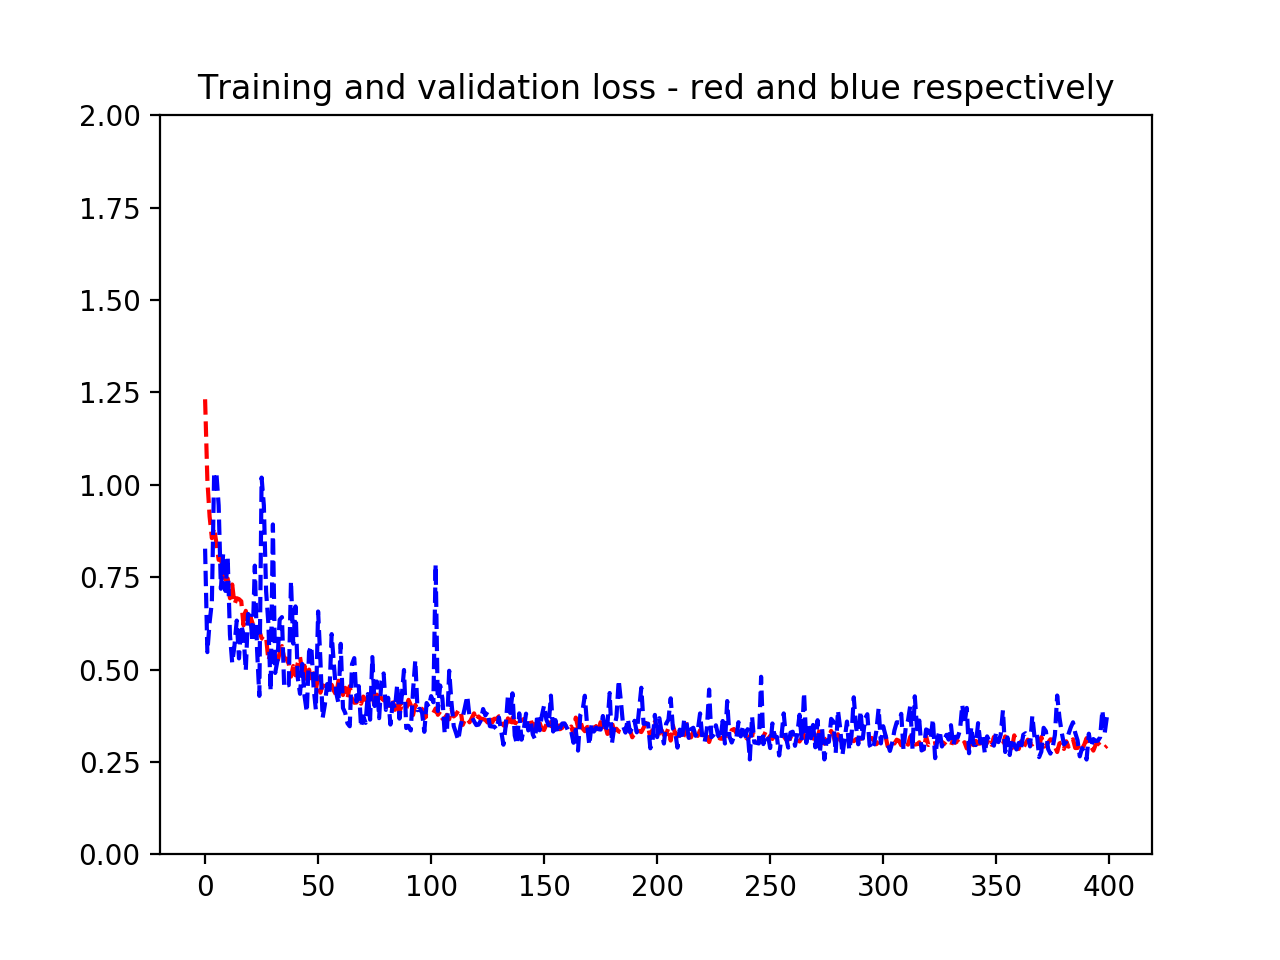

<IPython.core.display.Javascript object>


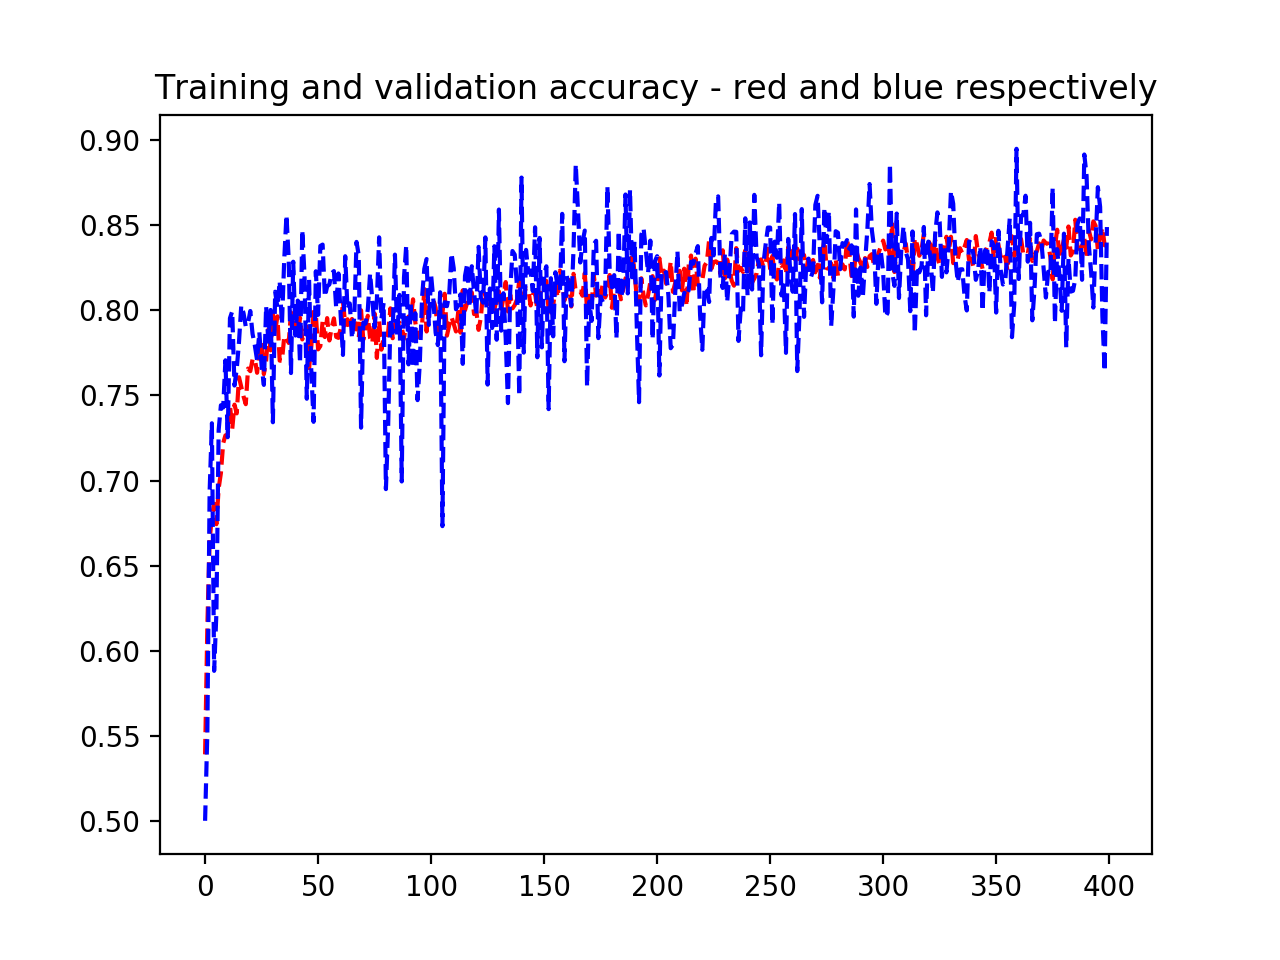

done


In [36]:
saved_dir = '../saved/IMPRS_hdf5_volume_AllDAPI_noise/0702_195748'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir, best=False) #imported from utils

print('done')

In [37]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    #print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    criterion = loss_fn(None)
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    #classes = ('endothelium', 'pct', 'vasculature')
    classes = ('endothelium', 'pct')
    all_pred = []
    all_true = []
    #hm_layers = {'final_layer': 'layer', 'fc_layer': 'fc_layer', 'conv_num': 17, 'fc_num': 3}
    
    #heatmapper = classActivationMap.CAMgenerator(hm_layers, config, model)
    #heatmapper.generateImage(num_images=10)
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            image = np.squeeze(data[0].cpu().data.numpy())
            label = np.squeeze(target[0].cpu().data.numpy())
            all_true.extend(target.cpu().data.numpy())
            all_pred.extend(np.argmax(output.cpu().data.numpy(), axis=1))
            
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 2:
                m = torch.nn.Softmax(dim=0)
                print("prediction percentages")
                print(m(output.cpu()[0]))
                print(all_true[i])
                #util.visualizationOutGray(data, output, target, classes, normalized)
                a=1
                
                
                
            # computing loss, metrics on test set
            loss = criterion(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            if output.is_cuda: output = output.cpu()
            if target.is_cuda: target = target.cpu()
            
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        #plt.show()
        
    
    n_samples = len(data_loader.sampler)
    print("num test images = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    for key in log:
        print("{} = {:.4f}".format(key, log[key]))
    #print(log)
    log['classes'] = classes
    log['test_targets'] = all_true
    log['test_predictions'] = all_pred
    print("My_metric is accuracy")
    util.plot_confusion_matrix(all_true, all_pred, classes=classes, normalize=False) 
    


In [38]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/6 [00:00<?, ?it/s]

Tesla K80


 17%|█▋        | 1/6 [00:00<00:01,  4.27it/s]

prediction percentages
tensor([0.1160, 0.8840])
1
prediction percentages
tensor([0.0173, 0.9827])
1


100%|██████████| 6/6 [00:00<00:00,  9.04it/s]

num test images = 340
loss = 0.4308
my_metric = 0.8441
f1 = 0.8899
balanced_accuracy = 0.8569
precision = 0.9548
recall = 0.8441
My_metric is accuracy
Confusion matrix, without normalization
[[107  27]
 [ 26 180]]


<IPython.core.display.Javascript object>


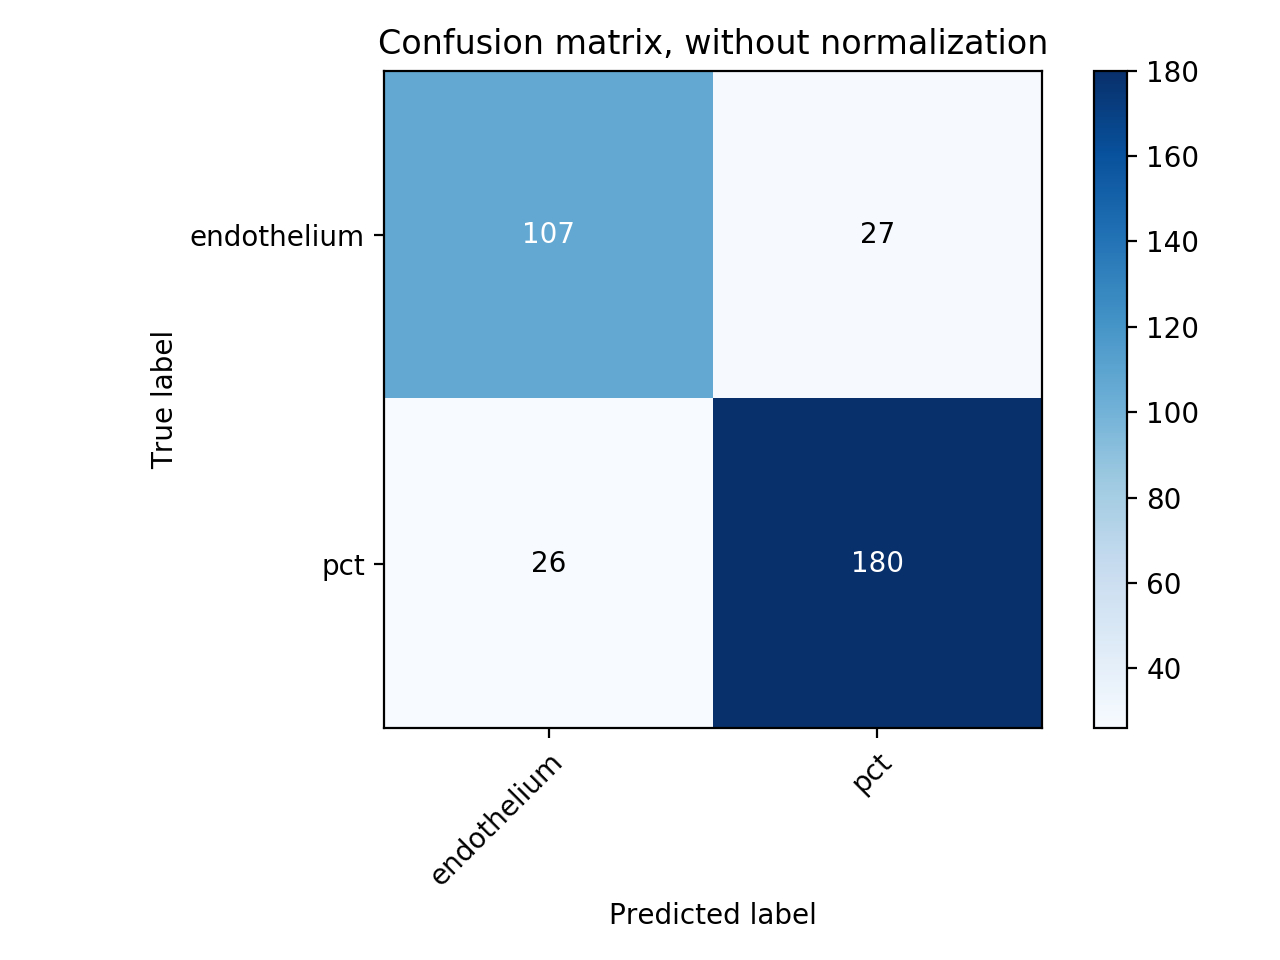

In [39]:
#Test
main2(config, resume)
